In [3]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import numpy as np
import cv2
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import load_model
import os



In [4]:


# Path to the directory containing images
image_dir = r"D:\Holland_Year_2\Block_B\2024-25b-fai2-adsai-PetarPaskalev232725\datalab_tasks\Task8\Kaggle"

# Loop through all image files in the directory
processed_images = []
for filename in os.listdir(image_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Add other formats if needed
        image_path = os.path.join(image_dir, filename)
        
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Skipping {filename} - could not load image.")
            continue
        
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize the image if necessary
        target_size = (256, 256)  # Define desired size
        resized_image = cv2.resize(gray_image, target_size, interpolation=cv2.INTER_AREA)
        
        # Normalize pixel values
        normalized_image = resized_image / 255.0
        
        # Patchify the image
        patch_size = 256  # Example patch size
        step_size = 256   # Example step size
        patches = patchify(normalized_image, (patch_size, patch_size), step=step_size)
        
        # Store patches for later use or processing
        processed_images.append((filename, patches))

        # Optional: Print progress
        print(f"Processed {filename} - Patches shape: {patches.shape}")

# Check the number of processed images
print(f"Total processed images: {len(processed_images)}")


Processed test_image_1.png - Patches shape: (1, 1, 256, 256)
Processed test_image_10.png - Patches shape: (1, 1, 256, 256)
Processed test_image_11.png - Patches shape: (1, 1, 256, 256)
Processed test_image_12.png - Patches shape: (1, 1, 256, 256)
Processed test_image_13.png - Patches shape: (1, 1, 256, 256)
Processed test_image_14.png - Patches shape: (1, 1, 256, 256)
Processed test_image_15.png - Patches shape: (1, 1, 256, 256)
Processed test_image_16.png - Patches shape: (1, 1, 256, 256)
Processed test_image_17.png - Patches shape: (1, 1, 256, 256)
Processed test_image_18.png - Patches shape: (1, 1, 256, 256)
Processed test_image_2.png - Patches shape: (1, 1, 256, 256)
Processed test_image_3.png - Patches shape: (1, 1, 256, 256)
Processed test_image_4.png - Patches shape: (1, 1, 256, 256)
Processed test_image_5.png - Patches shape: (1, 1, 256, 256)
Processed test_image_6.png - Patches shape: (1, 1, 256, 256)
Processed test_image_7.png - Patches shape: (1, 1, 256, 256)
Processed test_

In [5]:


# **Load and preprocess all images in the dataset**
def load_images_from_directory(directory_path):
    """
    Load all images from a directory in grayscale mode.
    """
    images = []
    filenames = []
    for filename in os.listdir(directory_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Supported formats
            image_path = os.path.join(directory_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                images.append(image)
                filenames.append(filename)
            else:
                print(f"Failed to load {filename}")
    return images, filenames

# **Detect edges to find the Petri dish**
def detect_edges(image, max_size=2800):
    """
    Detect edges and find the approximate square Petri dish.
    """
    blurred_image = cv2.GaussianBlur(image, (51, 51), 0)
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = cv2.magnitude(sobel_x, sobel_y)
    _, edges = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)
    edges = edges.astype(np.uint8)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)

    side_length = min(max(w, h), max_size)
    center_x, center_y = x + w // 2, y + h // 2
    half_side = side_length // 2
    new_x = max(center_x - half_side, 0)
    new_y = max(center_y - half_side, 0)
    new_w = new_h = min(side_length, min(image.shape[1] - new_x, image.shape[0] - new_y))
    return new_x, new_x + new_w, new_y, new_y + new_h

# **Crop the image based on detected edges**
def crop_image(image, edges, max_size=2800):
    """
    Crop the image based on detected edges and resize if necessary.
    """
    left, right, top, bottom = edges
    cropped = image[top:bottom, left:right]
    if cropped.shape[1] > max_size or cropped.shape[0] > max_size:
        cropped = cv2.resize(cropped, (min(cropped.shape[1], max_size), min(cropped.shape[0], max_size)))
    return cropped

# **Pad the image to make dimensions divisible by the patch size**
def padder(image, patch_size):
    """
    Add padding to make dimensions divisible by the patch size.
    """
    h, w = image.shape[:2]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w
    top_padding = int(height_padding / 2)
    bottom_padding = height_padding - top_padding
    left_padding = int(width_padding / 2)
    right_padding = width_padding - left_padding
    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=0)
    return padded_image

# **Patchify and normalize the image**
def preprocess_image(image, patch_size=256):
    """
    Preprocess the image: pad, patchify, and normalize.
    """
    patches = patchify(image, (patch_size, patch_size), step=patch_size)
    patches_reshaped = patches.reshape(-1, patch_size, patch_size, 1)  # Add channel dimension
    patches_normalized = patches_reshaped / 255.0
    return patches, patches_normalized

# **Run the preprocessing pipeline**
image_dir = r"D:\Holland_Year_2\Block_B\2024-25b-fai2-adsai-PetarPaskalev232725\datalab_tasks\Task8\Kaggle"

# Load all images from the directory
images, filenames = load_images_from_directory(image_dir)

# Preprocess each image
preprocessed_data = []
patch_size = 256
for image, filename in zip(images, filenames):
    edges = detect_edges(image)
    cropped_image = crop_image(image, edges)
    petri_dish_padded = padder(cropped_image, patch_size)
    patches, patches_normalized = preprocess_image(petri_dish_padded, patch_size)
    preprocessed_data.append((filename, patches_normalized))

    # Print progress
    print(f"Processed {filename}: Original shape {image.shape}, Padded shape {petri_dish_padded.shape}, Patches {patches.shape}")

# Verify results
print(f"Total images processed: {len(preprocessed_data)}")


Processed test_image_1.png: Original shape (3006, 4112), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_10.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_11.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_12.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_13.png: Original shape (2999, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_14.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_15.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_16.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_17.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256

In [6]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

8/8 [==============================] - 15s 191ms/step
Prediction completed for test_image_1.png
8/8 [==============================] - 0s 45ms/step
Prediction completed for test_image_10.png
8/8 [==============================] - 0s 40ms/step
Prediction completed for test_image_11.png
8/8 [==============================] - 0s 36ms/step
Prediction completed for test_image_12.png
8/8 [==============================] - 0s 44ms/step
Prediction completed for test_image_13.png
8/8 [==============================] - 0s 41ms/step
Prediction completed for test_image_14.png
8/8 [==============================] - 0s 39ms/step
Prediction completed for test_image_15.png
8/8 [==============================] - 0s 41ms/step
Prediction completed for test_image_16.png
8/8 [==============================] - 0s 40ms/step
Prediction completed for test_image_17.png
8/8 [==============================] - 0s 42ms/step
Prediction completed for test_image_18.png
8/8 [==============================] - 0s 45ms/st

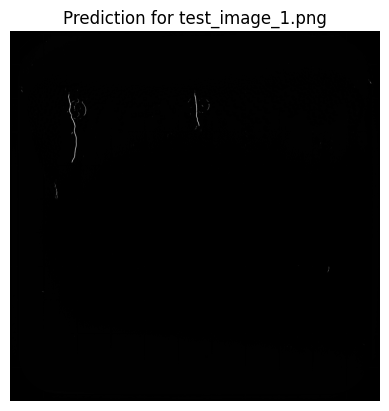

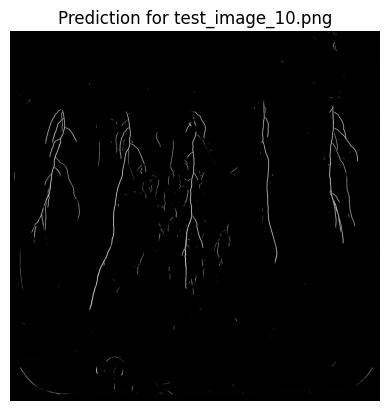

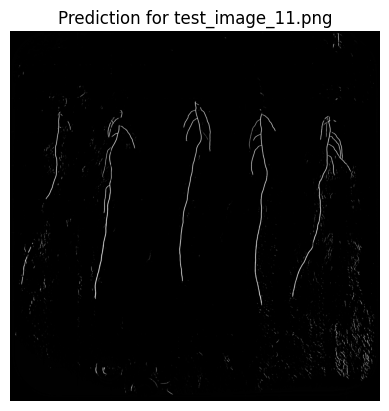

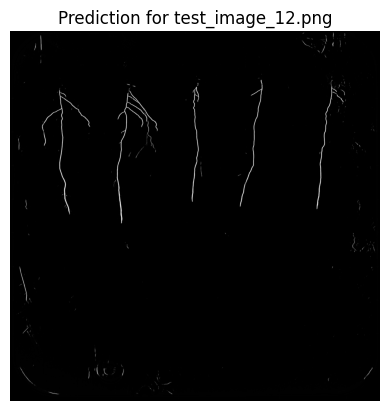

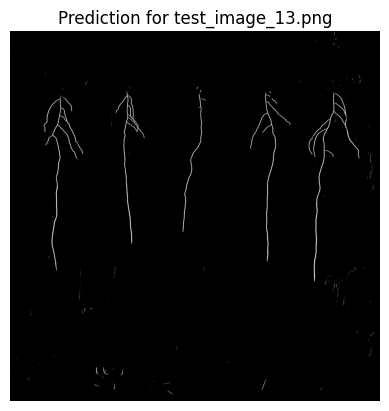

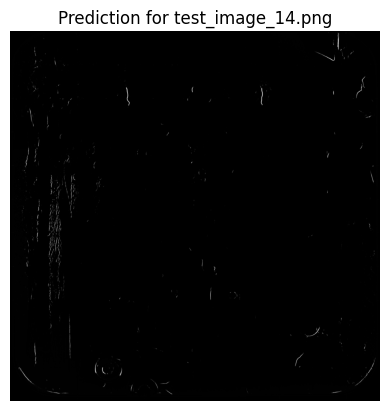

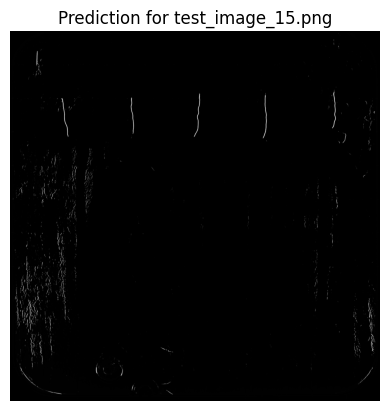

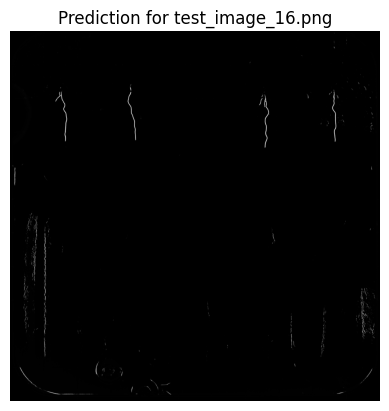

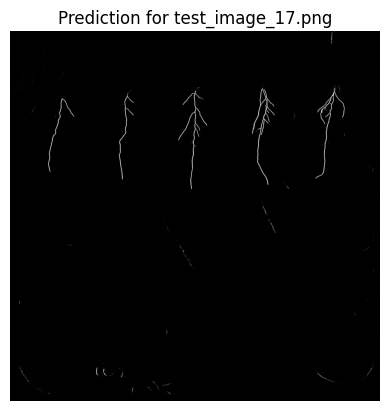

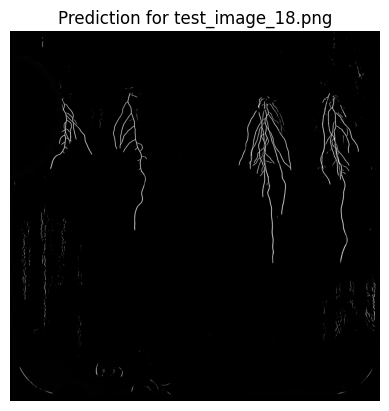

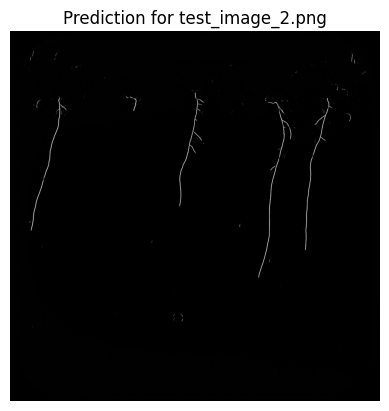

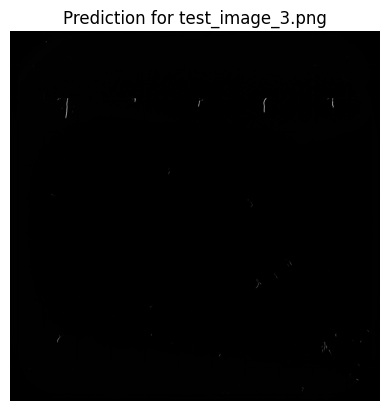

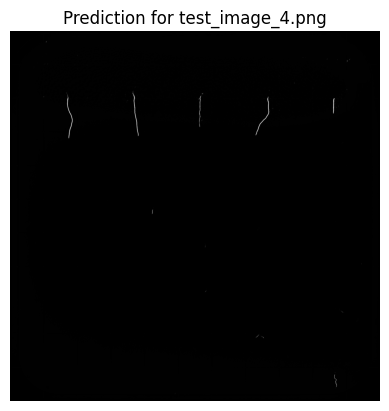

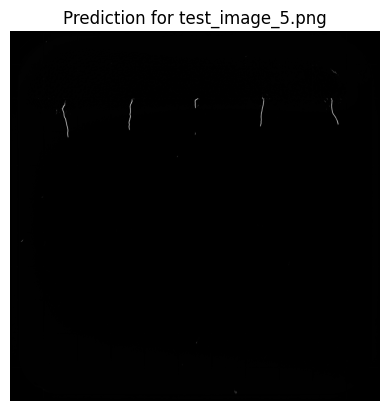

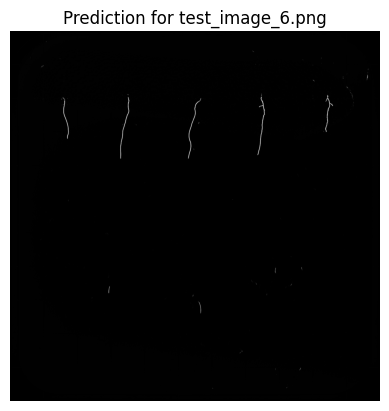

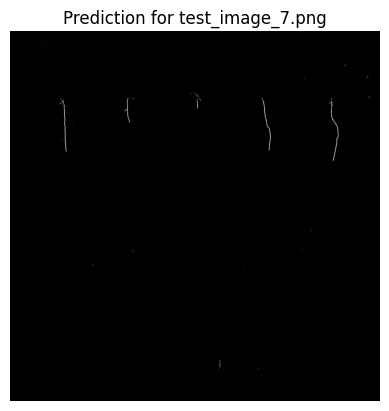

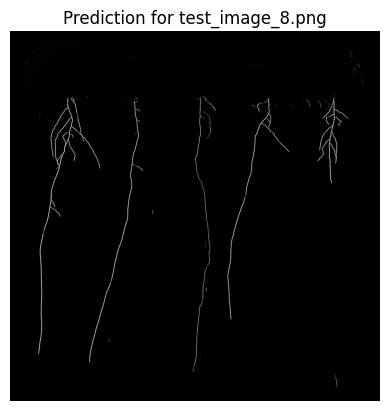

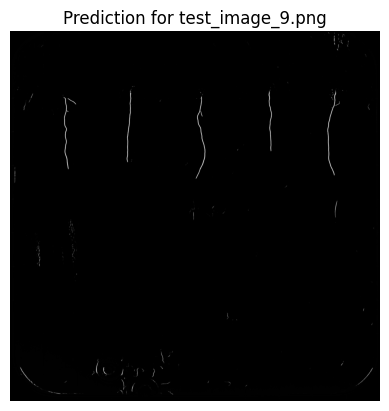

In [7]:


# **Load the model**
model_path = "PetarPaskalev_232725_unet_model_2_256px_80F1.h5"
model = load_model(model_path, custom_objects={"f1": f1})

# **Run predictions**
predictions = []
for filename, patches_normalized in preprocessed_data:
    # Predict on patches
    predicted_patches = model.predict(patches_normalized, batch_size=16)
    
    # Reshape predictions back to original patch grid
    num_patches = int(np.sqrt(predicted_patches.shape[0]))  # Assuming square grid
    predicted_patches = predicted_patches.reshape(num_patches, num_patches, patch_size, patch_size)
    
    # Reconstruct the full image using unpatchify
    petri_dish_padded_shape = (patch_size * num_patches, patch_size * num_patches)
    reconstructed_prediction = unpatchify(predicted_patches, petri_dish_padded_shape)
    
    # Store the prediction
    predictions.append((filename, reconstructed_prediction))
    print(f"Prediction completed for {filename}")

# **Visualize predictions**
for filename, predicted_mask in predictions:
    plt.figure(dpi=100)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f"Prediction for {filename}")
    plt.axis('off')
    plt.show()


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Loop through predictions and convert each mask to binary
binary_predictions = []
for filename, predicted_mask in predictions:
    # Convert predicted mask to binary: thresholding at 0.5
    binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255
    
    # Store the binary mask
    binary_predictions.append((filename, binary_mask))

 

  


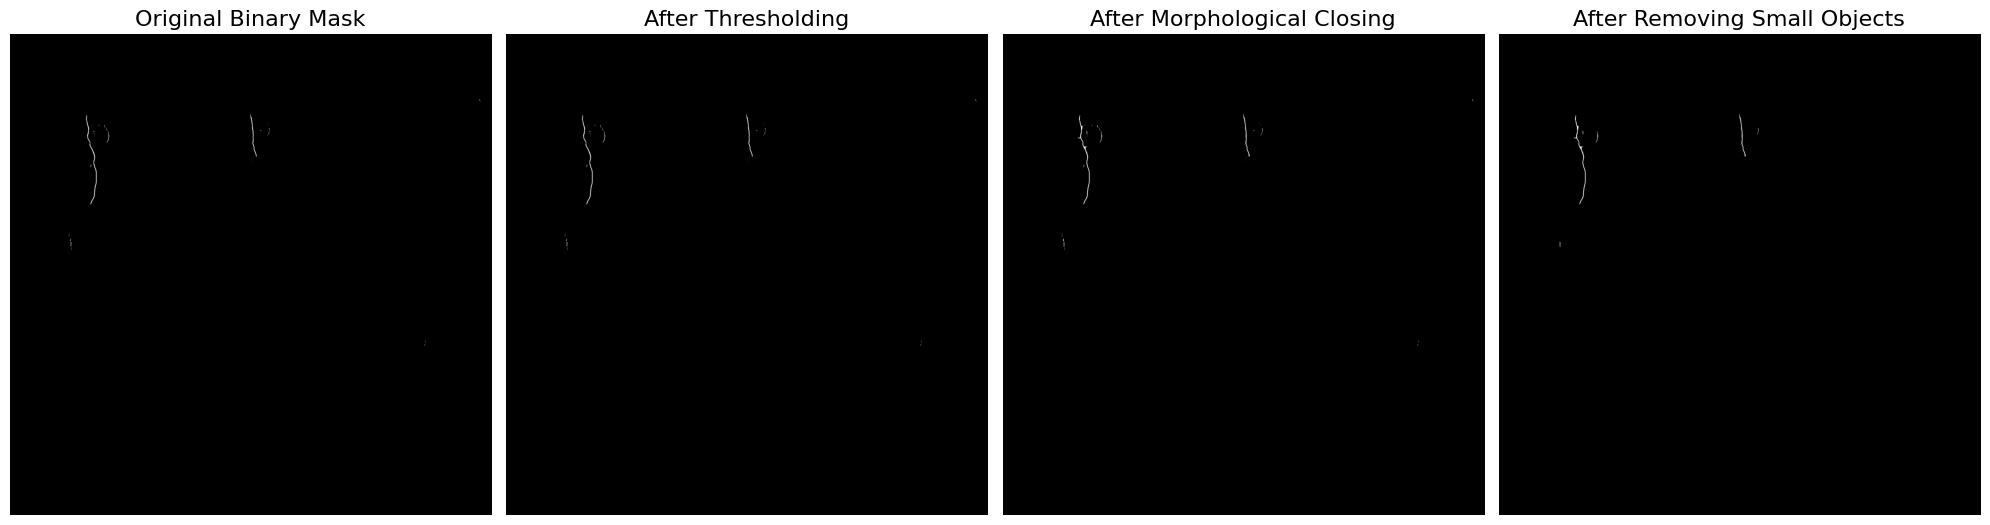

Processed test_image_1.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


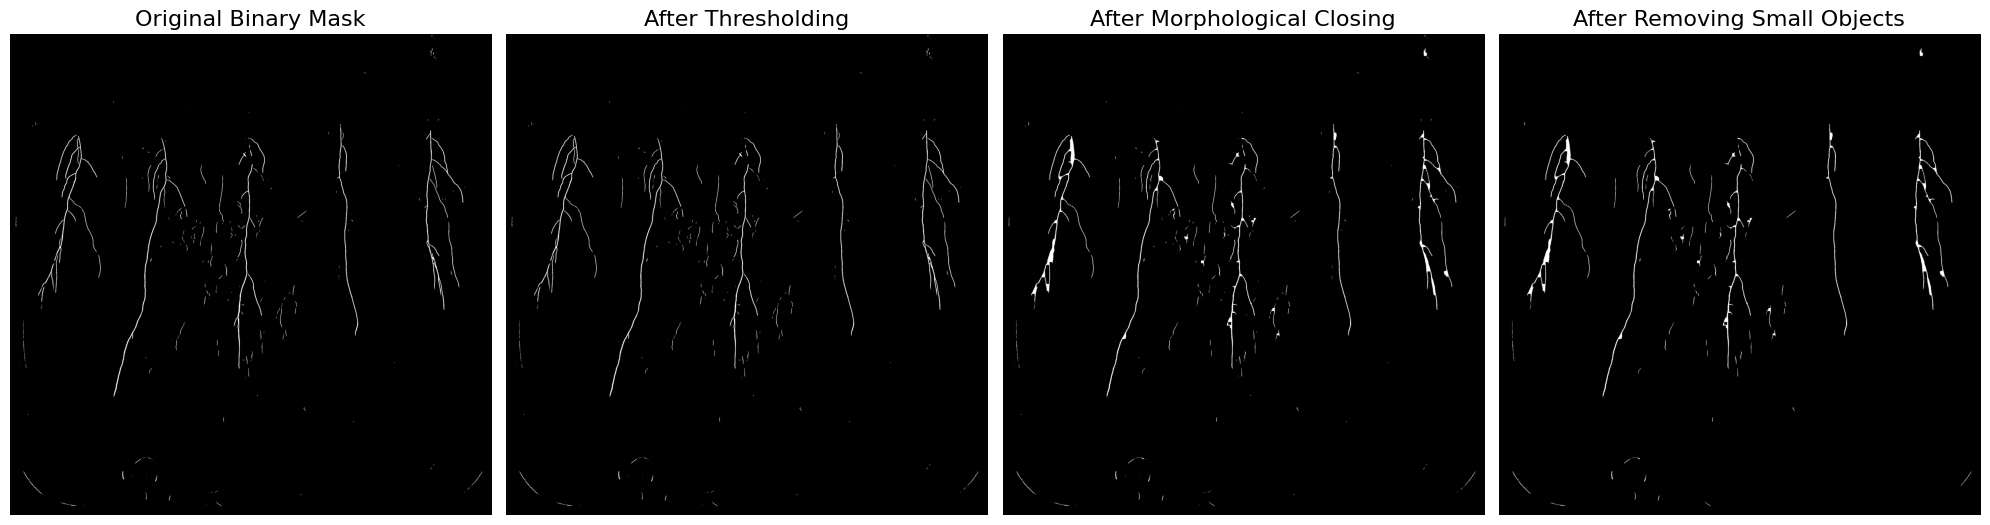

Processed test_image_10.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


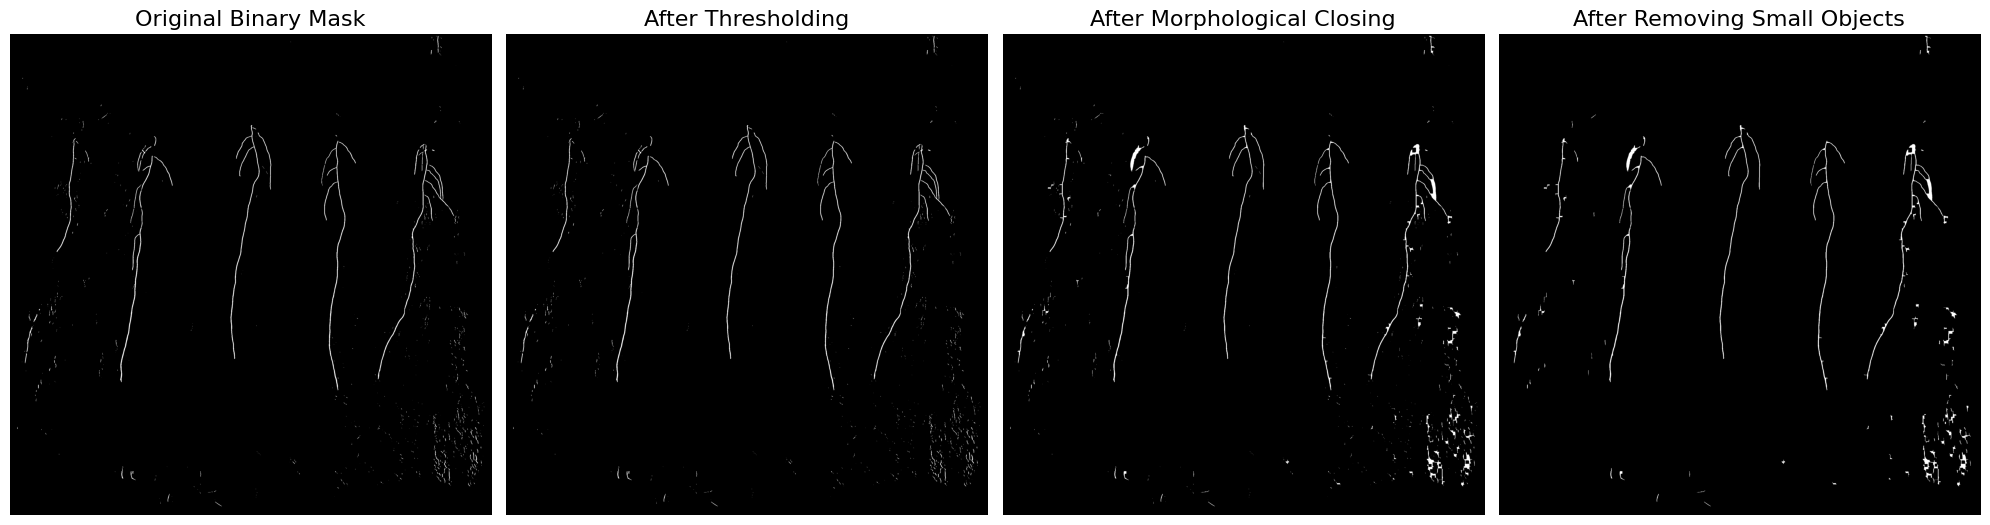

Processed test_image_11.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


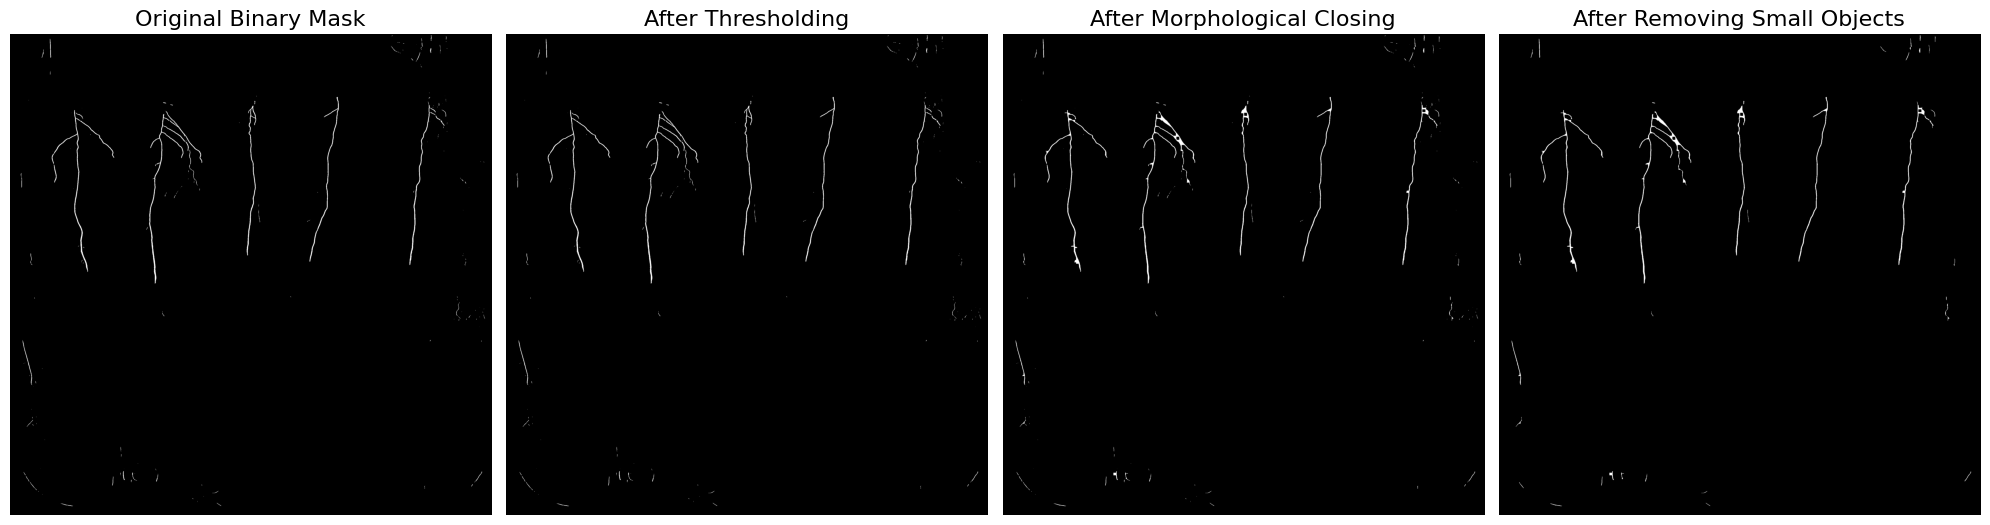

Processed test_image_12.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


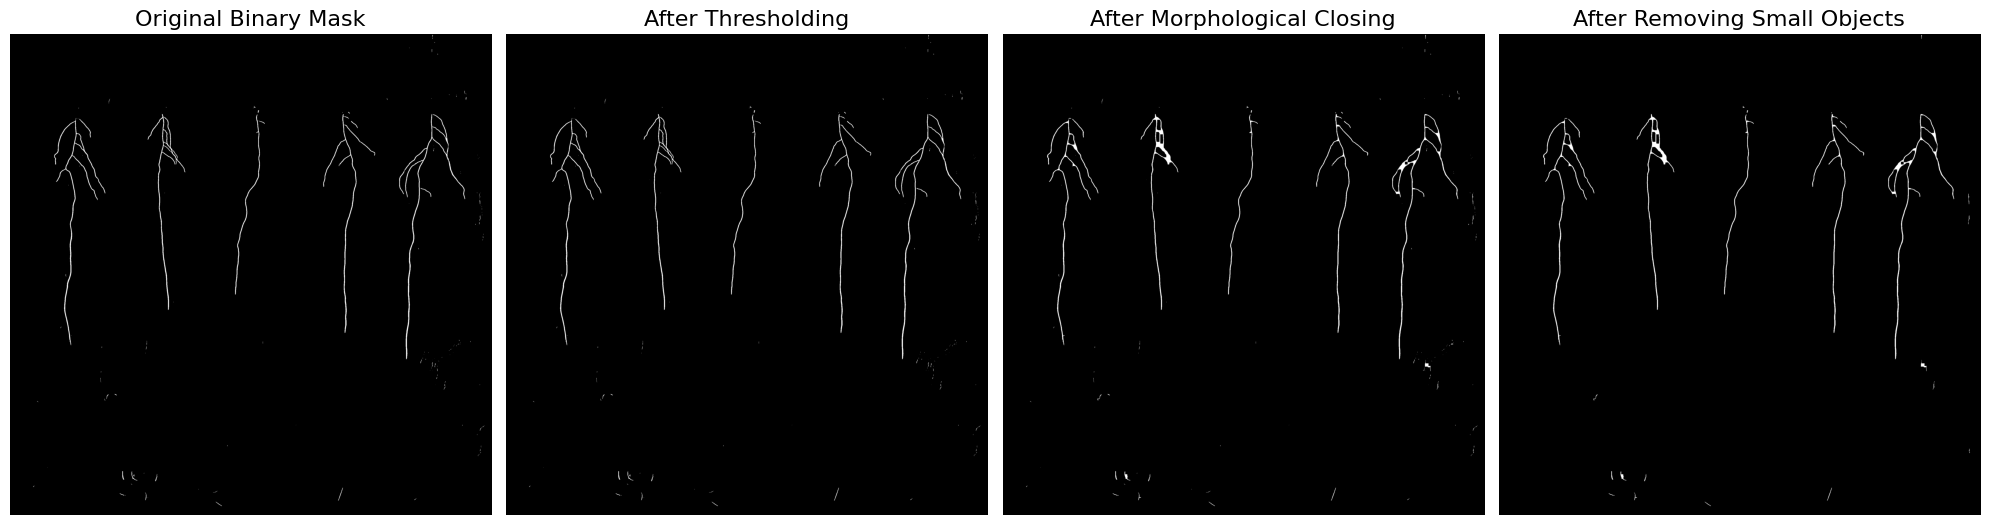

Processed test_image_13.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


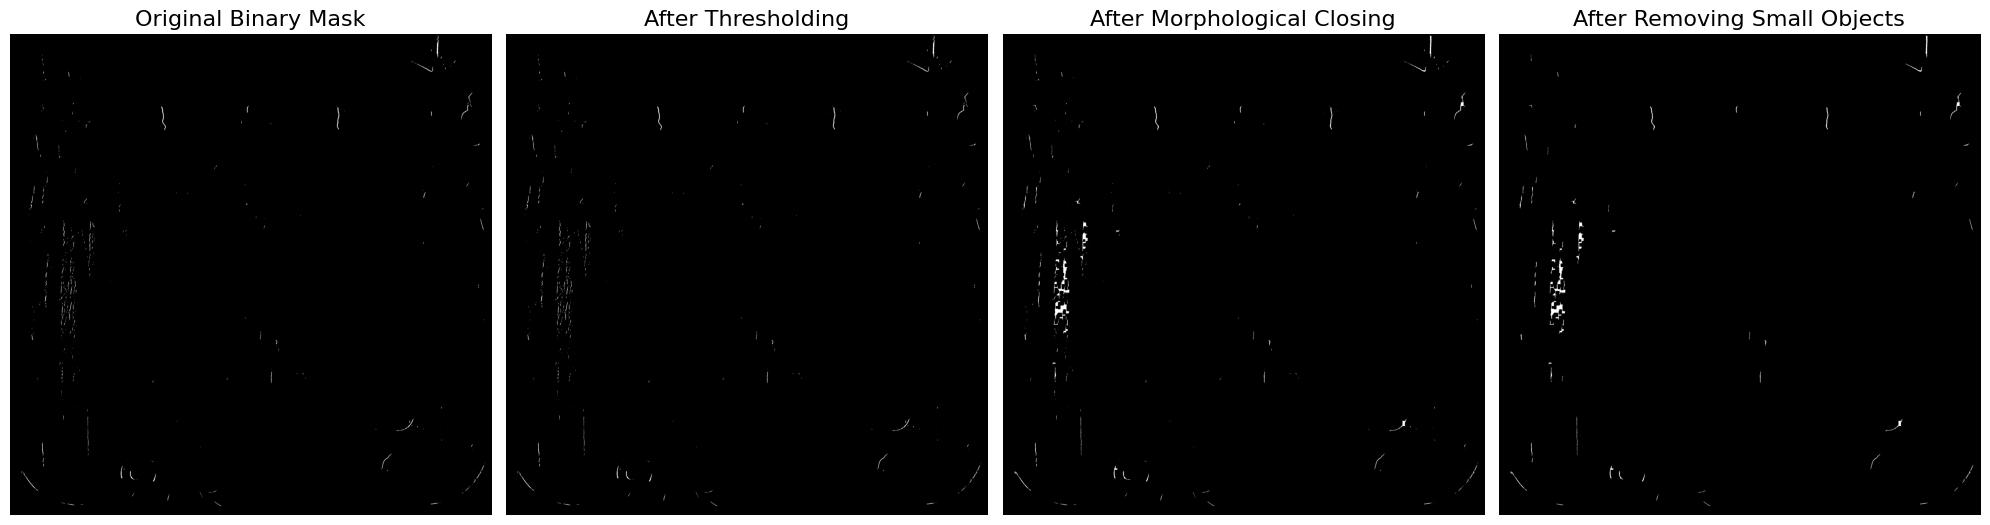

Processed test_image_14.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


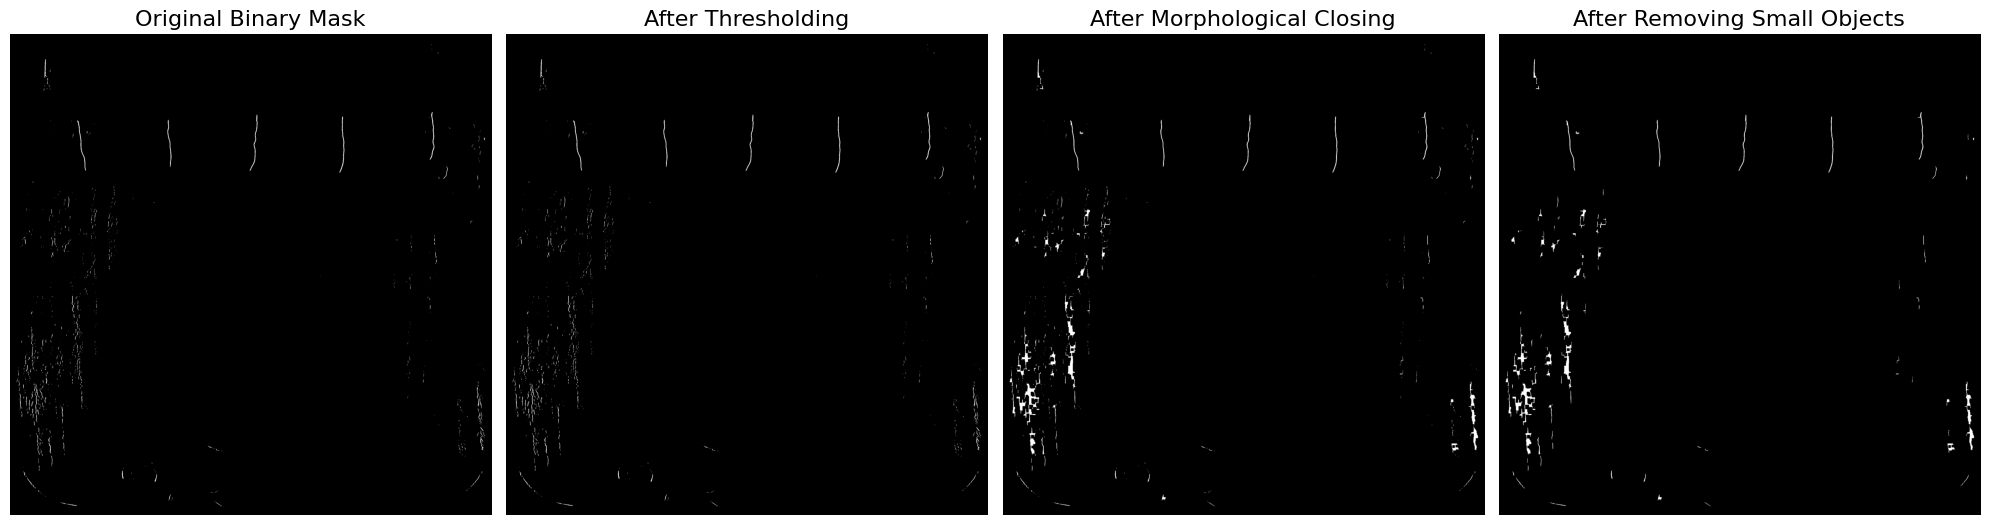

Processed test_image_15.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


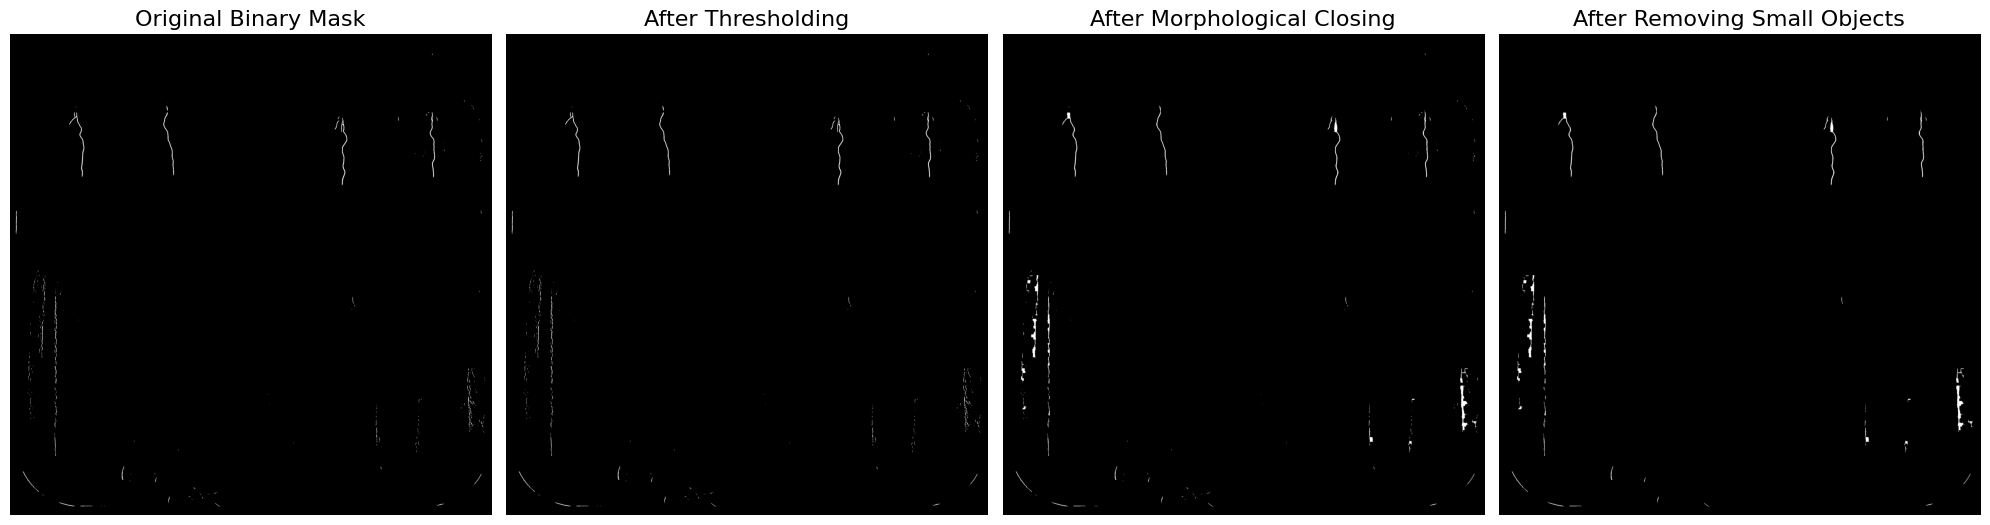

Processed test_image_16.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


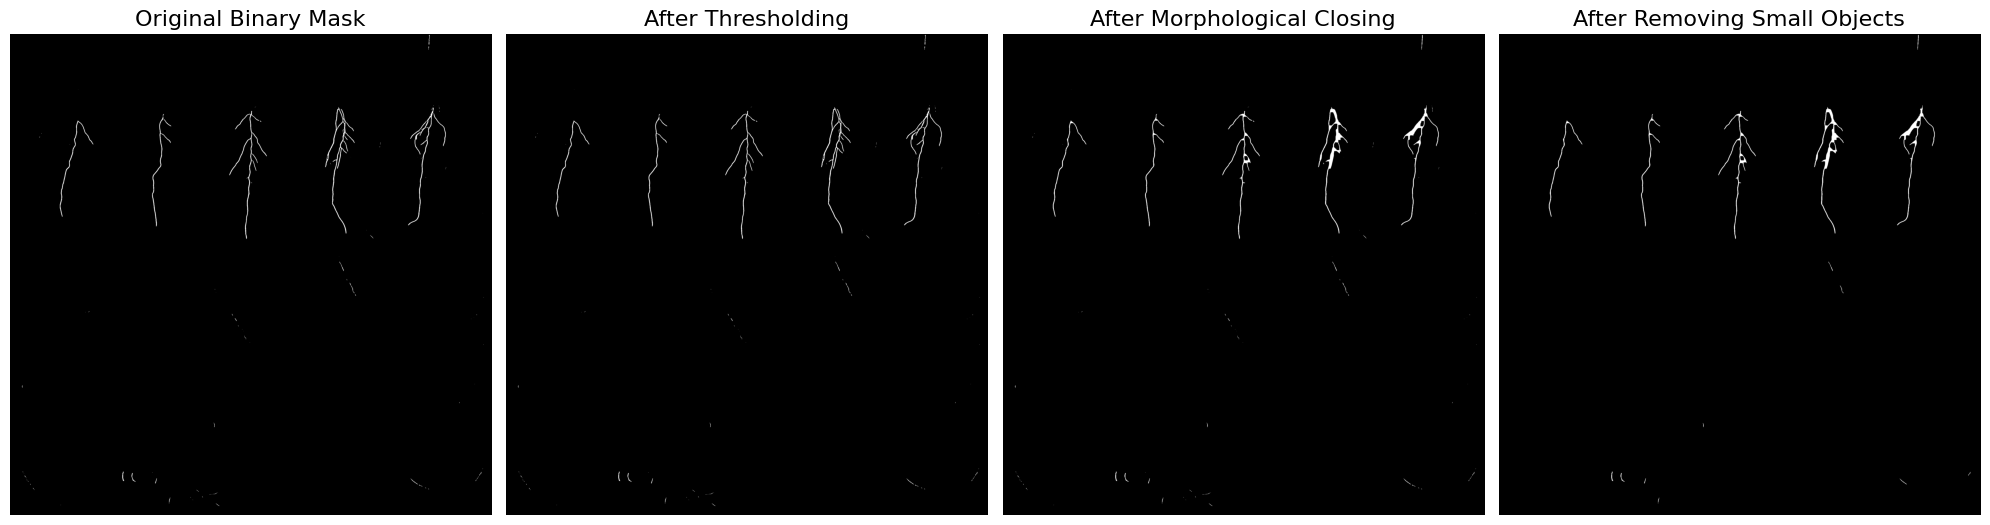

Processed test_image_17.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


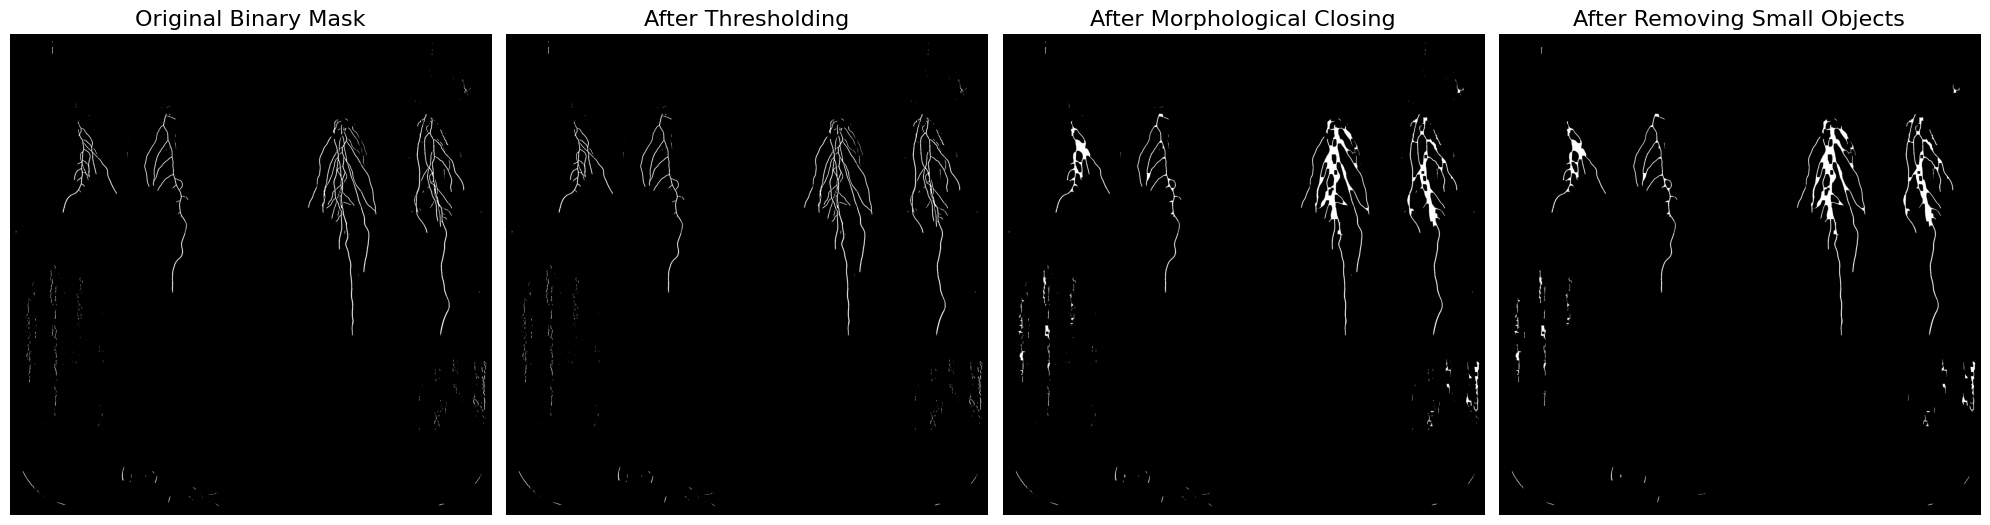

Processed test_image_18.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


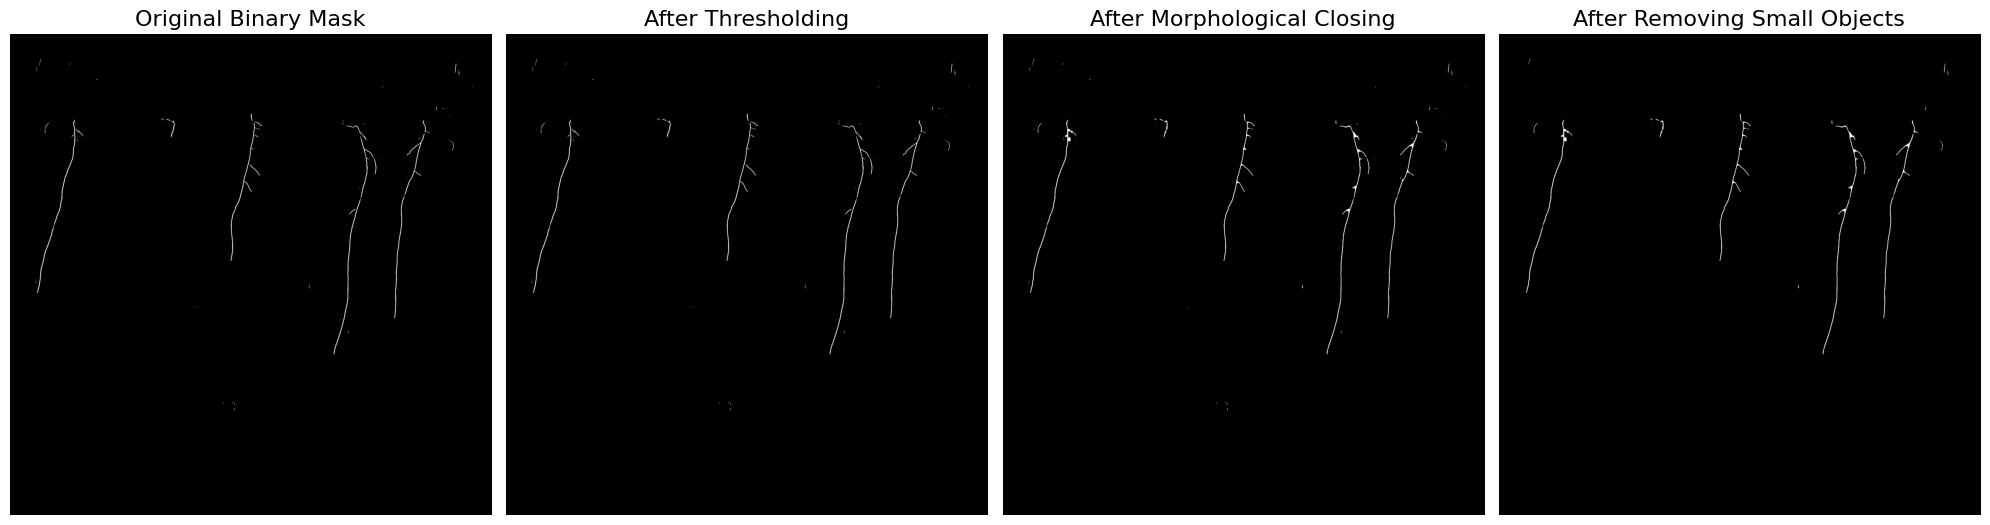

Processed test_image_2.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


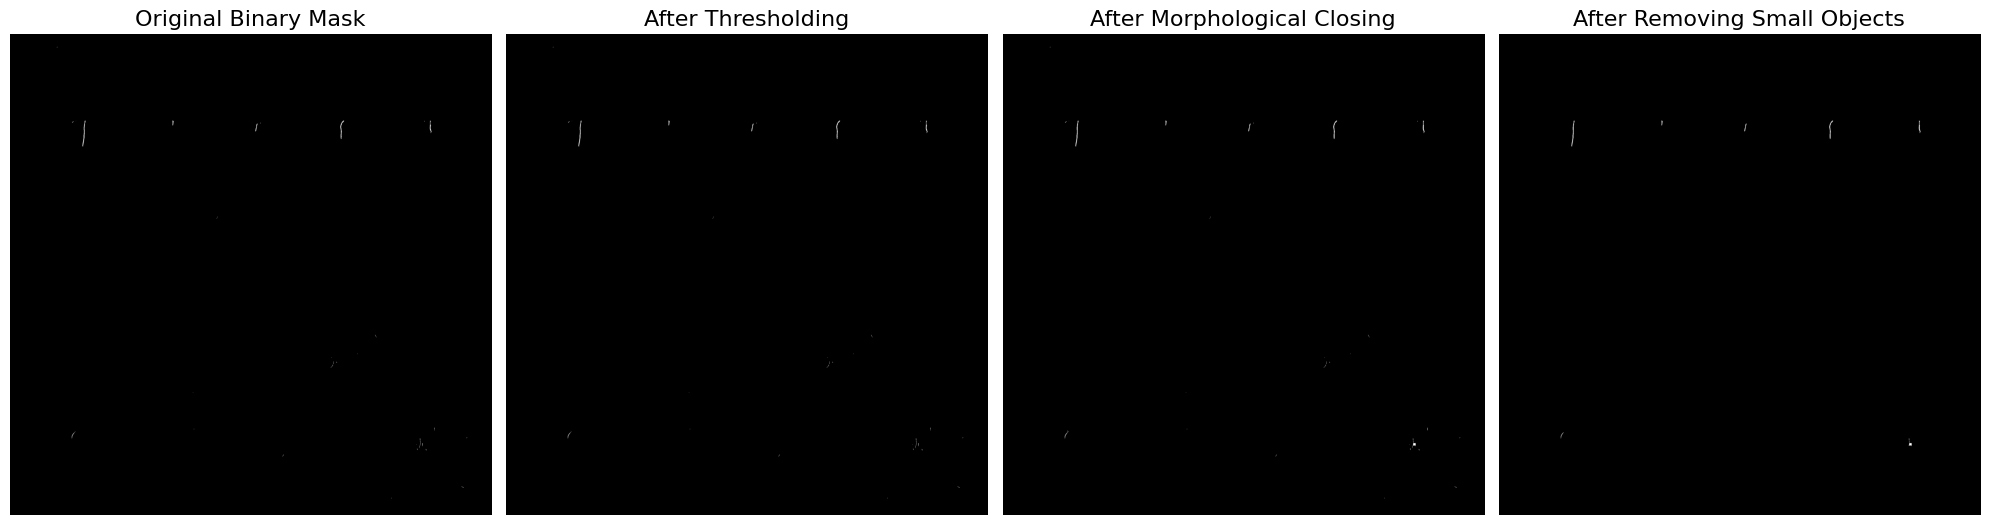

Processed test_image_3.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


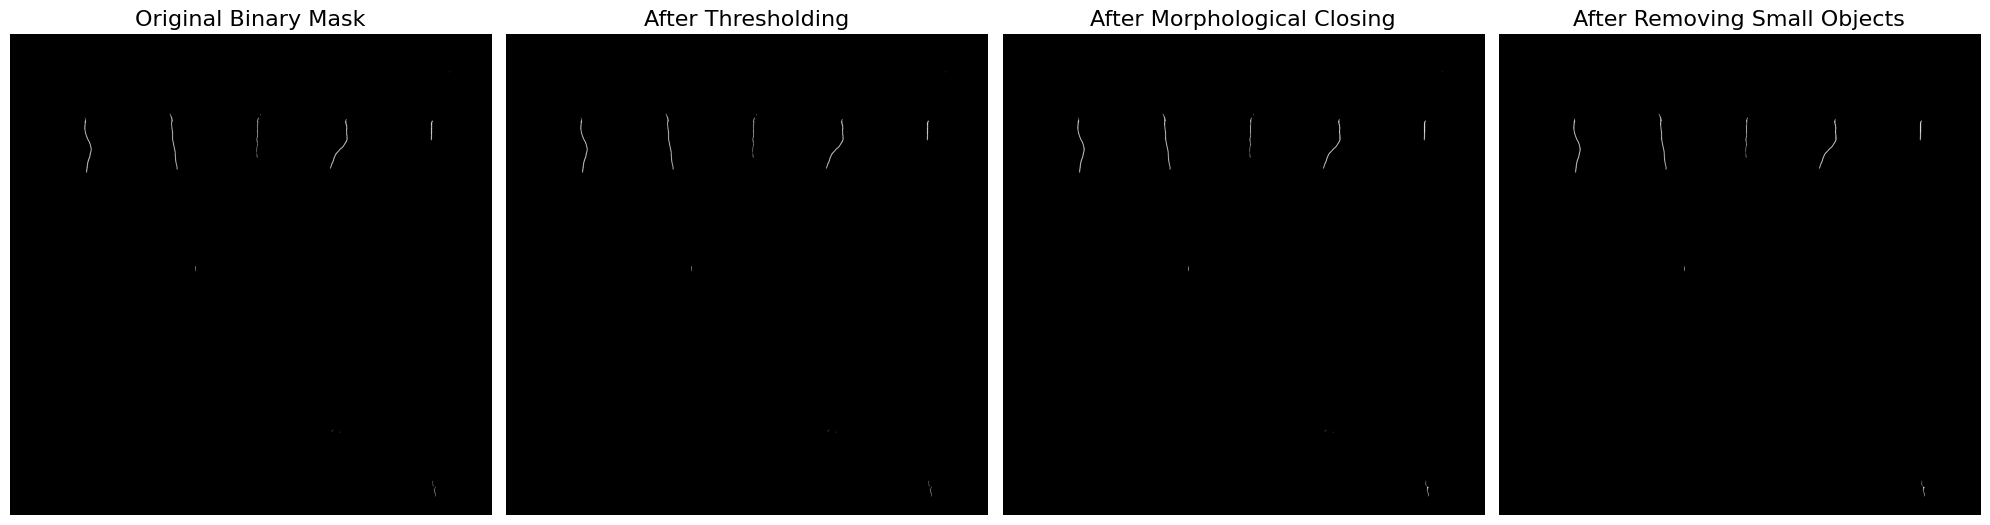

Processed test_image_4.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


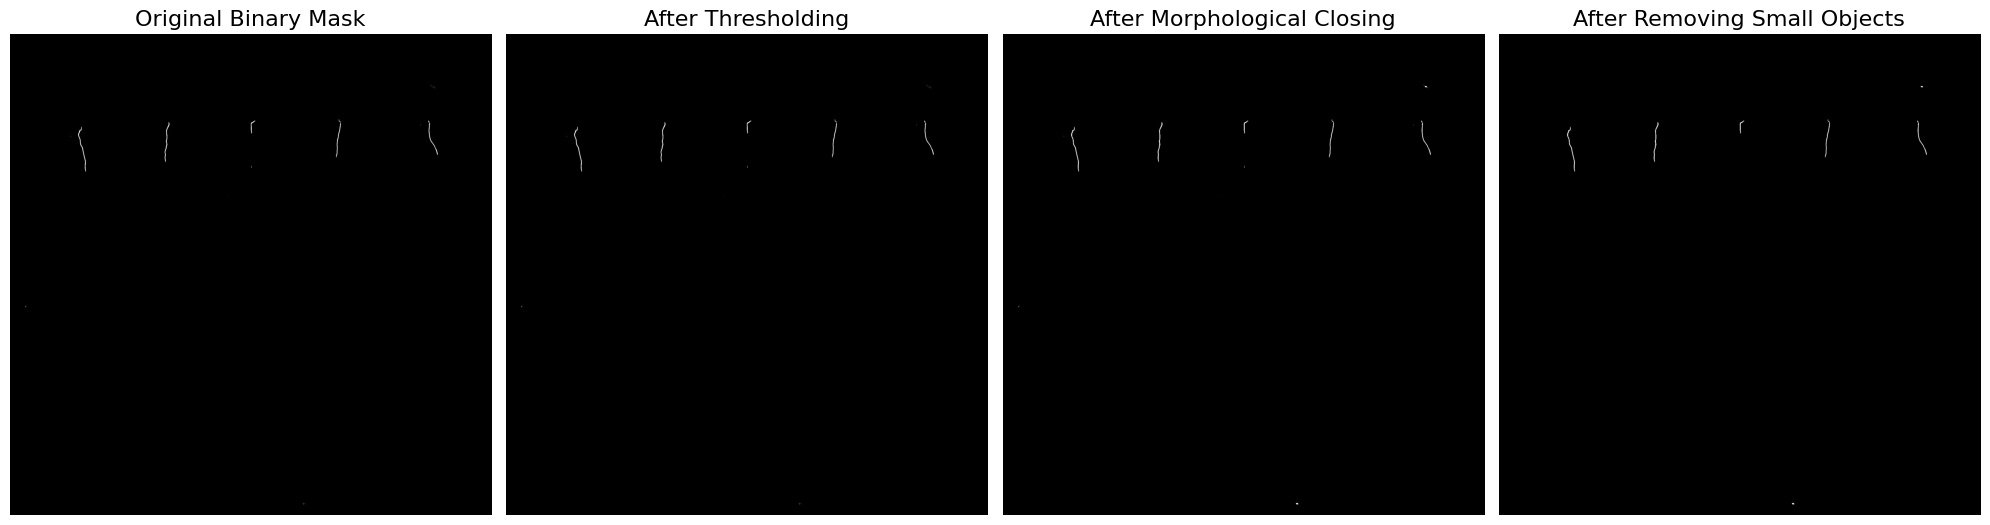

Processed test_image_5.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


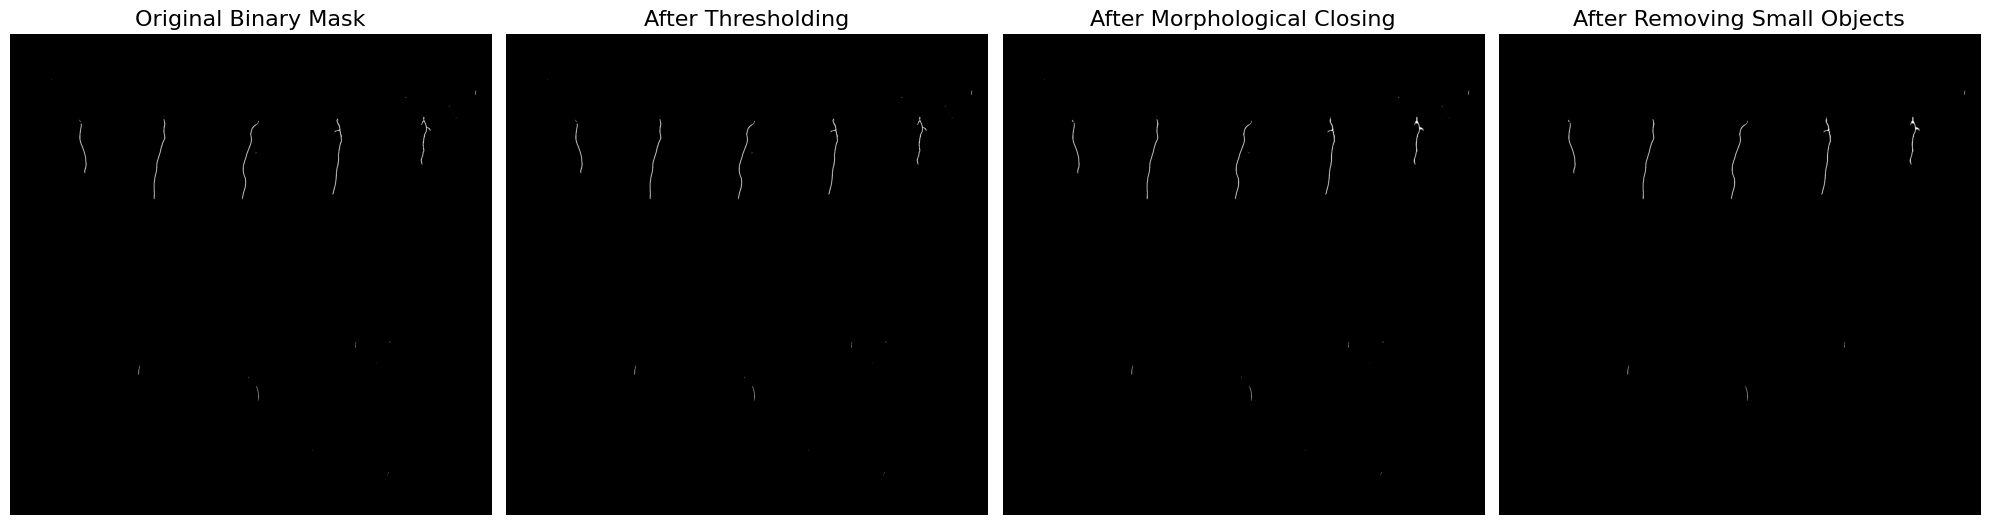

Processed test_image_6.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


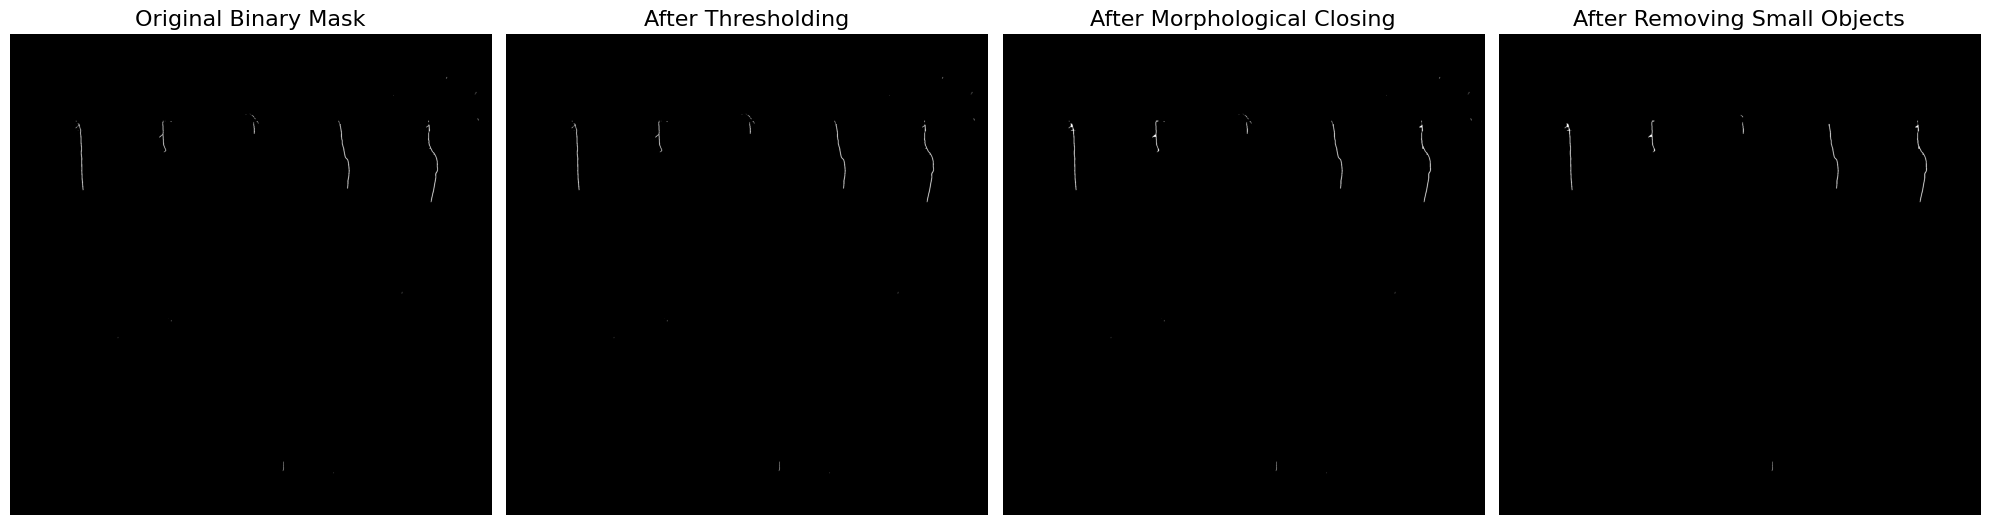

Processed test_image_7.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


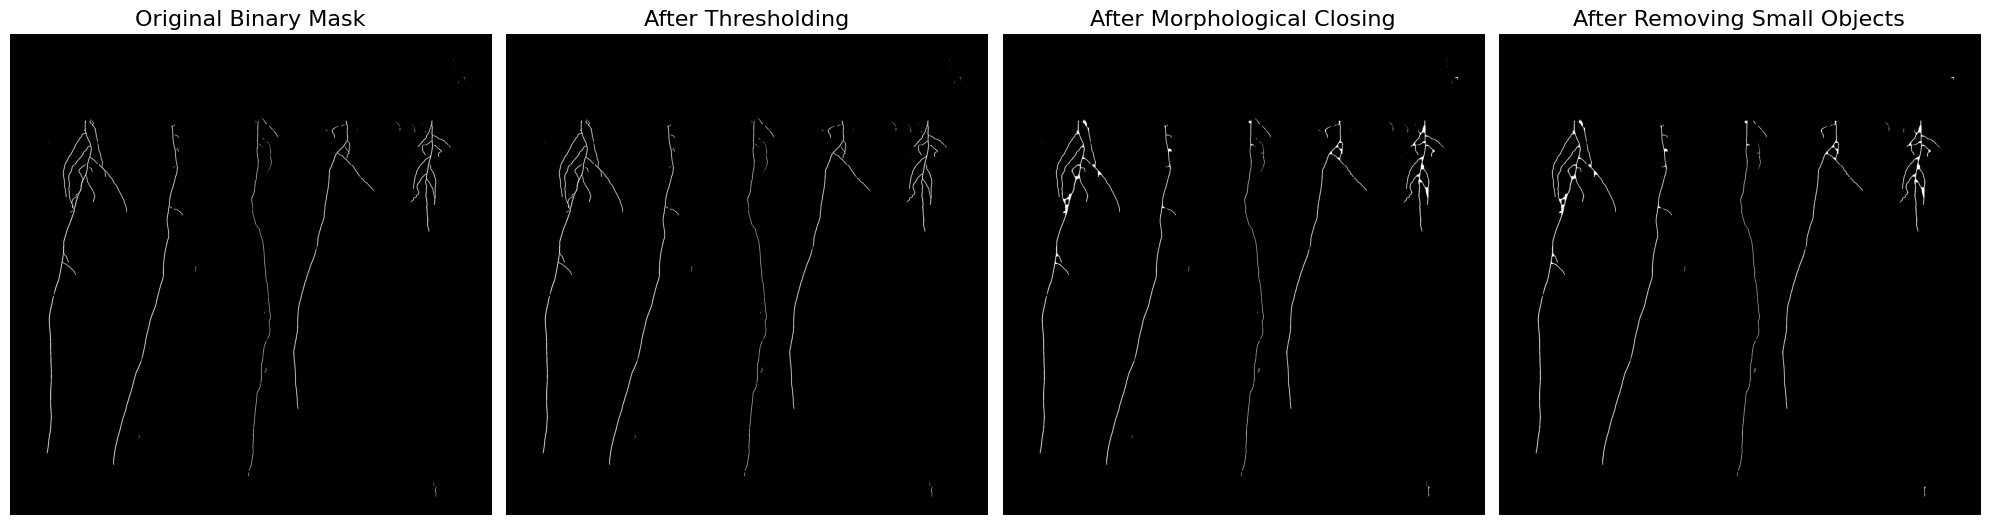

Processed test_image_8.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


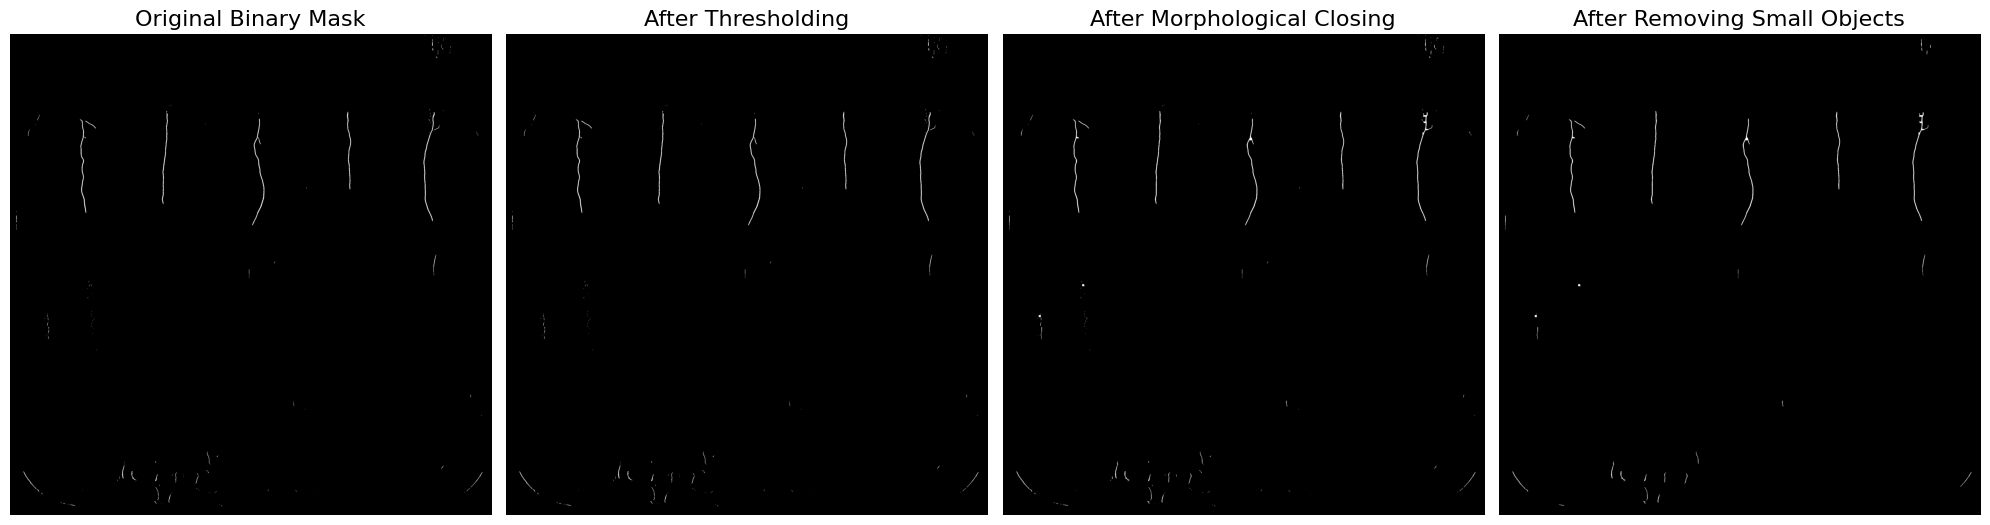

Processed test_image_9.png: Threshold = 5, Kernel Size = 15, Min Object Size = 50


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects

# Adjustable parameters
threshold_value = 5       # Adjust threshold value
kernel_size = 15  # Adjust kernel size for morphological closing
min_object_size = 50     # Adjust minimum object size for small object removal

# Process each binary mask in binary_predictions
processed_masks = []
for filename, binary_mask in binary_predictions:
    # Step 1: Apply thresholding
    _, thresholded_mask = cv2.threshold(binary_mask, threshold_value, 255, cv2.THRESH_BINARY)
    
    # Step 2: Apply morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    closed_mask = cv2.morphologyEx(thresholded_mask, cv2.MORPH_CLOSE, kernel)
    
    # Step 3: Remove small objects
    binary_mask_boolean = closed_mask > 0  # Convert to boolean (True for object pixels)
    cleaned_mask = remove_small_objects(binary_mask_boolean, min_size=min_object_size)
    cleaned_mask = (cleaned_mask * 255).astype(np.uint8)  # Convert back to uint8

    # Append processed mask
    processed_masks.append((filename, cleaned_mask))

    # Plot intermediate and final results
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 4, 1)
    plt.title("Original Binary Mask", fontsize=16)
    plt.imshow(binary_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("After Thresholding", fontsize=16)
    plt.imshow(thresholded_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("After Morphological Closing", fontsize=16)
    plt.imshow(closed_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("After Removing Small Objects", fontsize=16)
    plt.imshow(cleaned_mask, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Processed {filename}: Threshold = {threshold_value}, Kernel Size = {kernel_size}, Min Object Size = {min_object_size}")


Filename: test_image_1.png | Number of connected components: 6


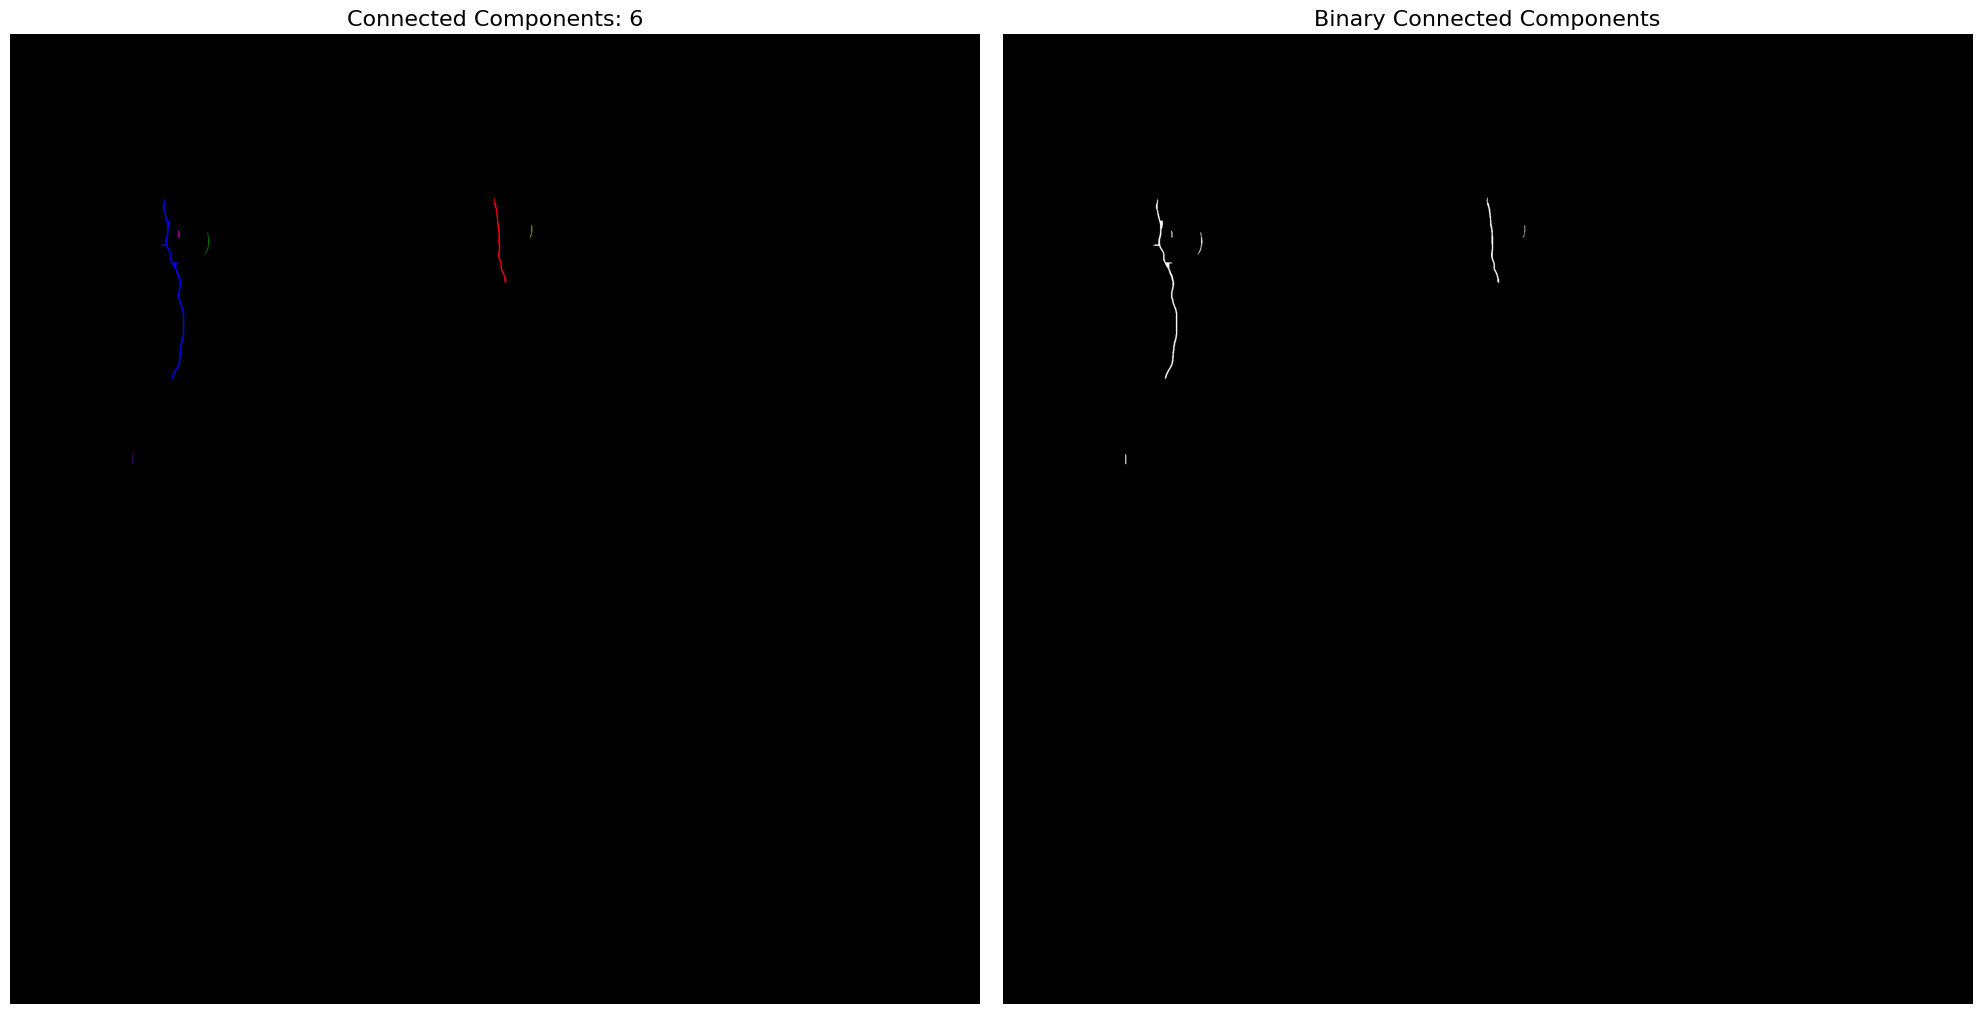

Filename: test_image_10.png | Number of connected components: 77


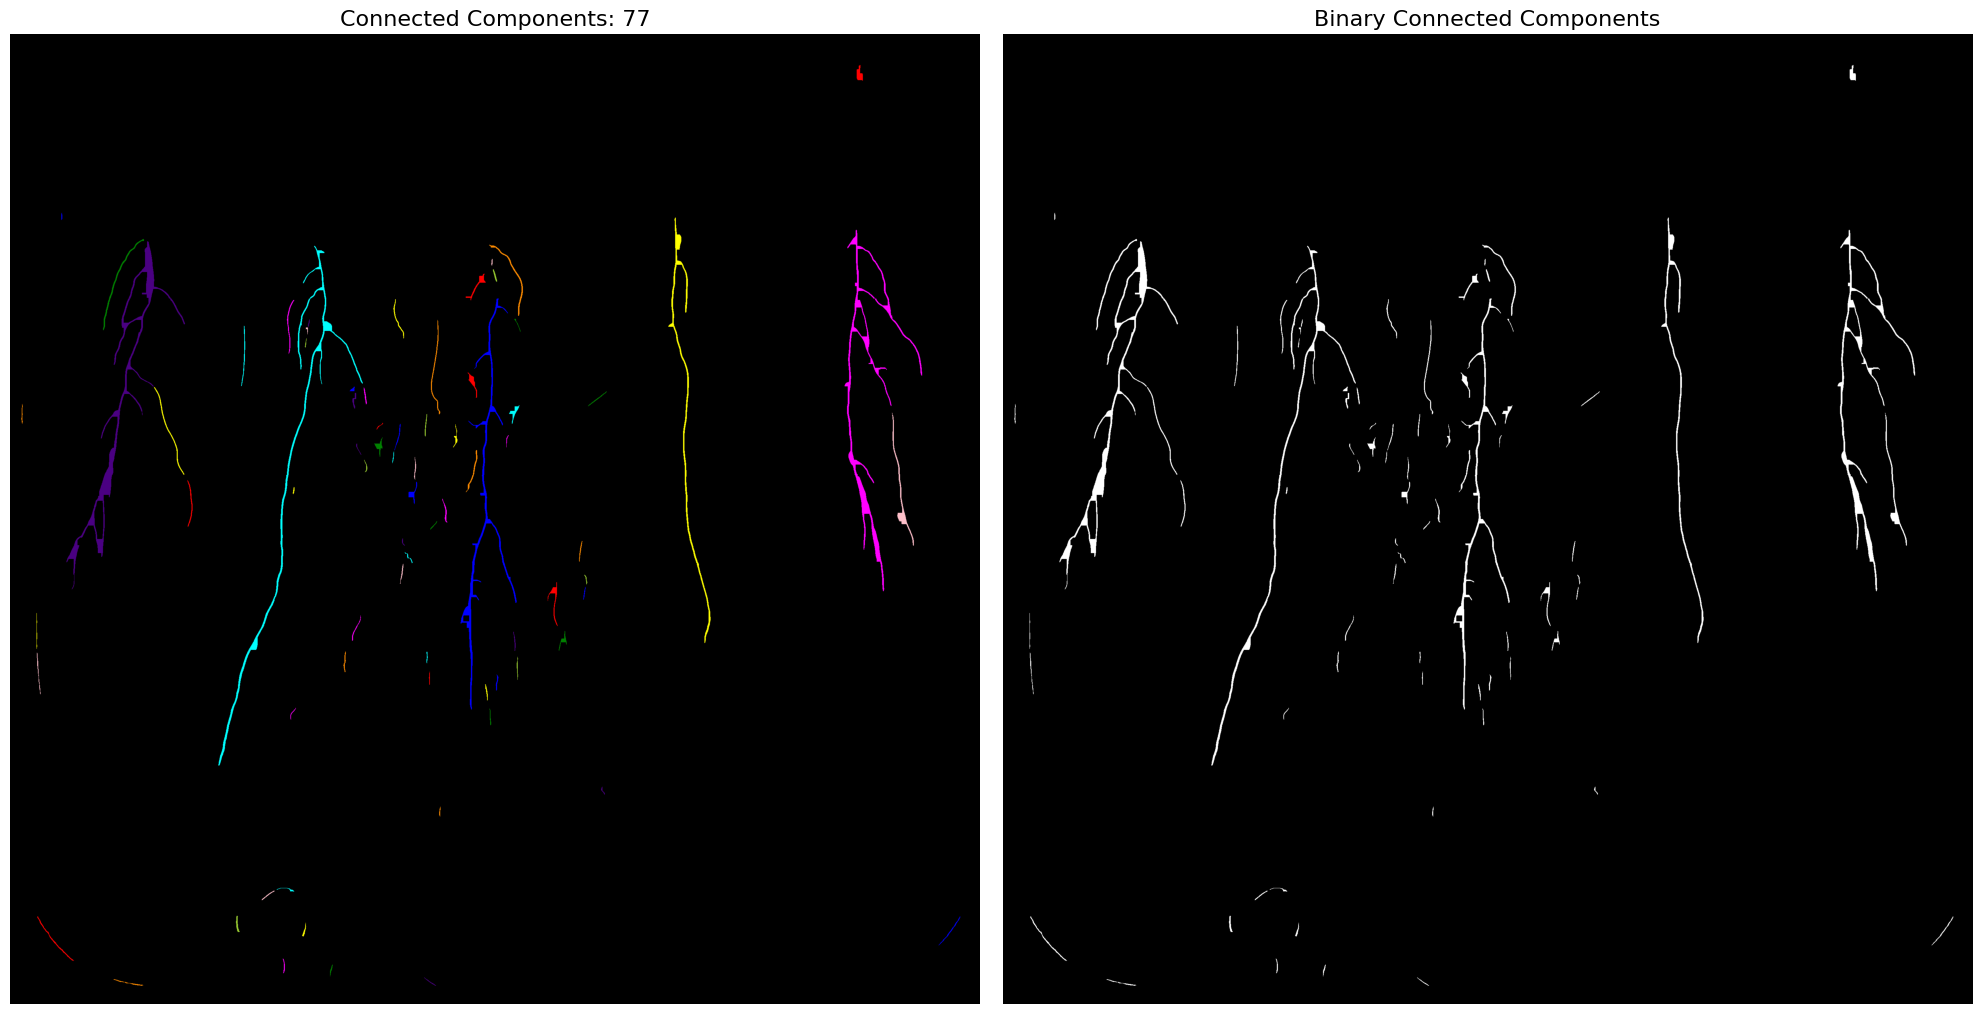

Filename: test_image_11.png | Number of connected components: 88


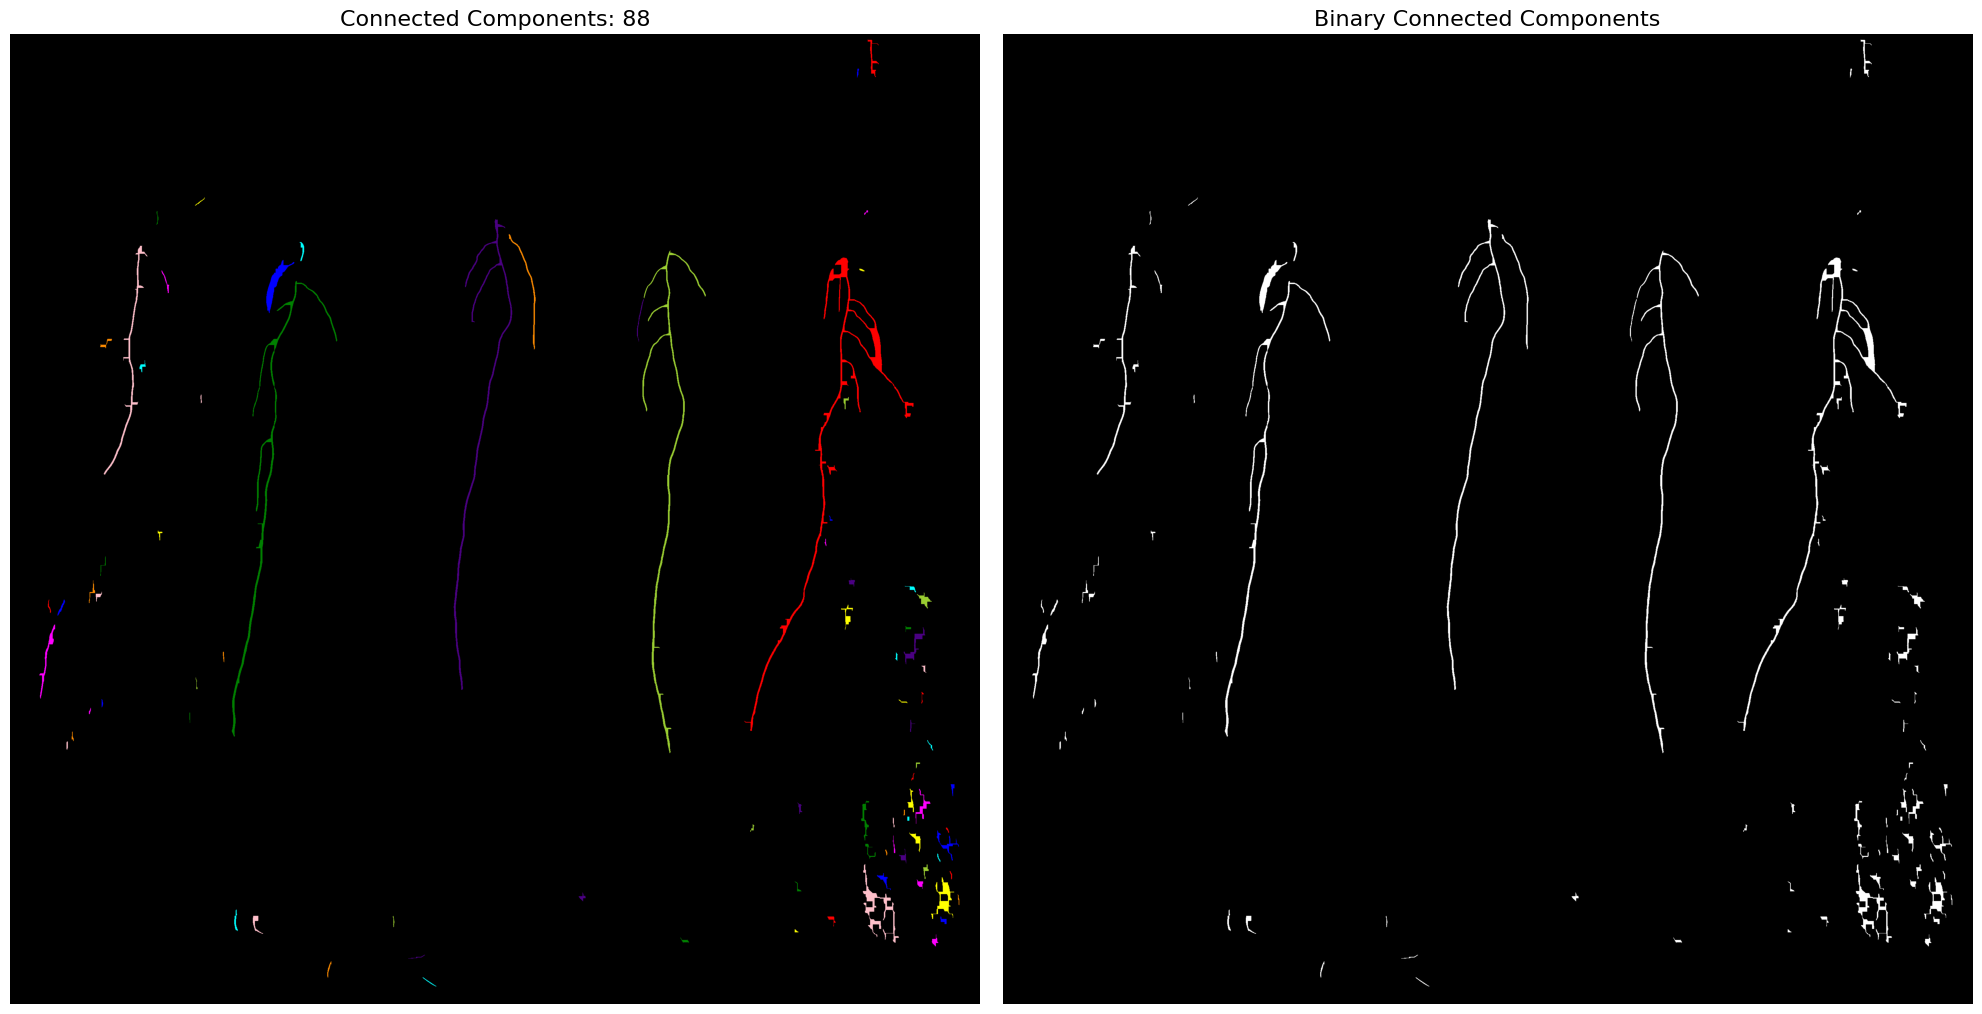

Filename: test_image_12.png | Number of connected components: 41


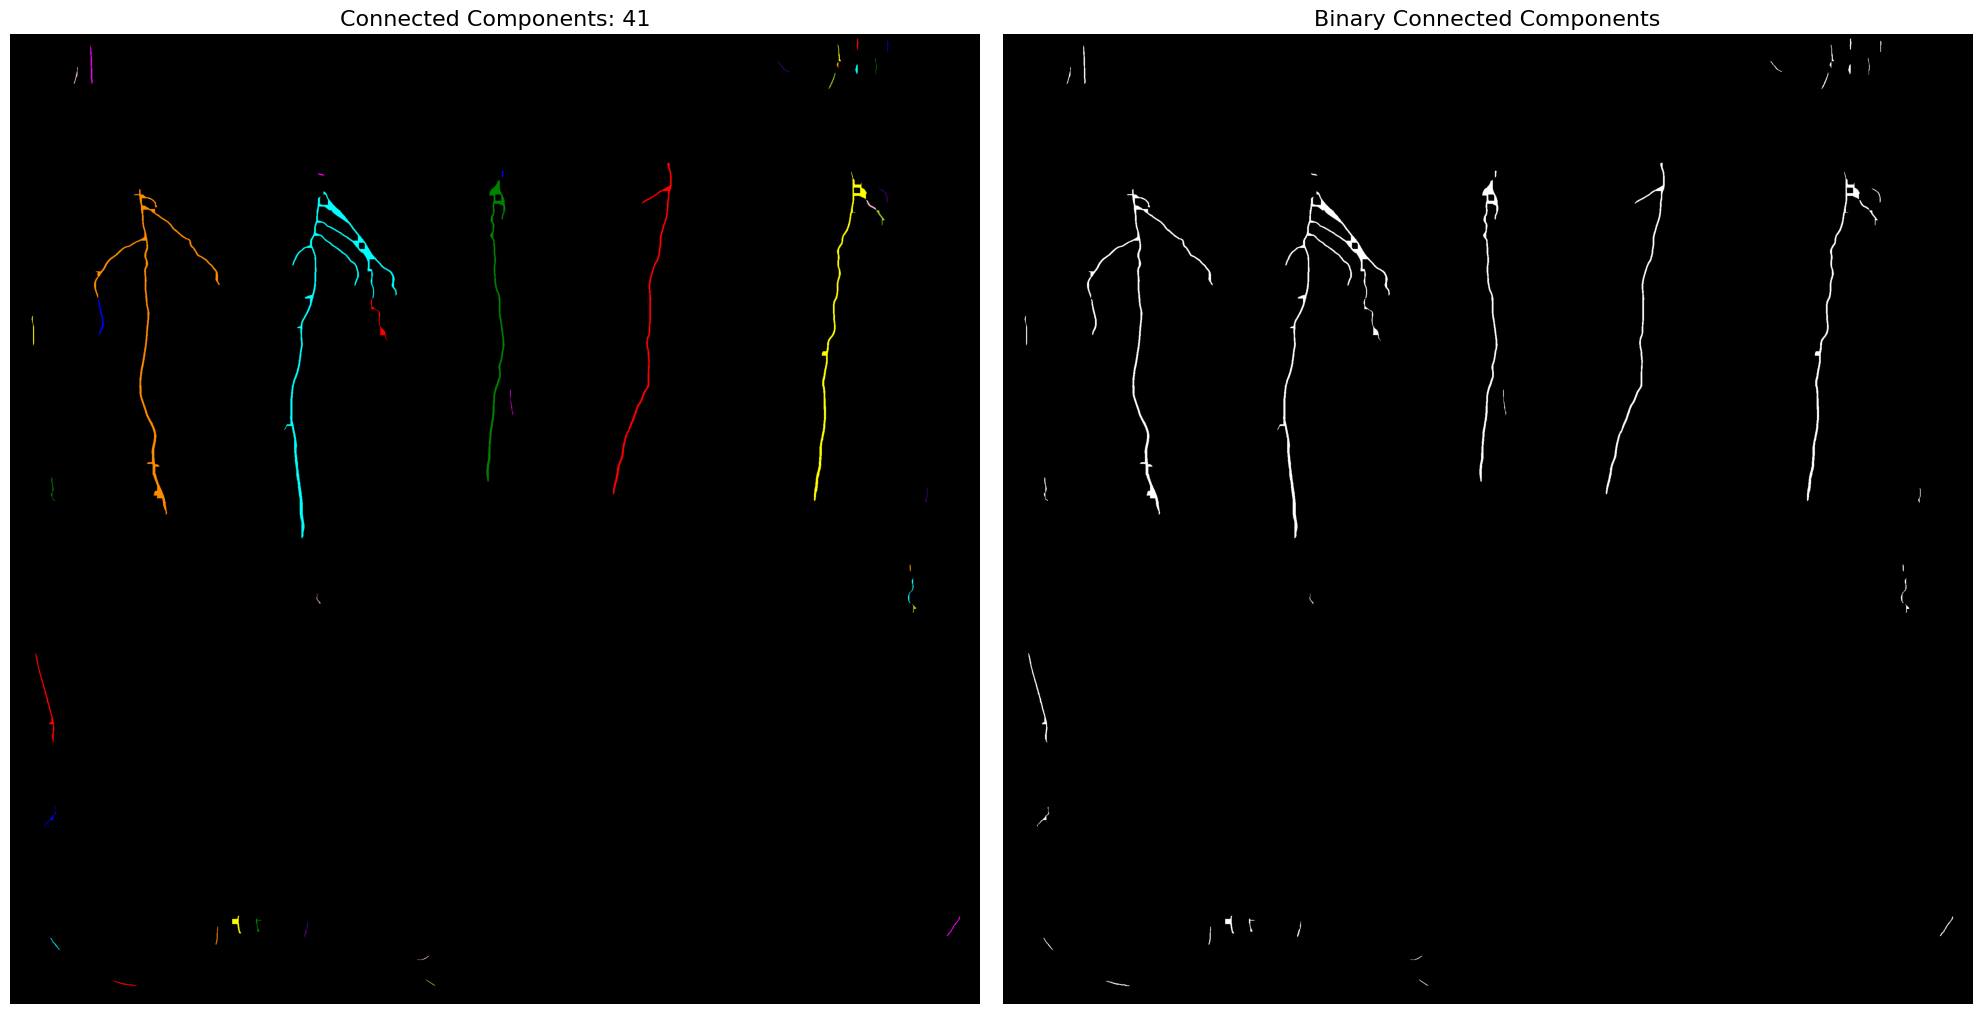

Filename: test_image_13.png | Number of connected components: 23


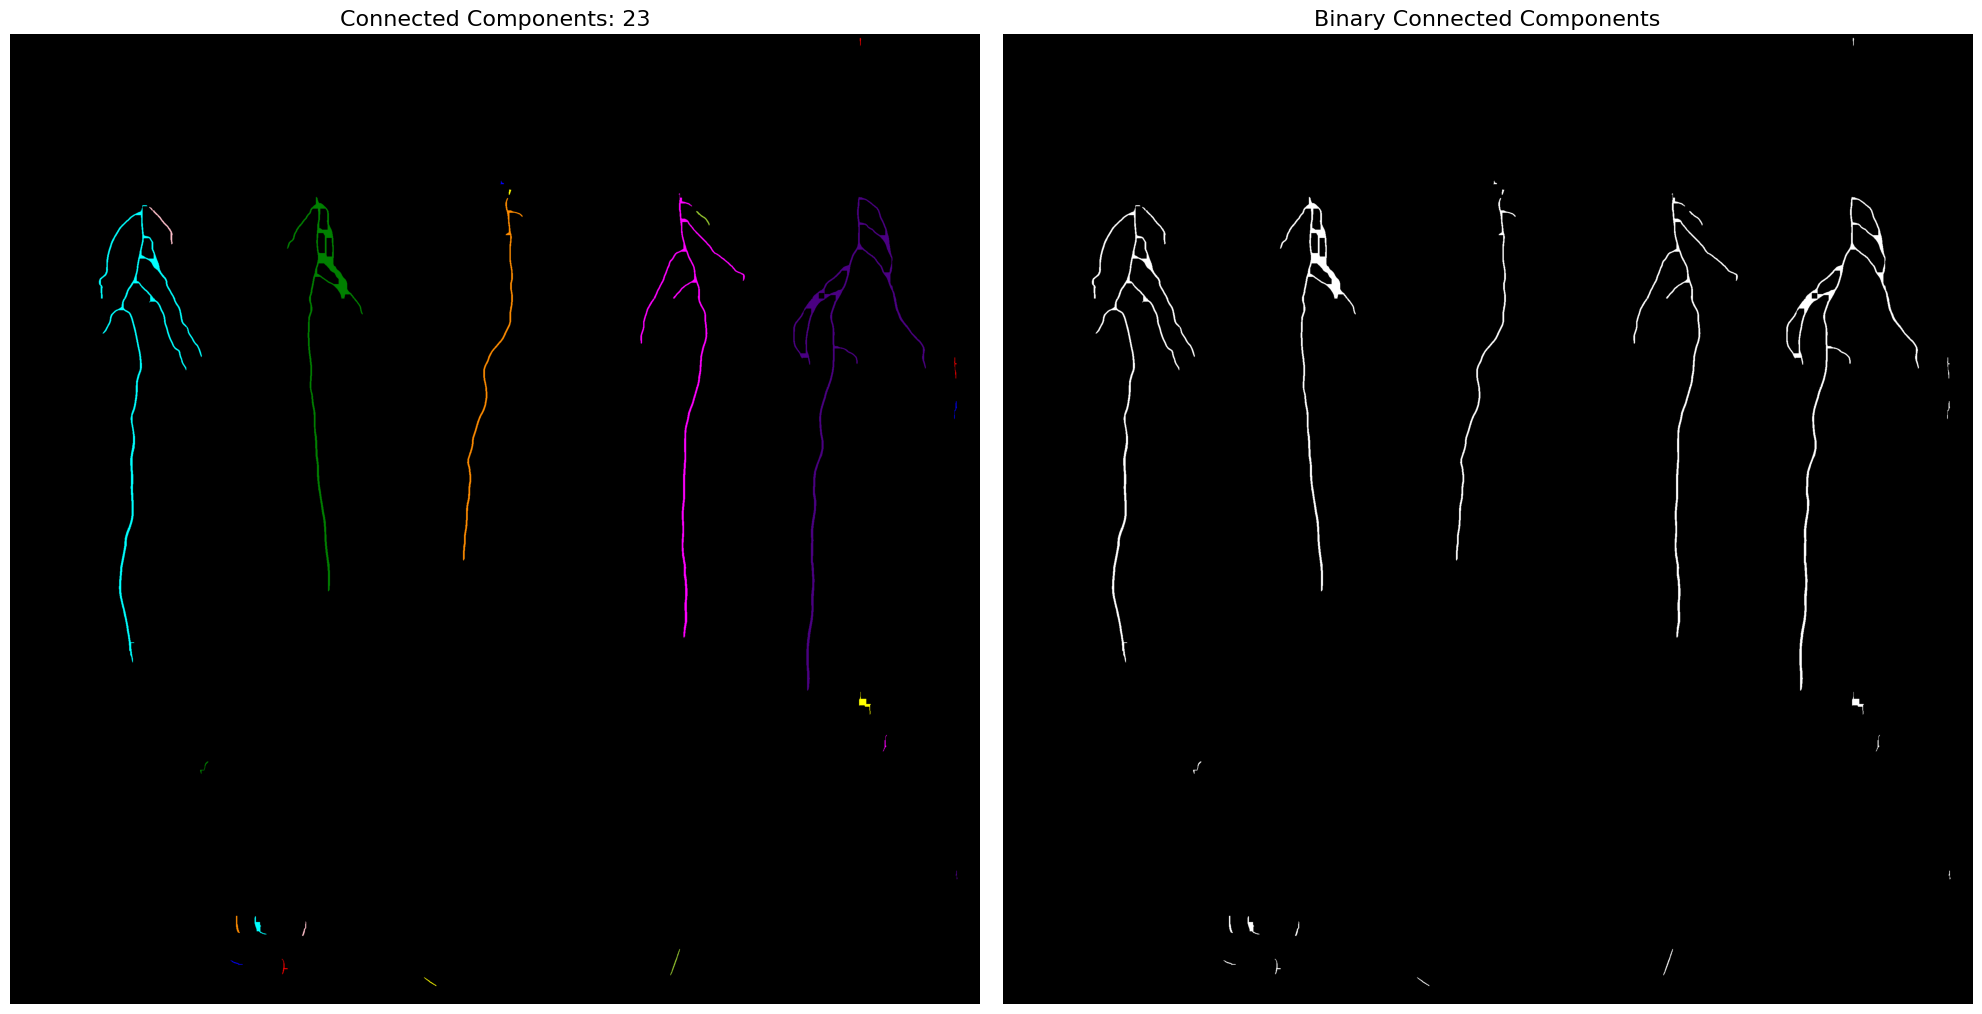

Filename: test_image_14.png | Number of connected components: 69


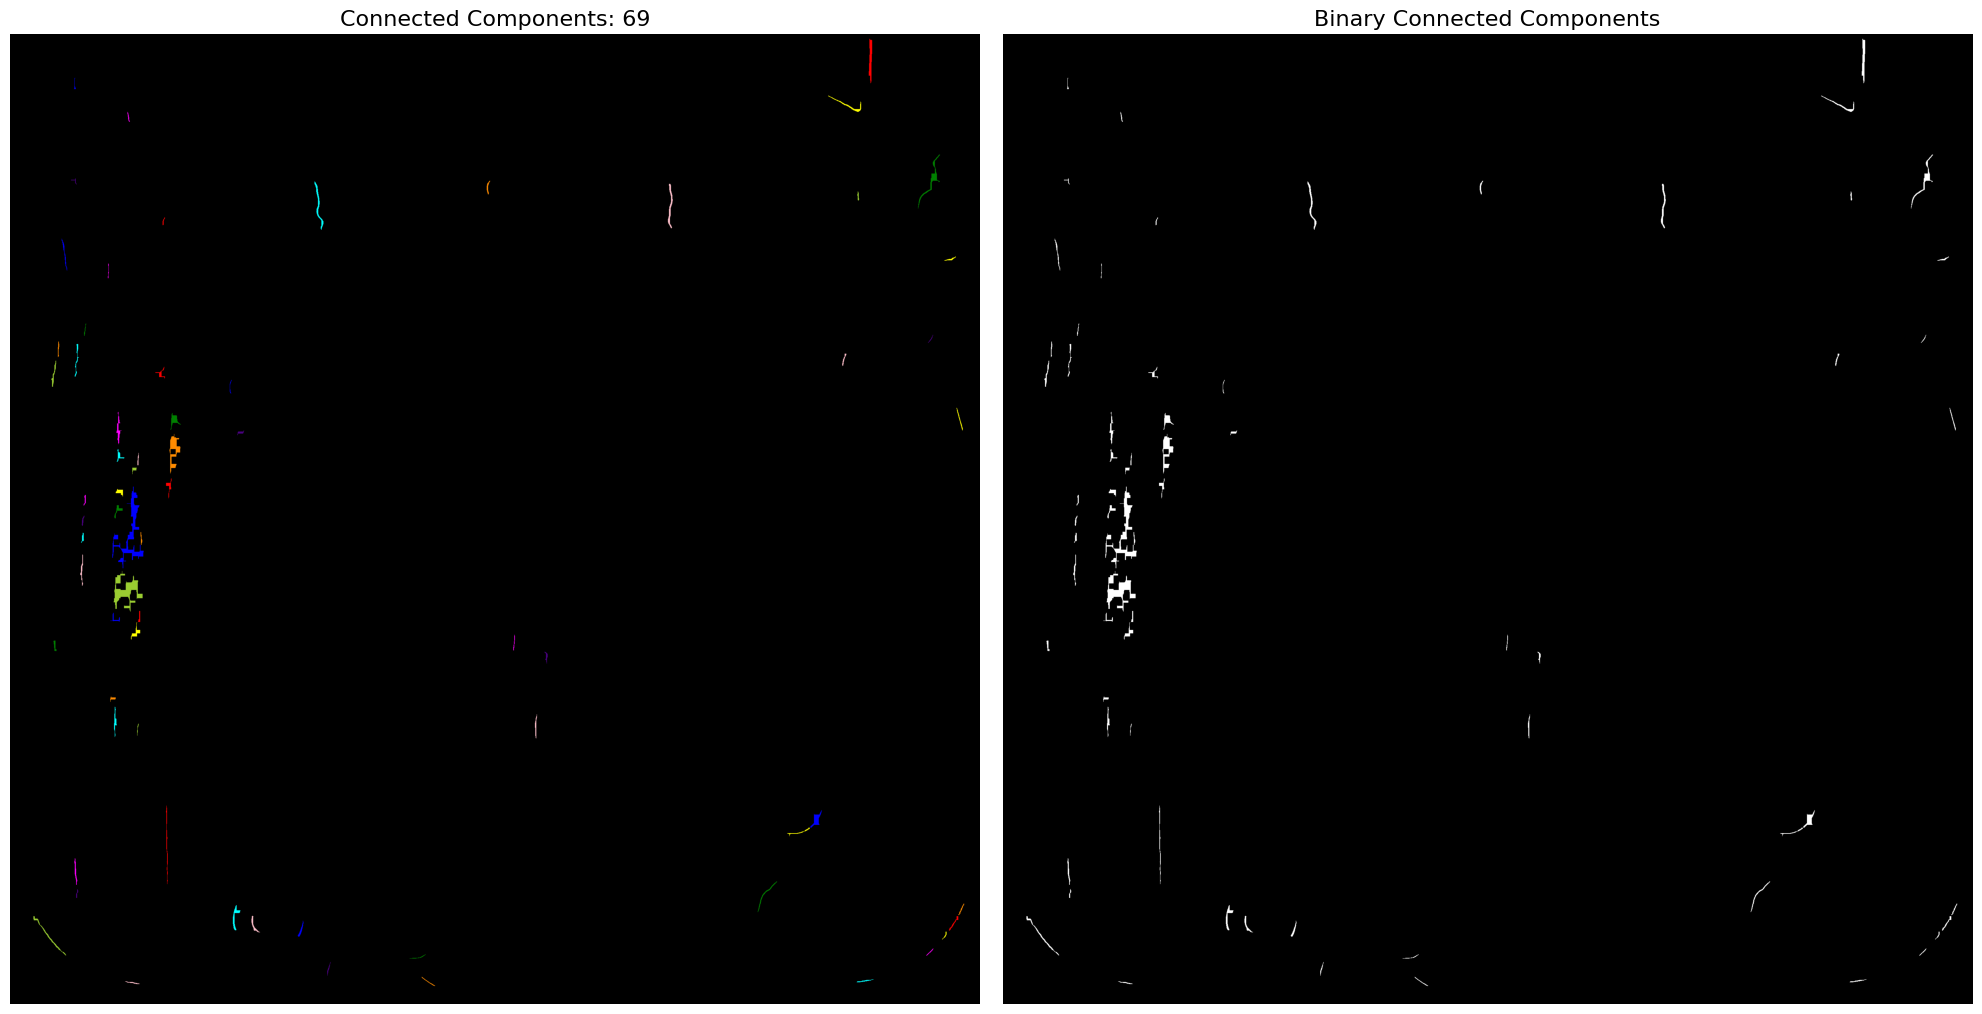

Filename: test_image_15.png | Number of connected components: 96


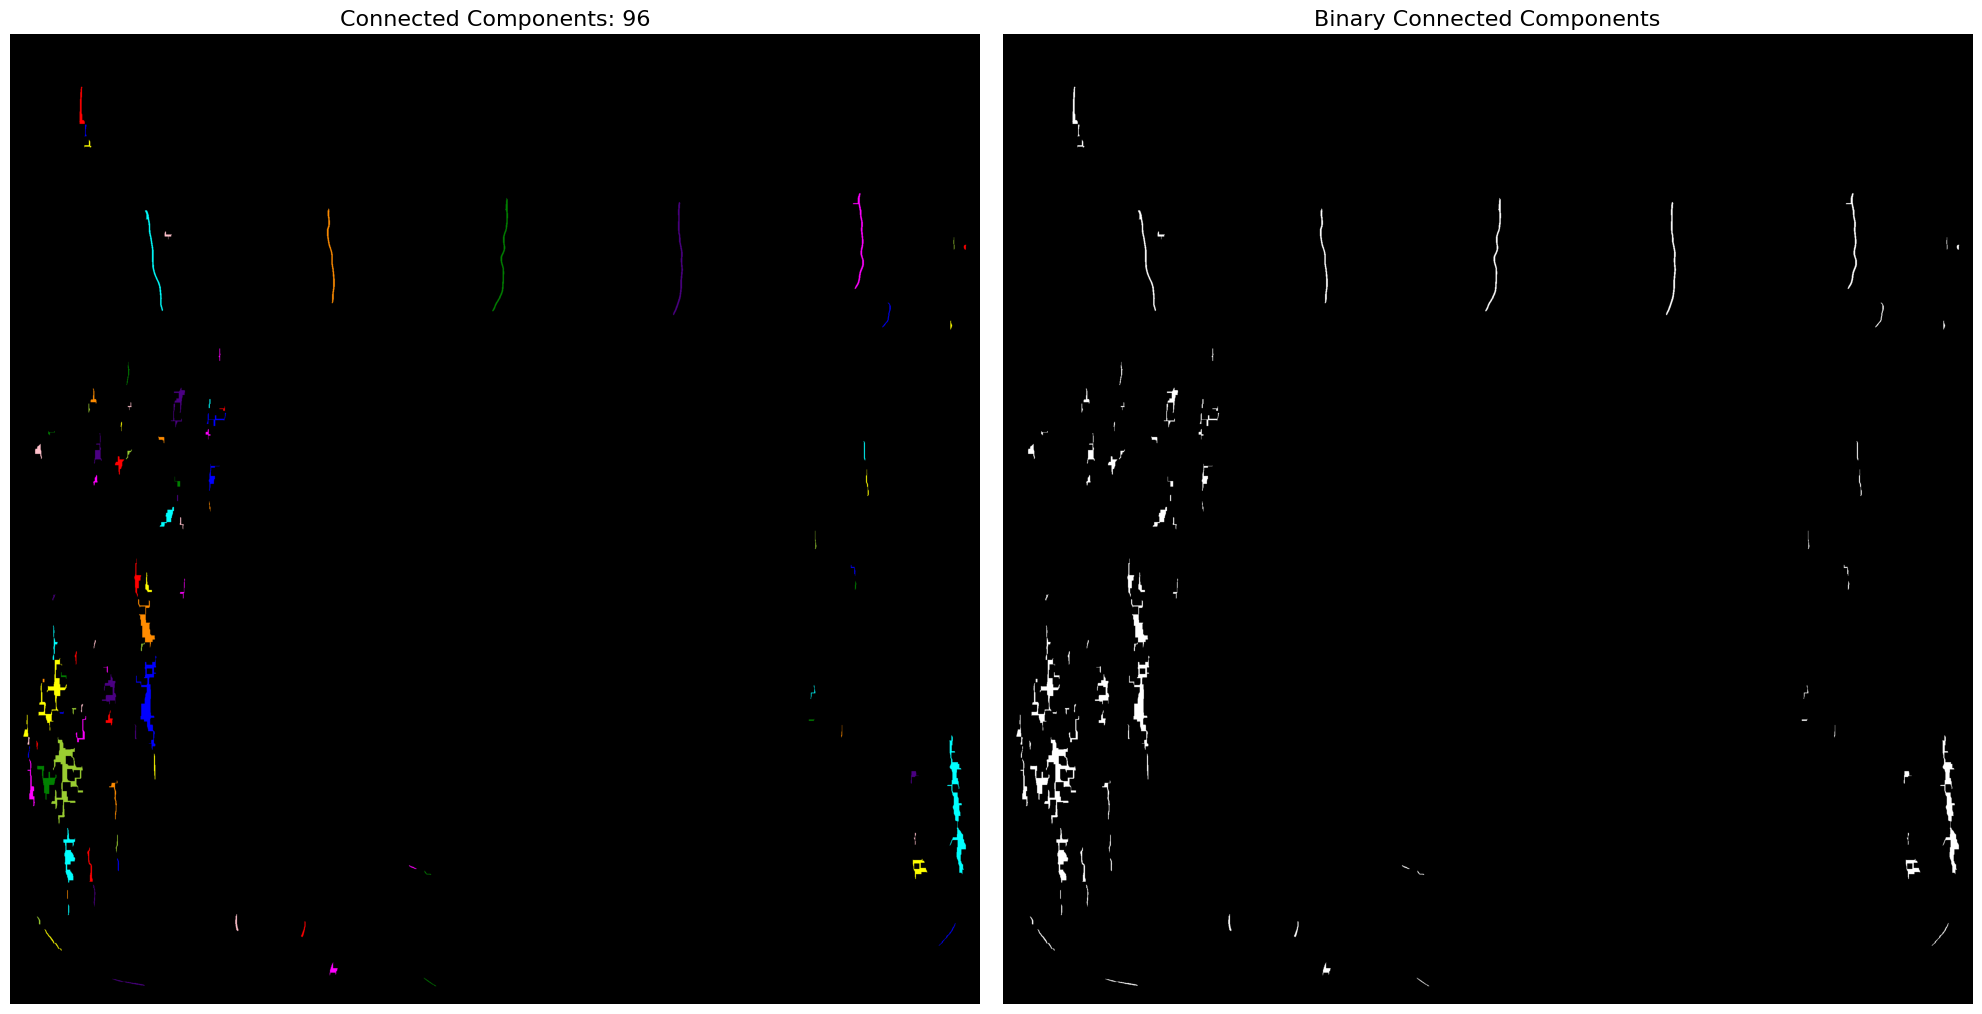

Filename: test_image_16.png | Number of connected components: 48


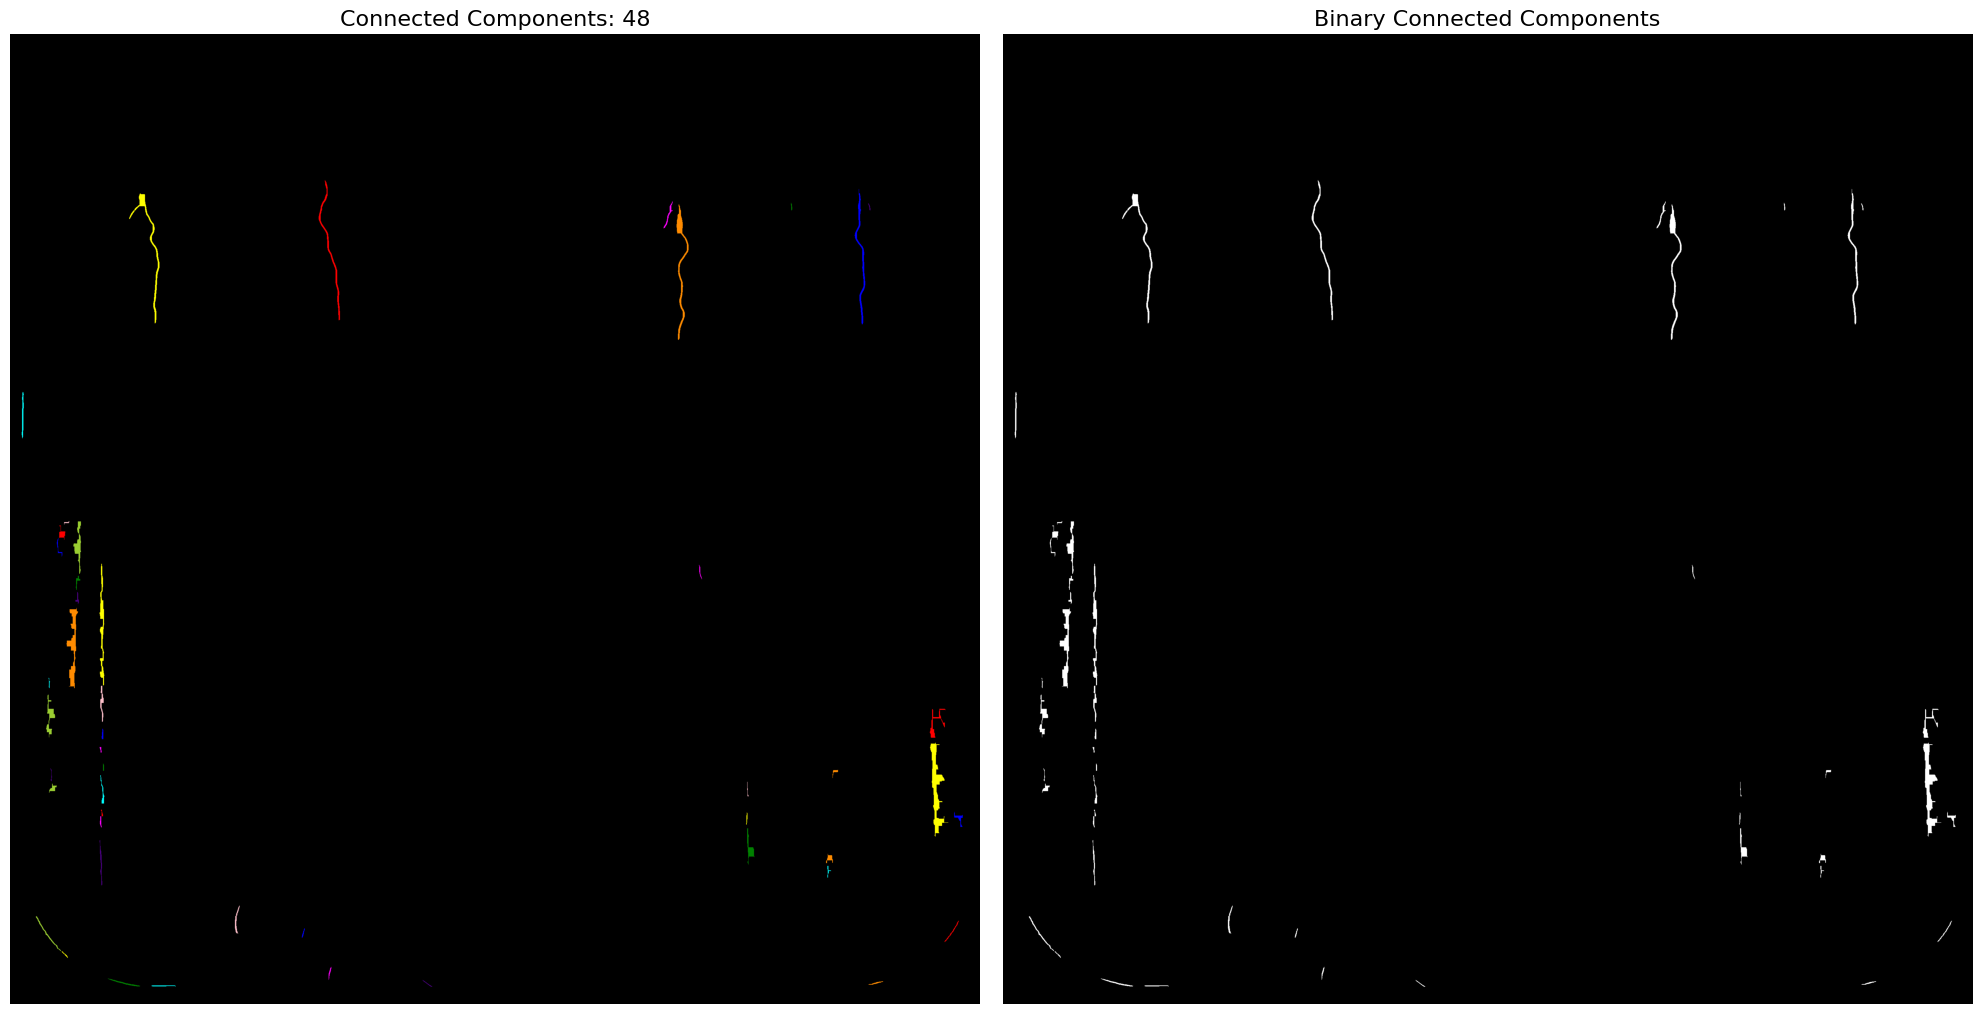

Filename: test_image_17.png | Number of connected components: 15


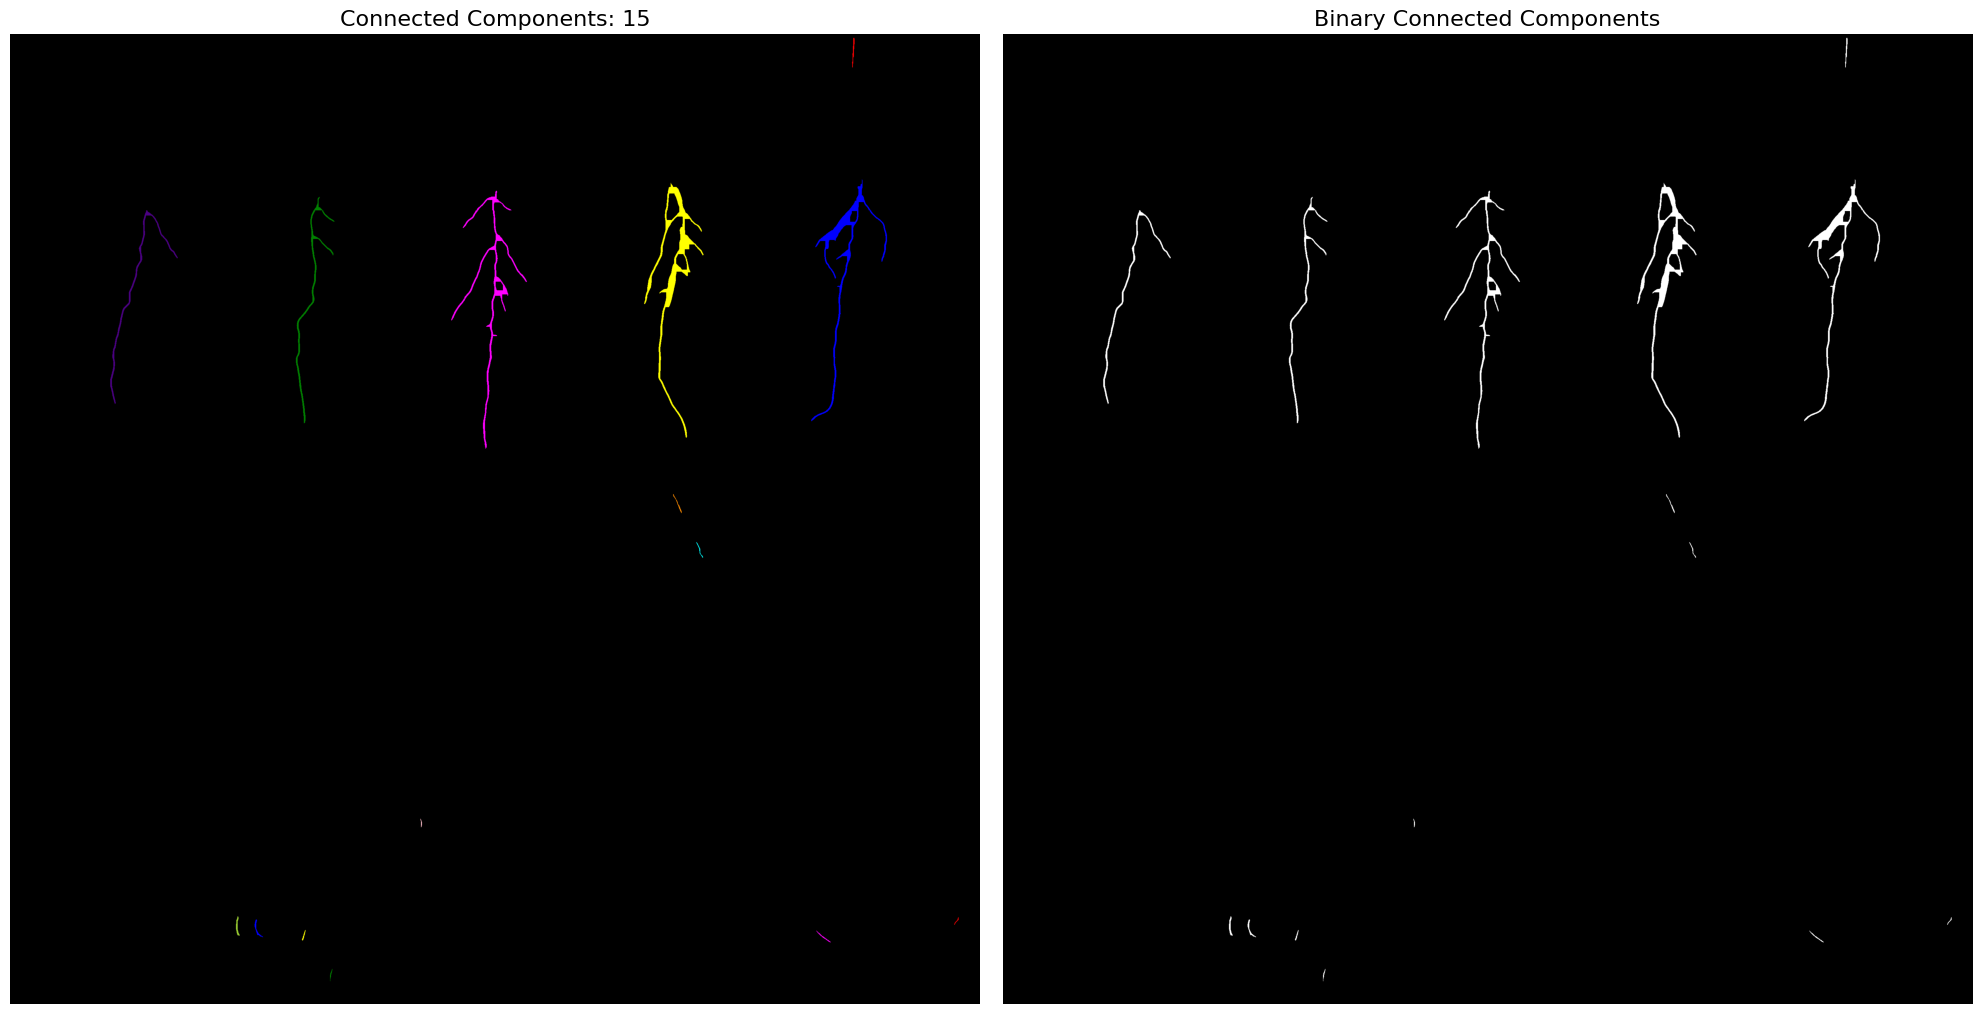

Filename: test_image_18.png | Number of connected components: 53


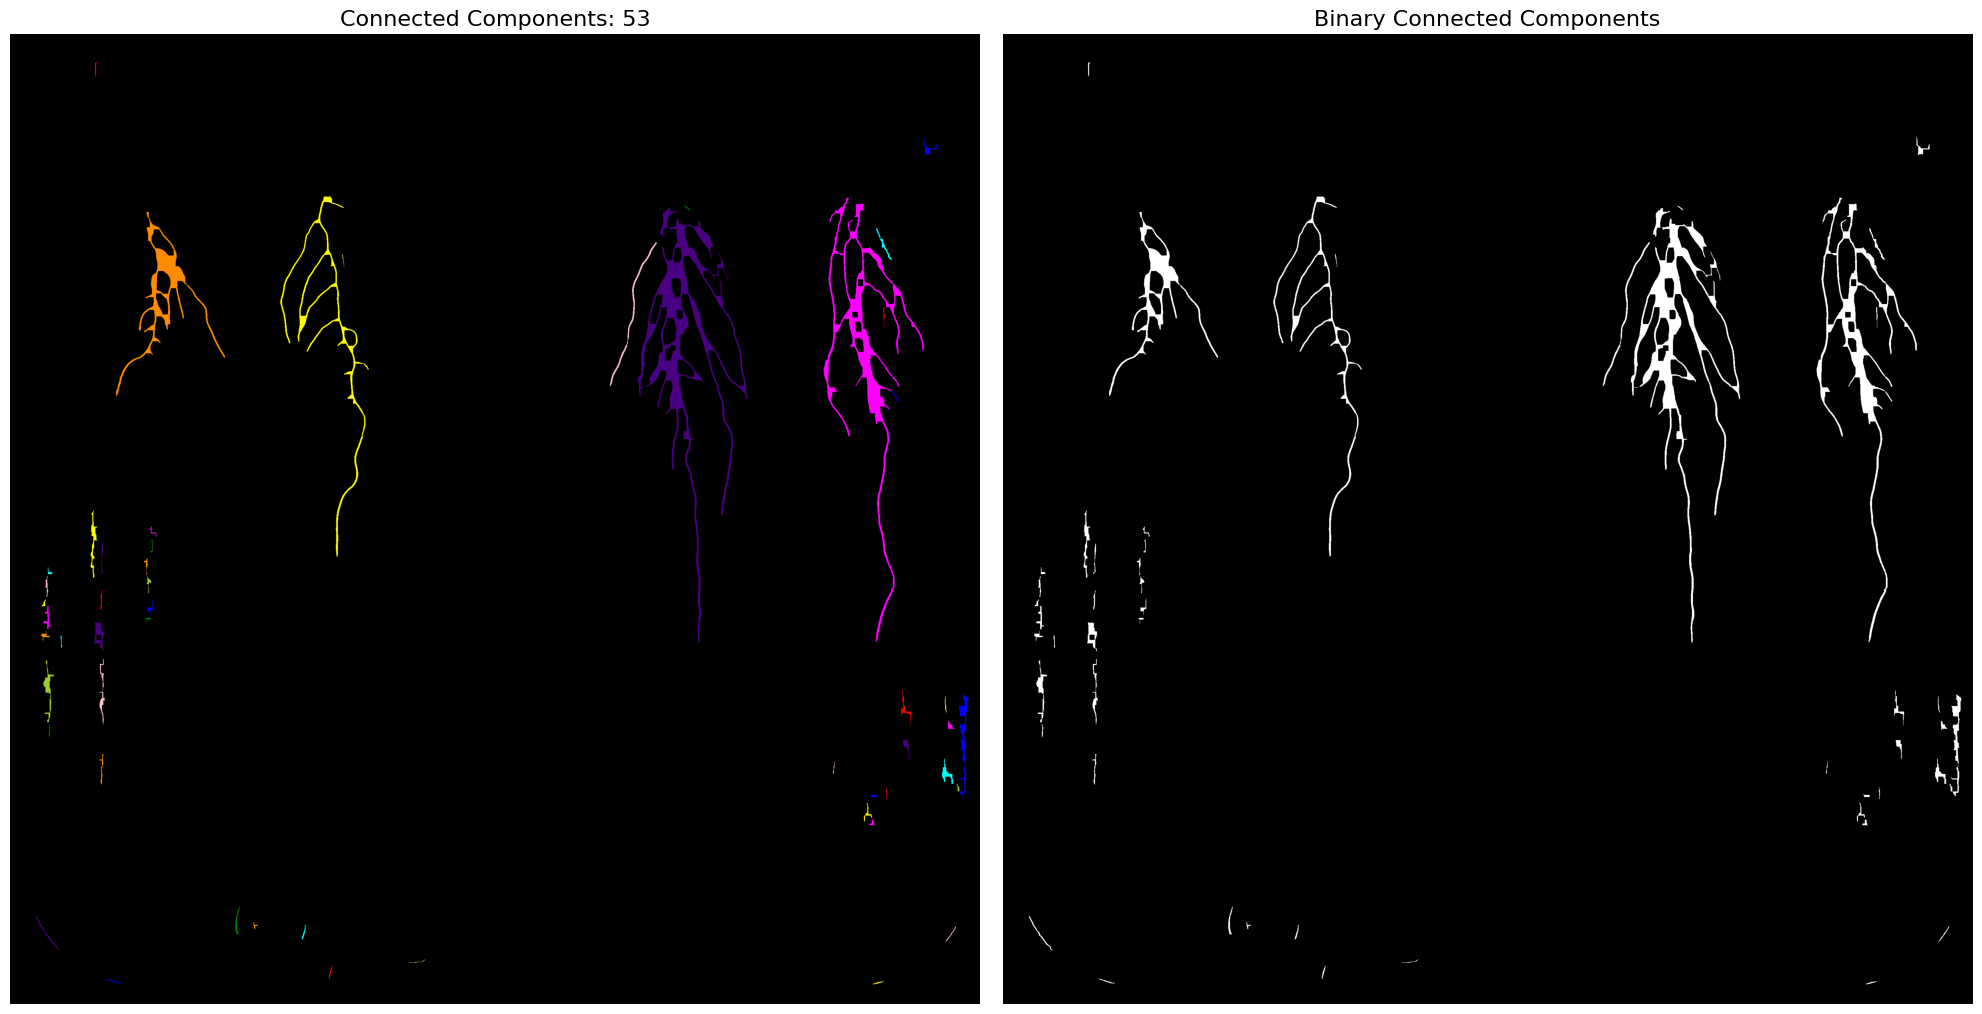

Filename: test_image_2.png | Number of connected components: 18


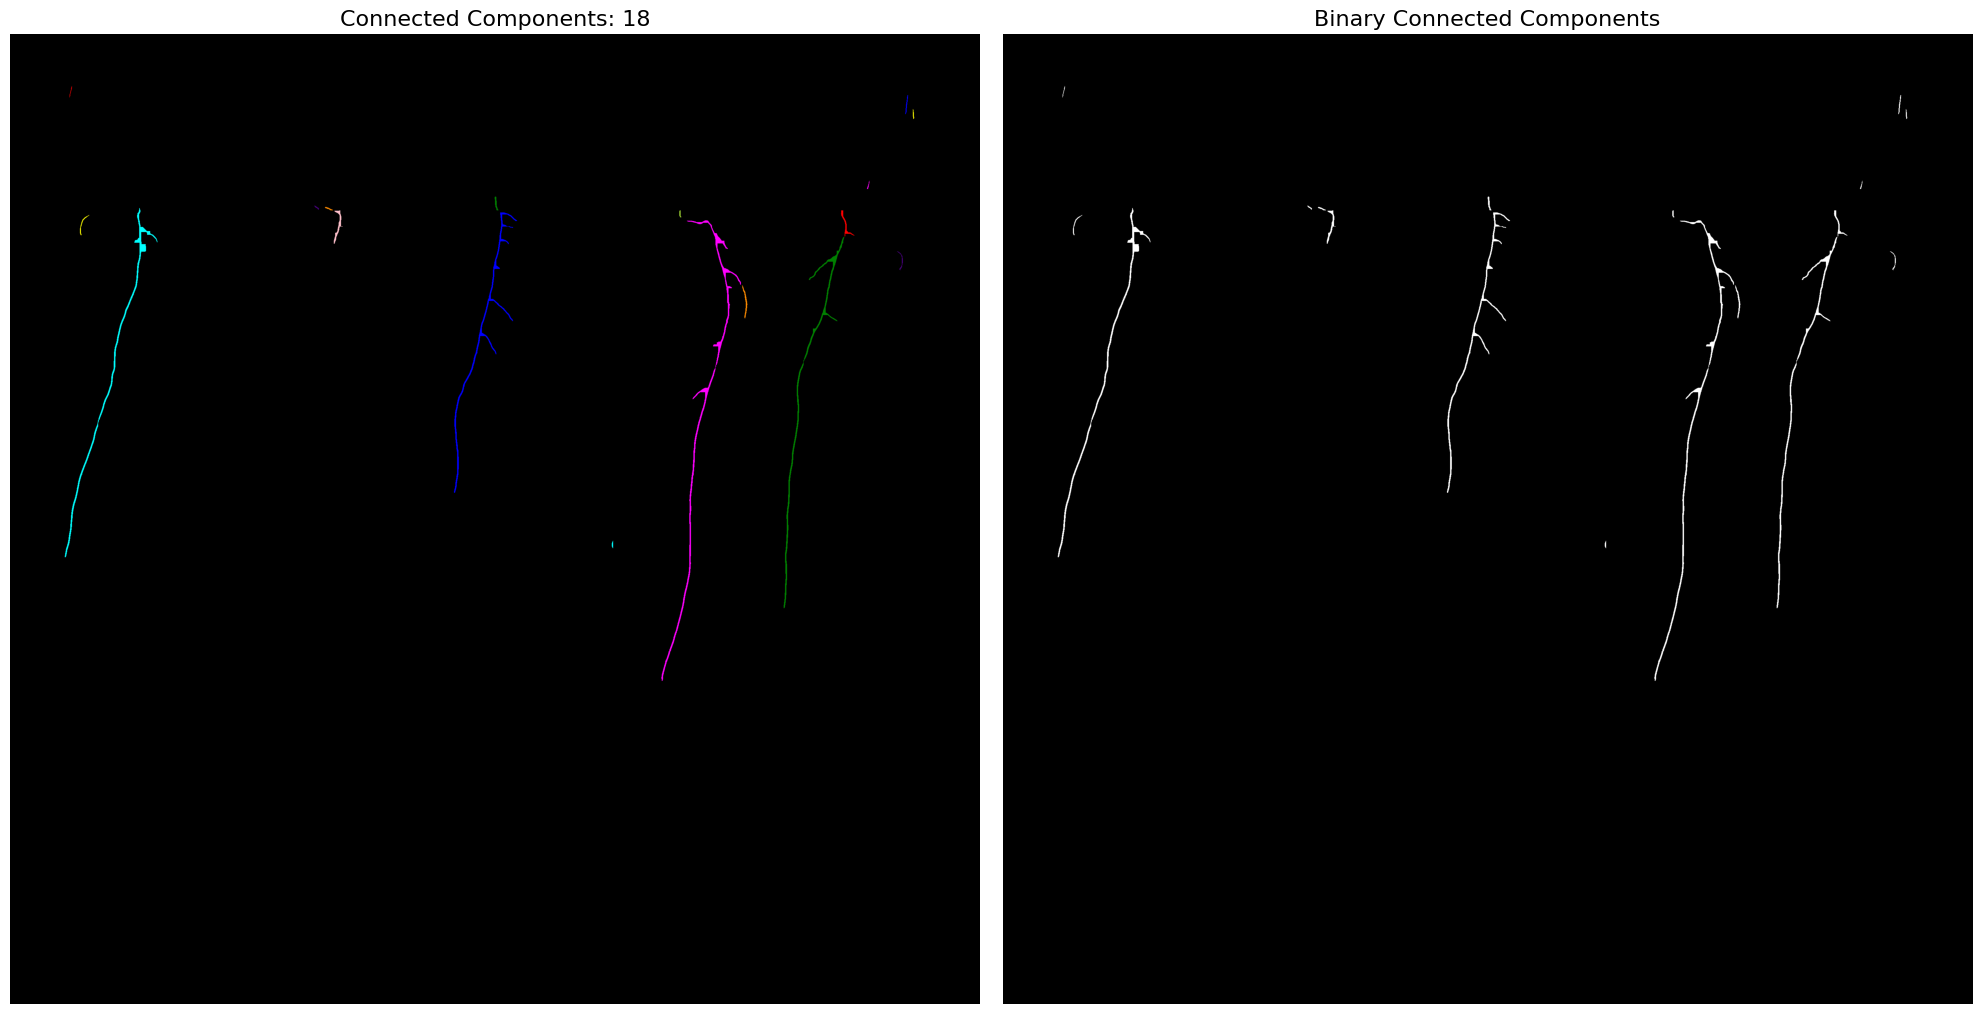

Filename: test_image_3.png | Number of connected components: 7


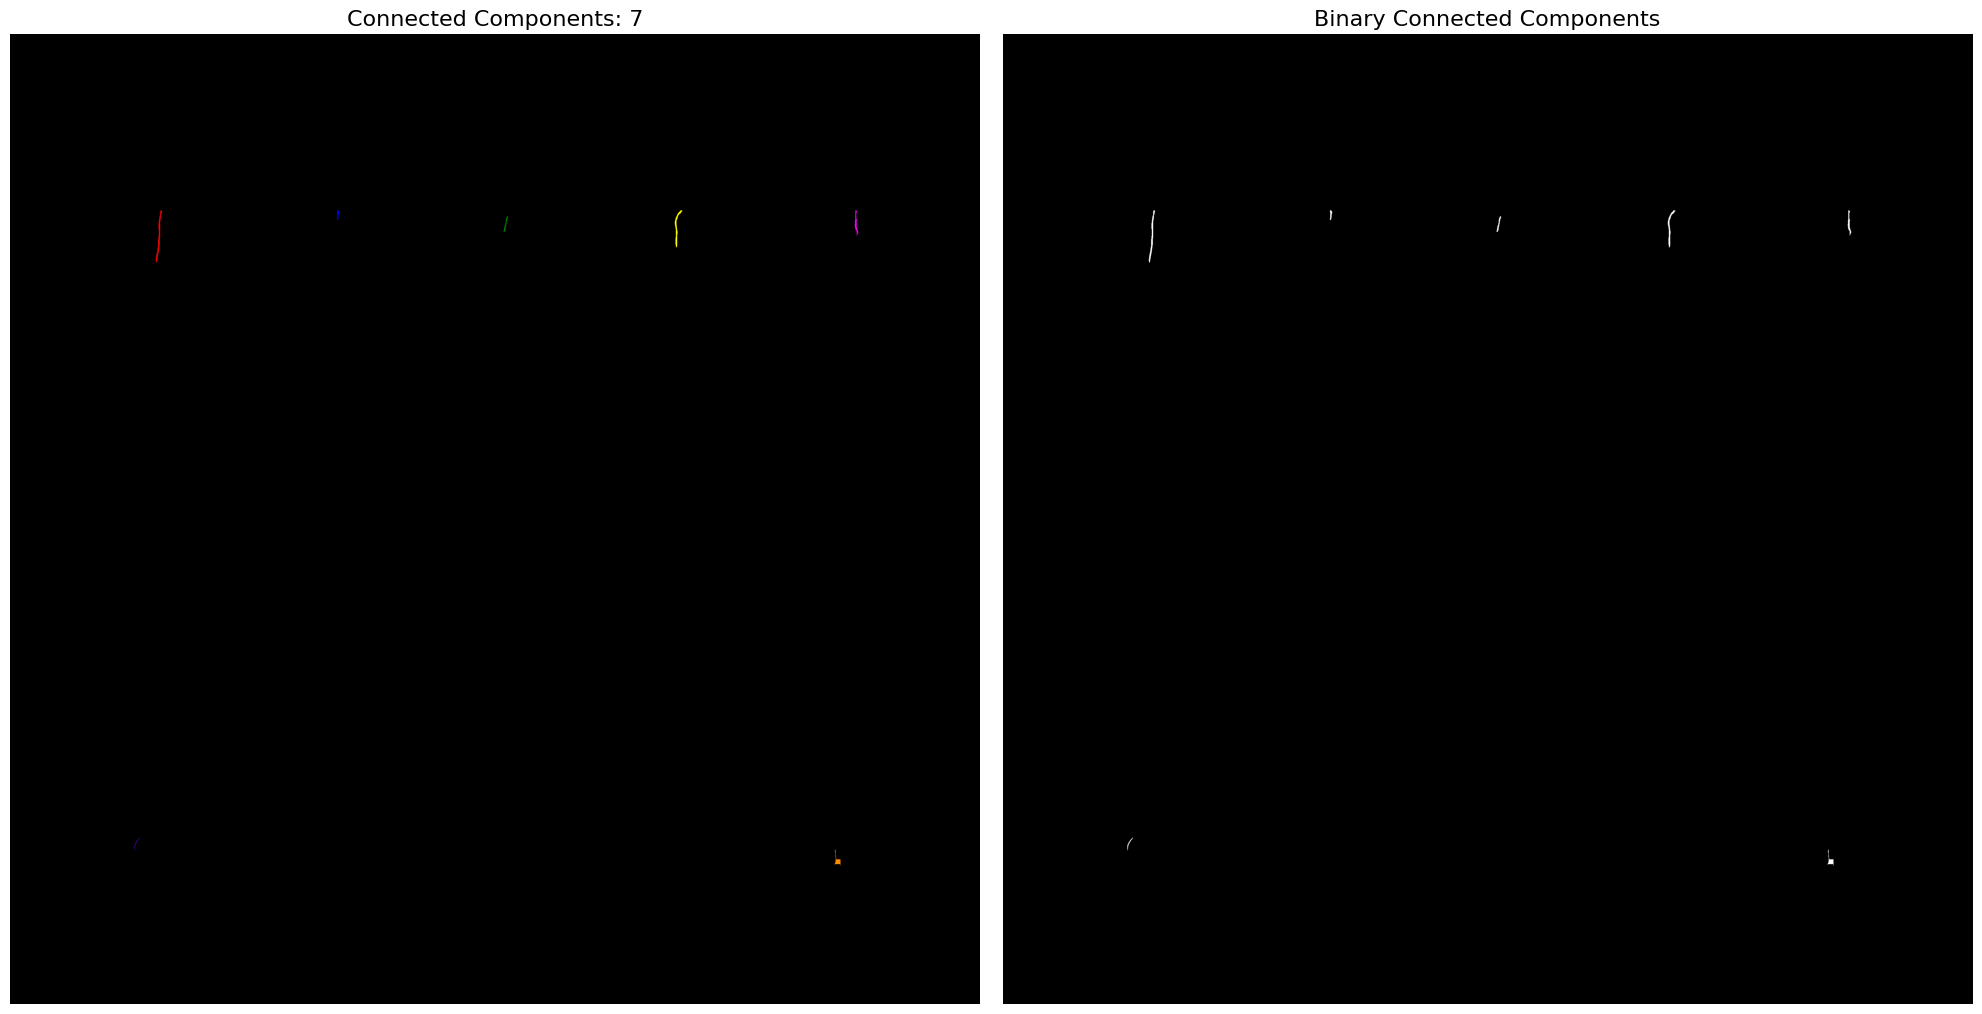

Filename: test_image_4.png | Number of connected components: 8


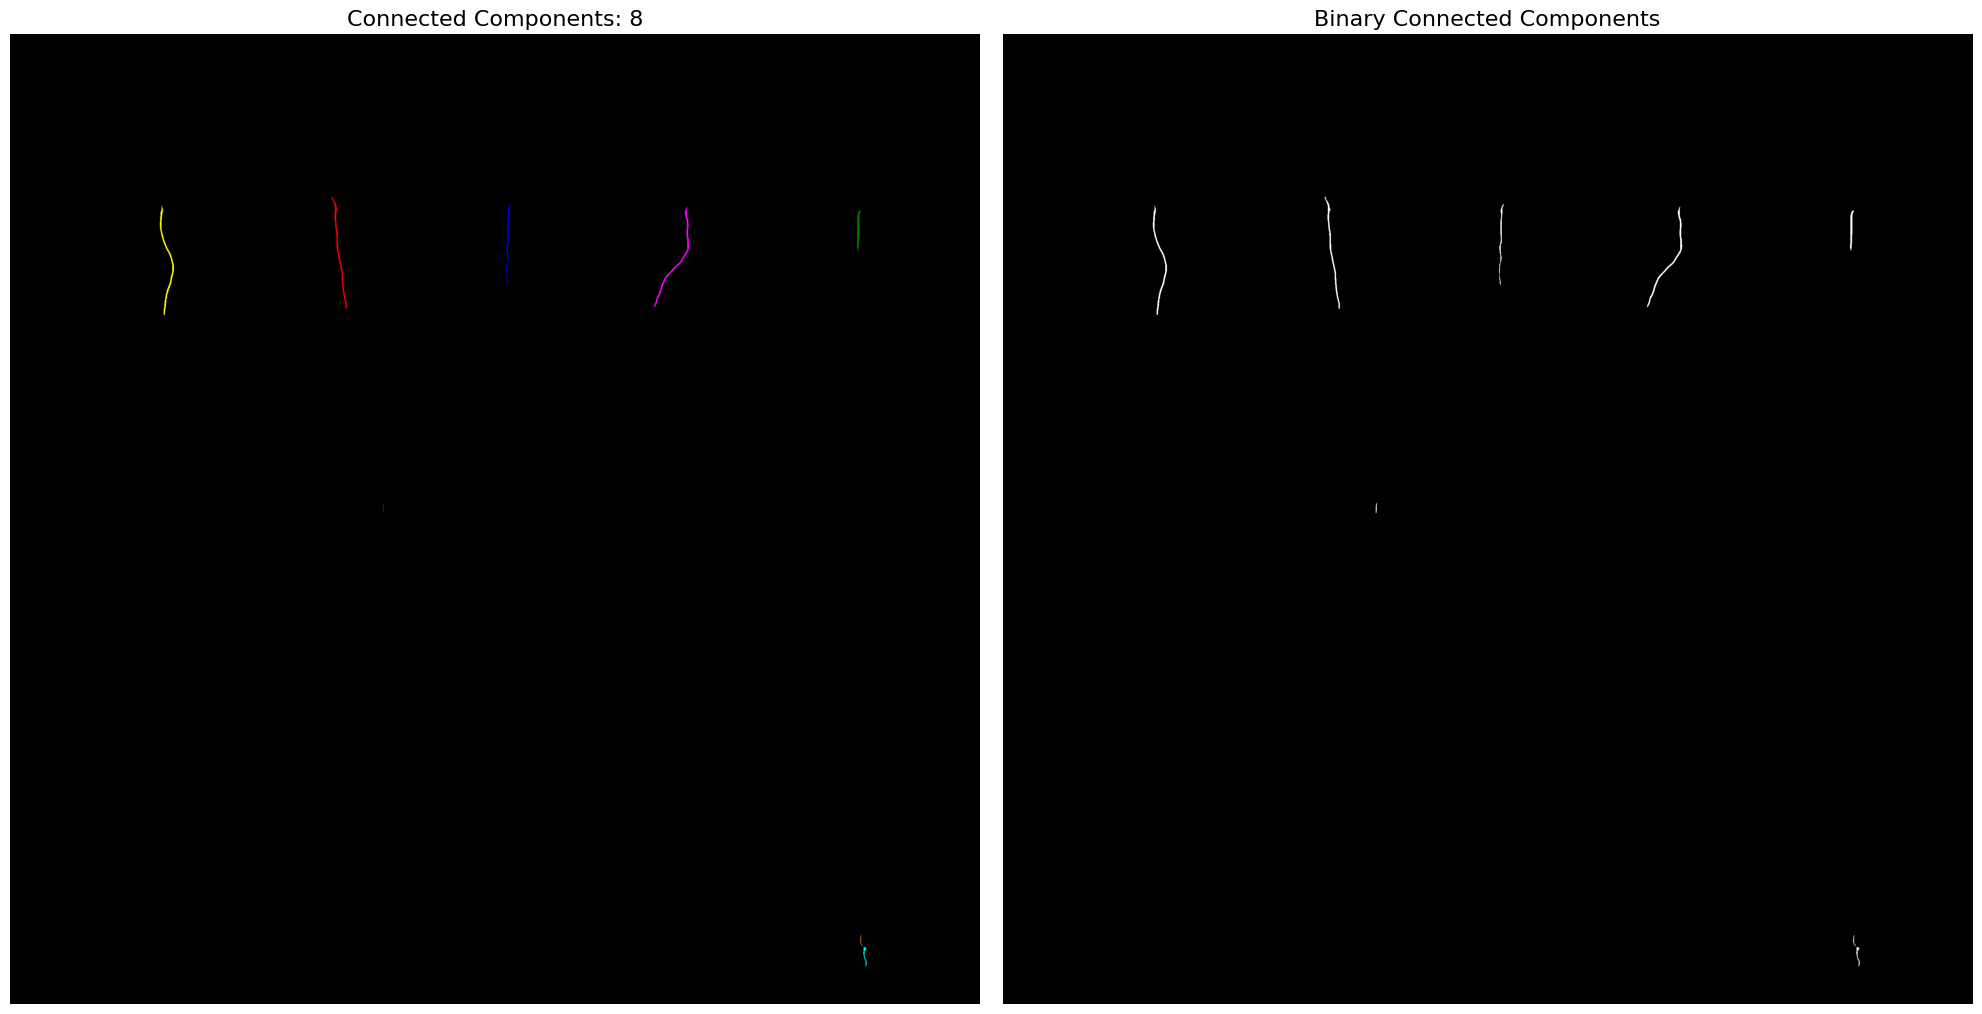

Filename: test_image_5.png | Number of connected components: 7


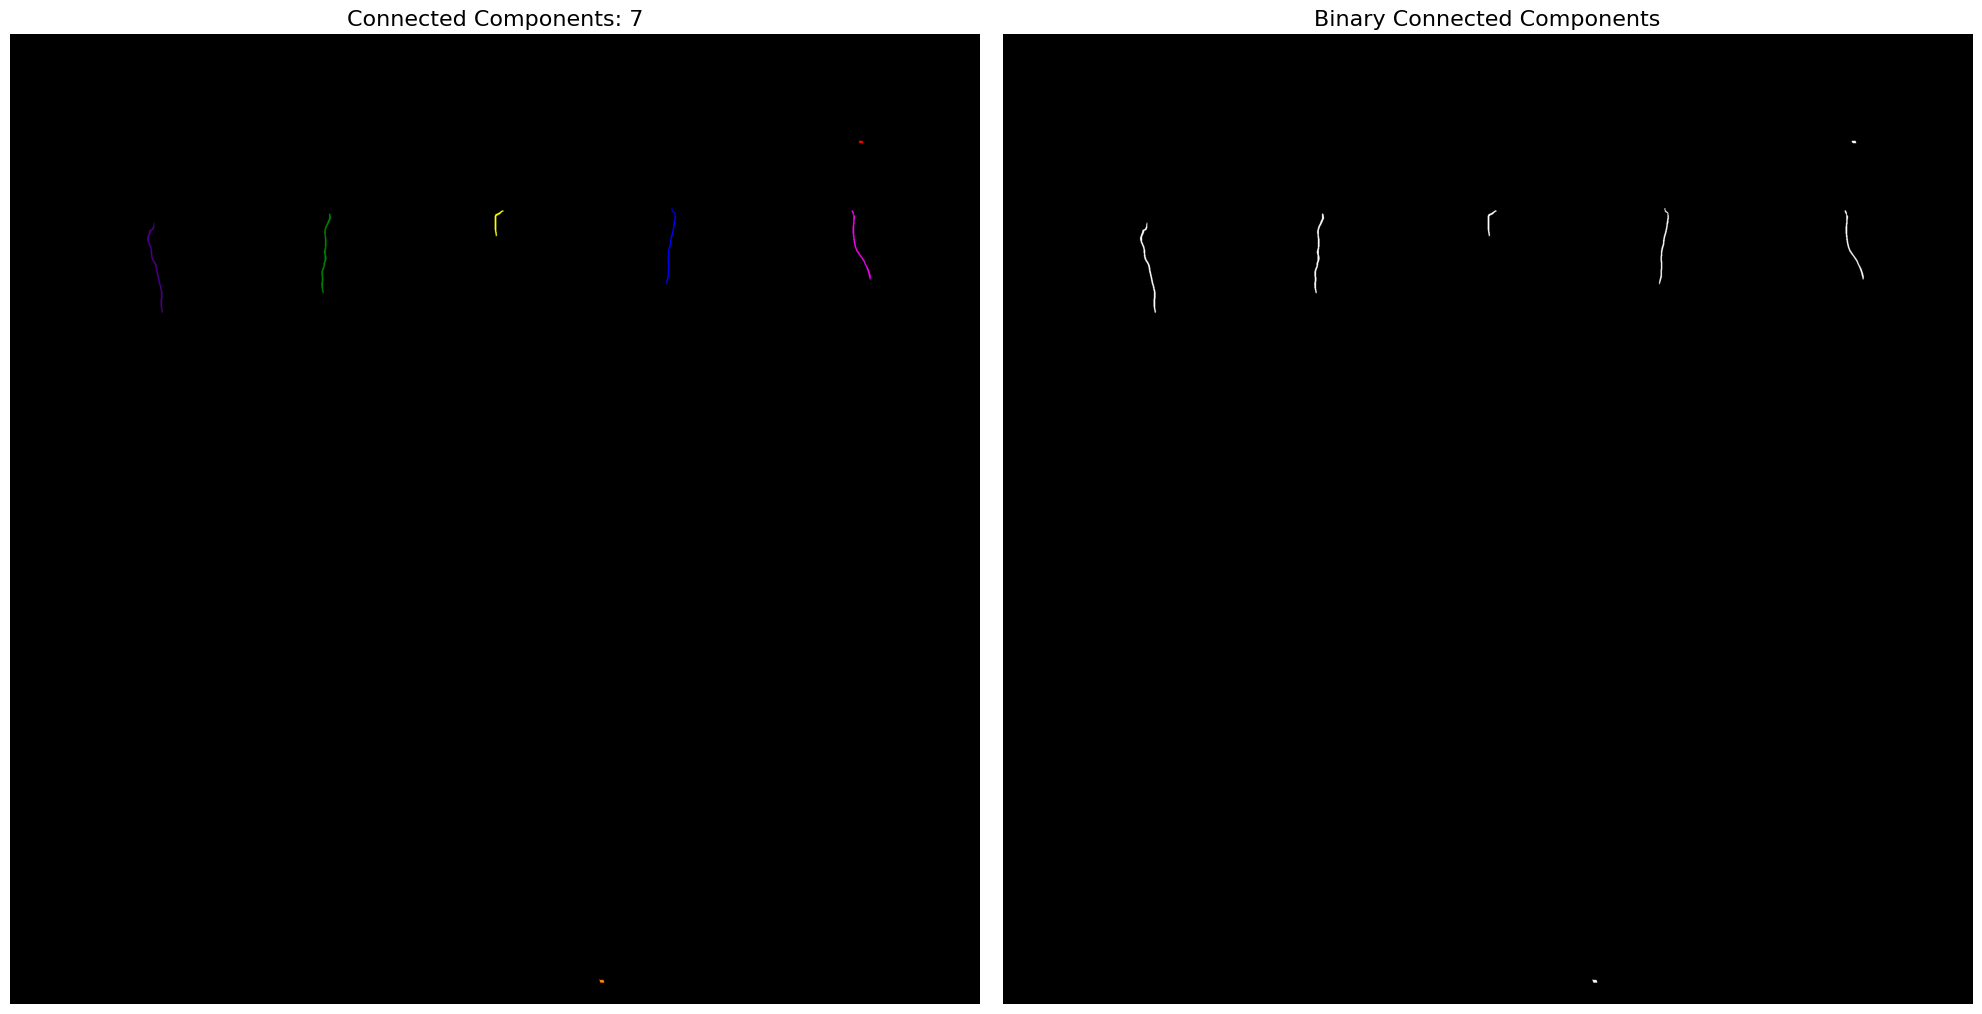

Filename: test_image_6.png | Number of connected components: 10


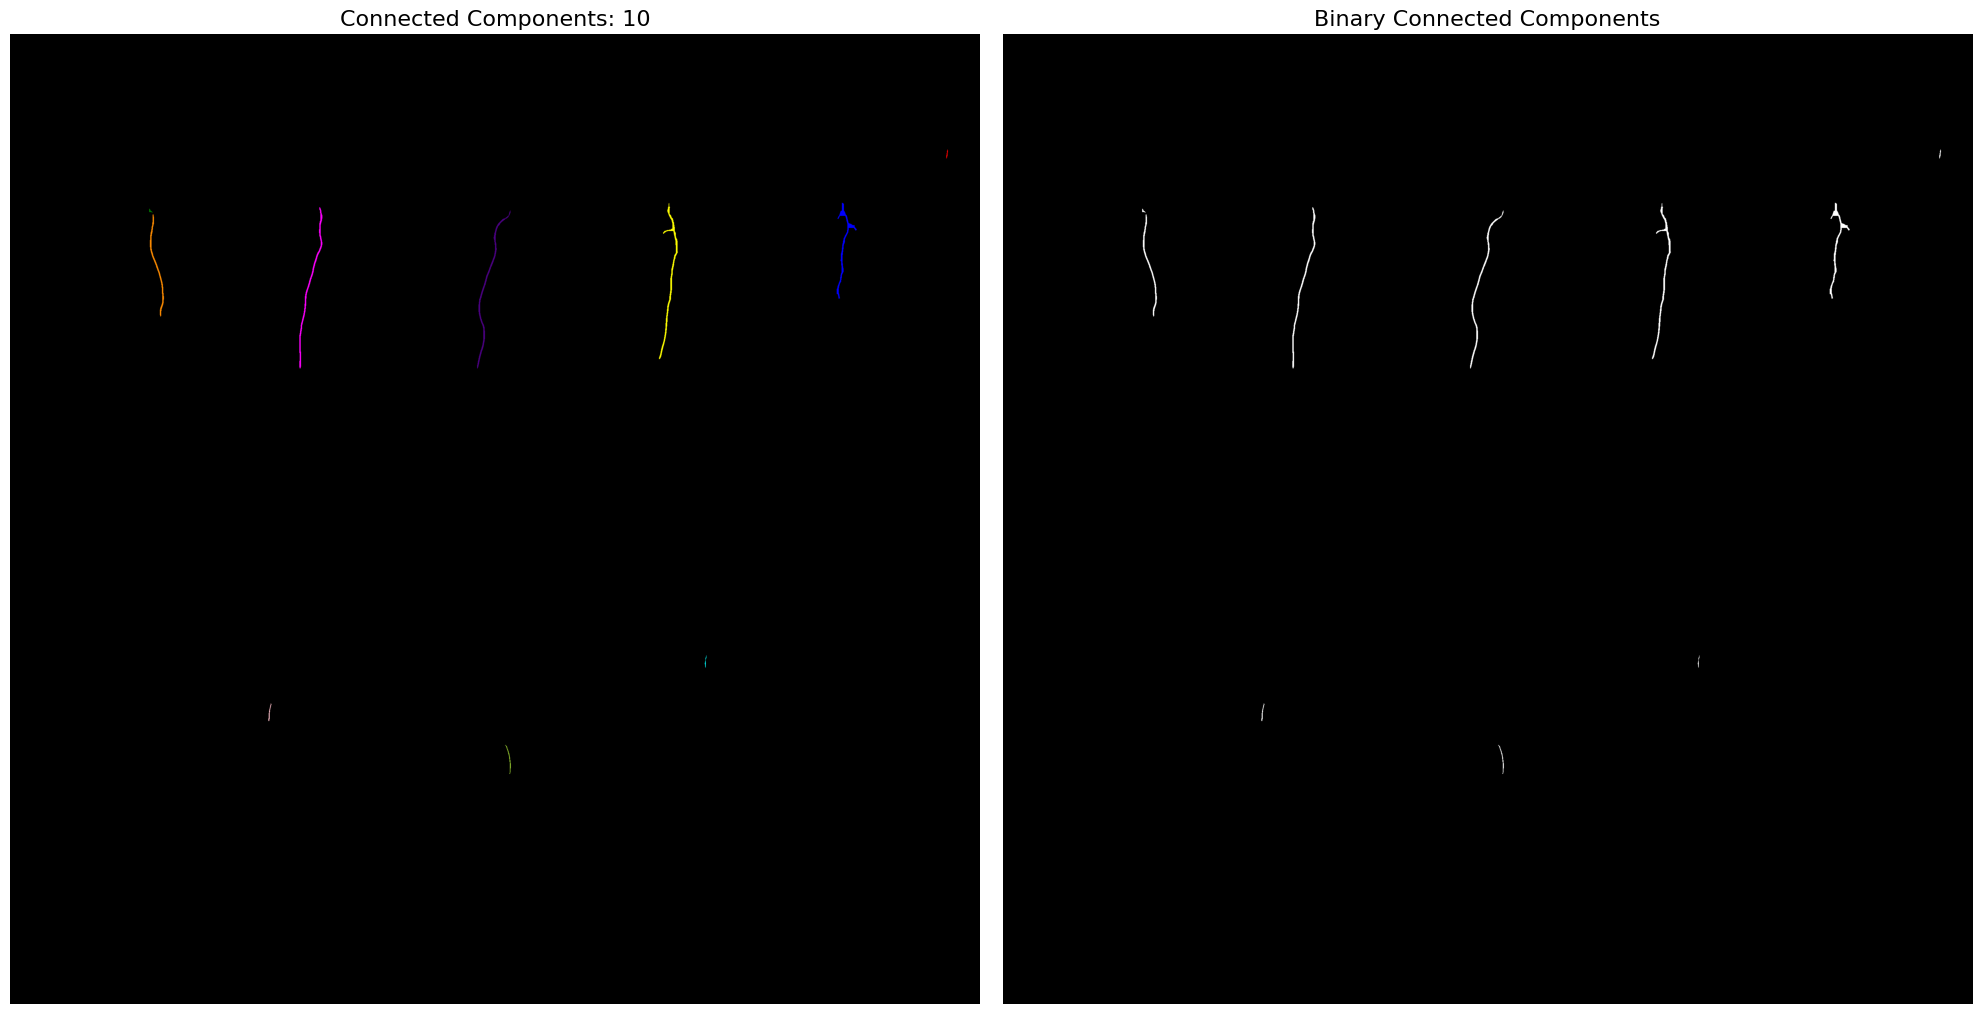

Filename: test_image_7.png | Number of connected components: 7


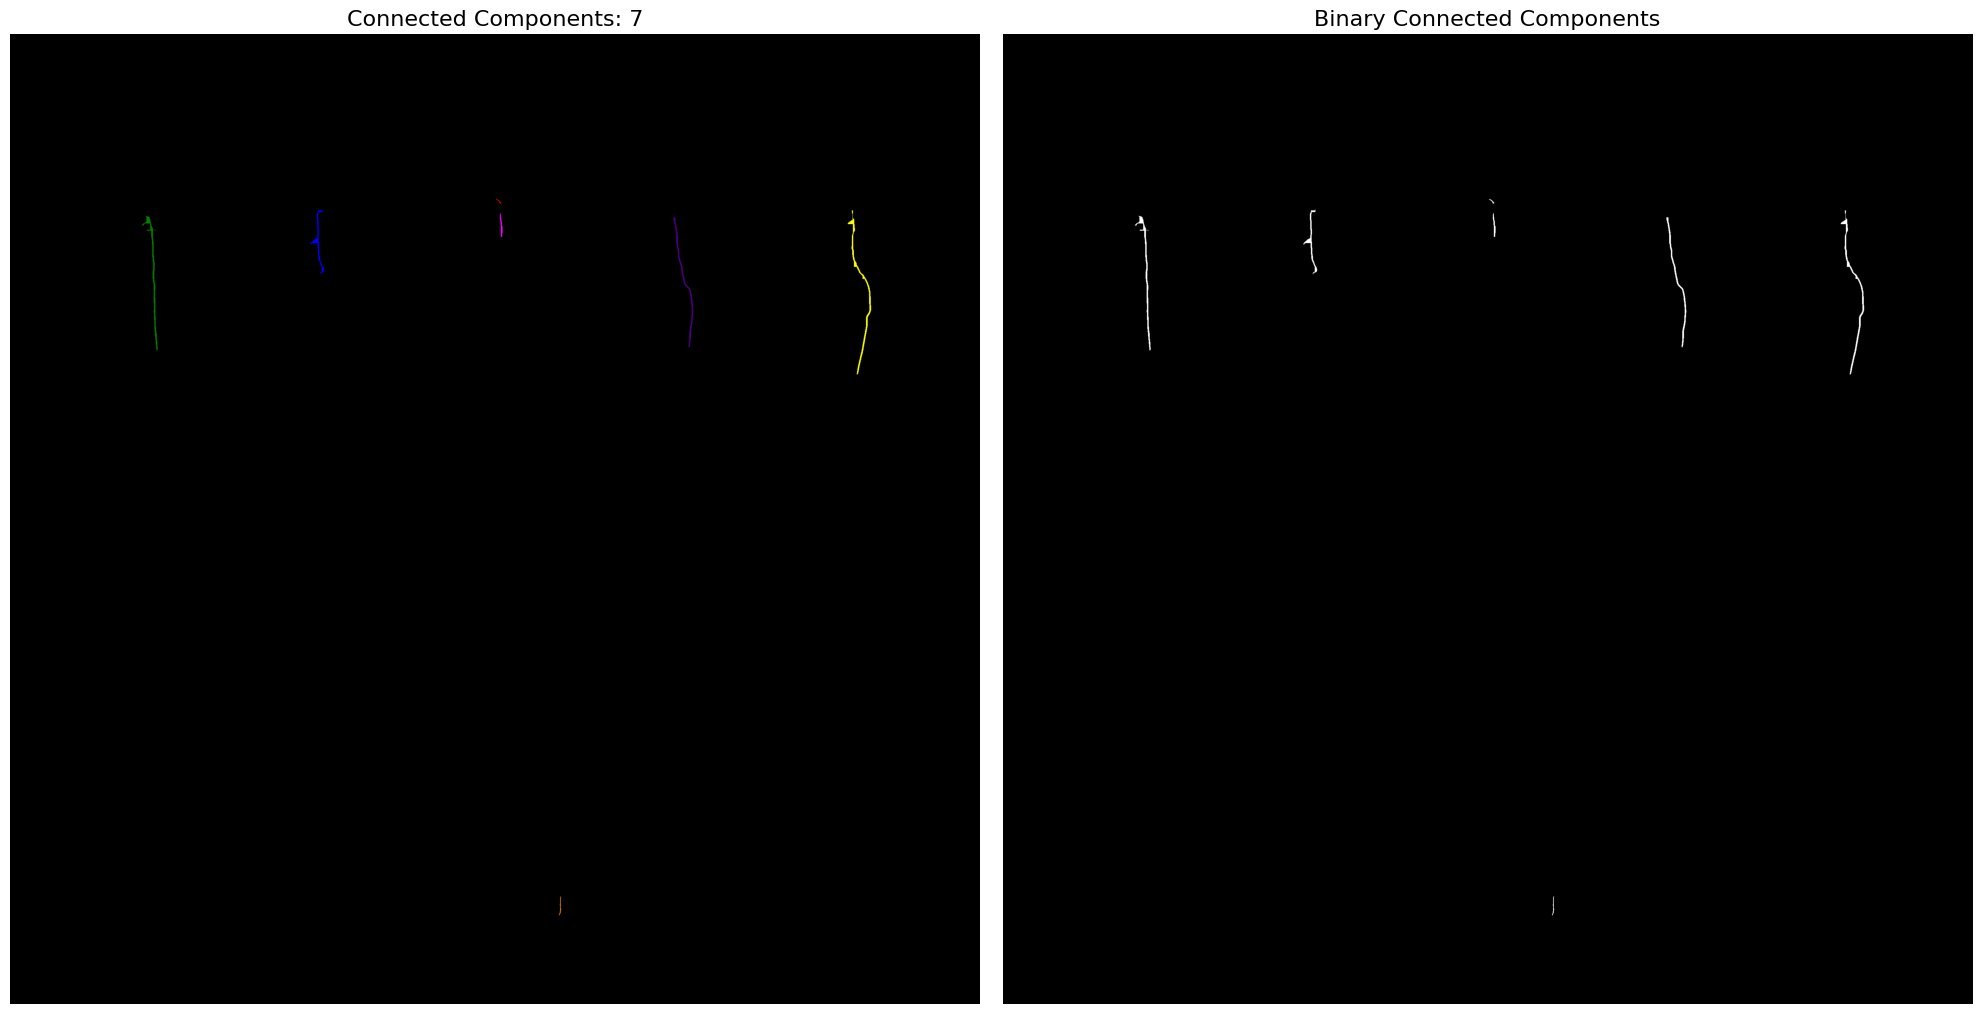

Filename: test_image_8.png | Number of connected components: 25


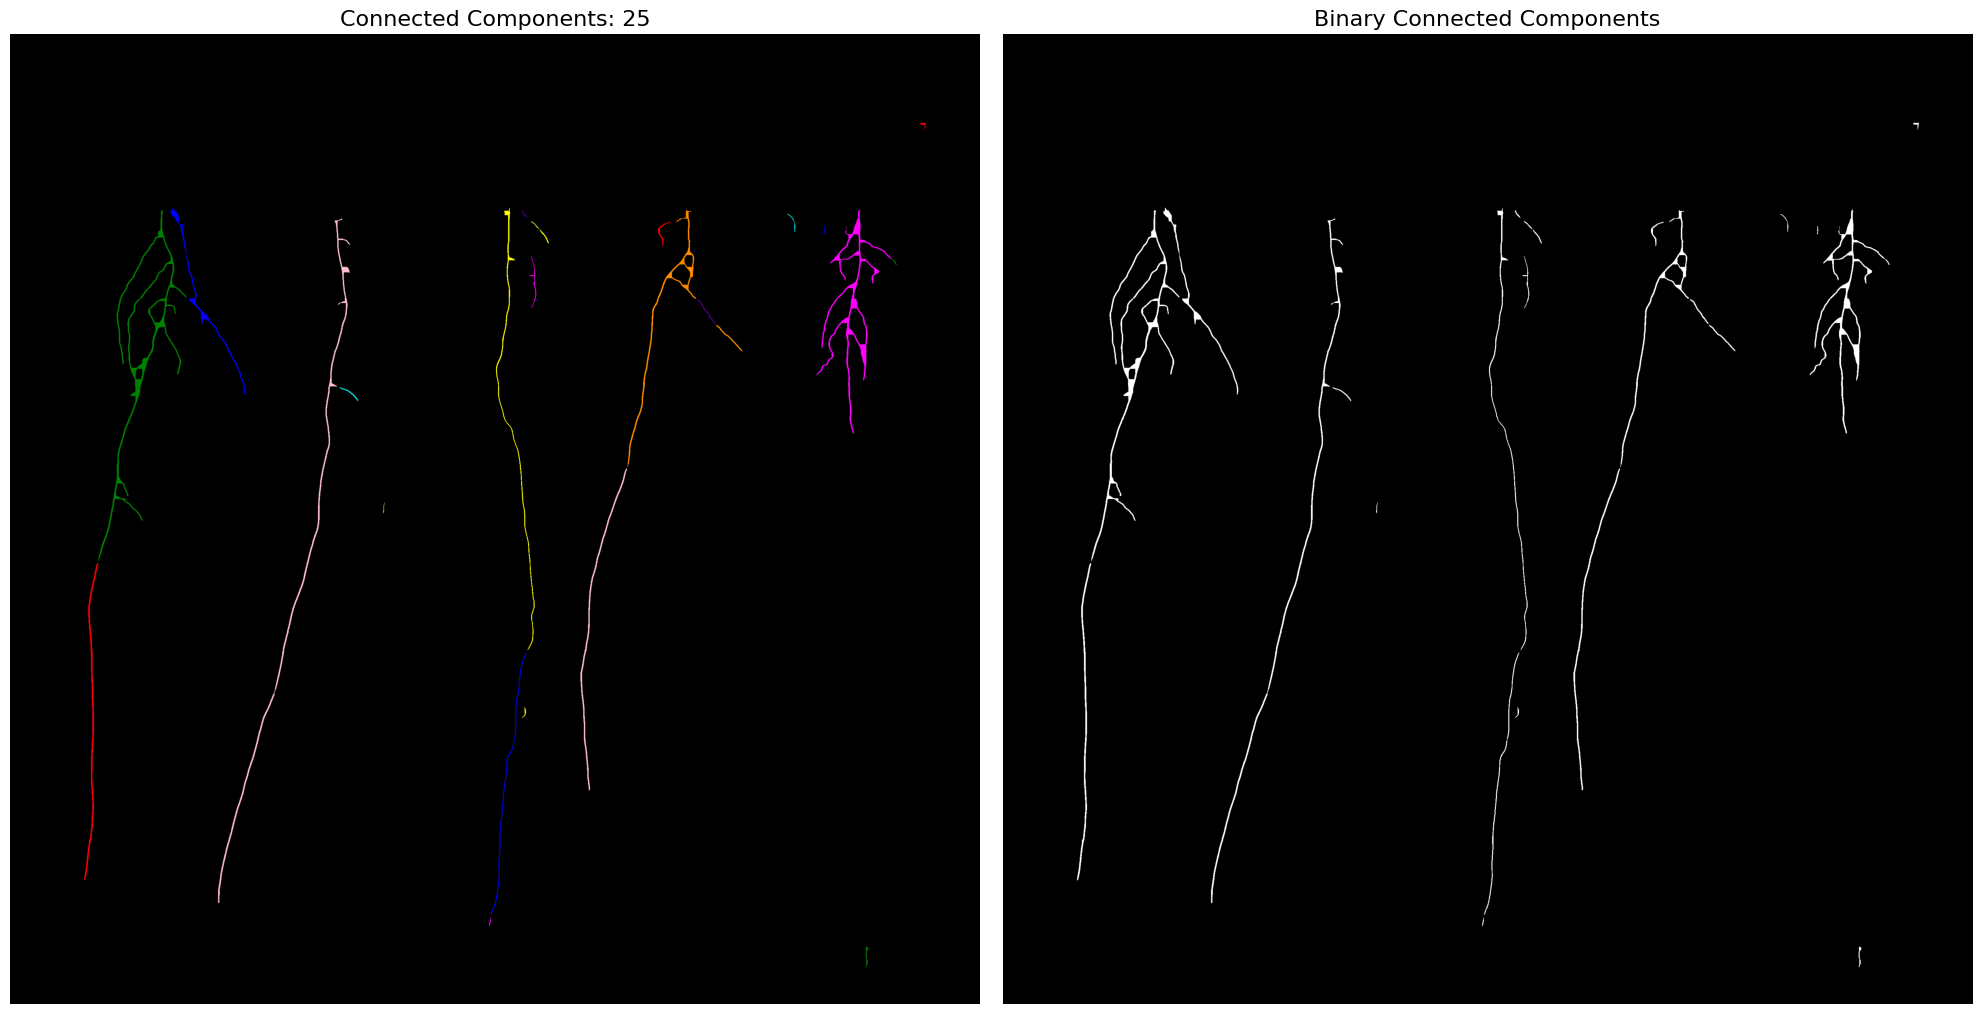

Filename: test_image_9.png | Number of connected components: 30


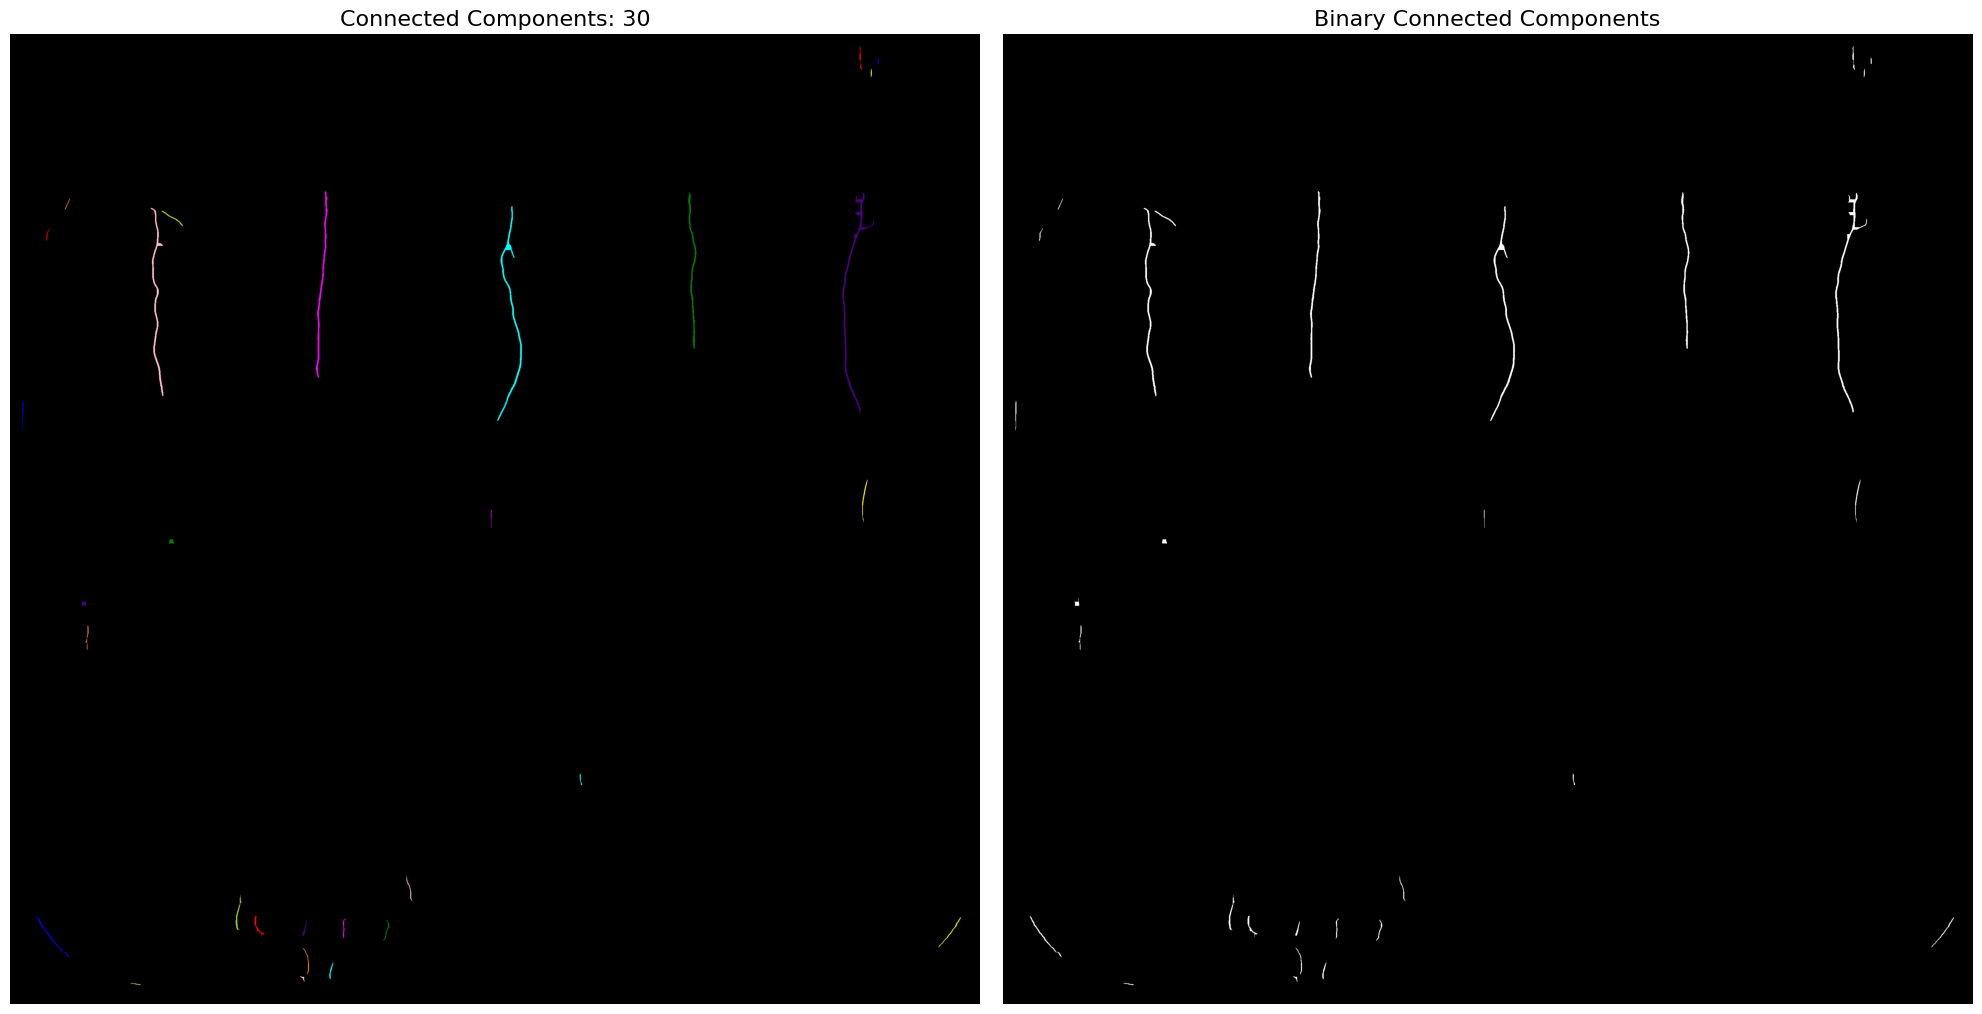

In [10]:
from skimage.measure import label
from skimage.color import label2rgb
import matplotlib.pyplot as plt

# Process connected components for each cleaned mask
for filename, cleaned_mask in processed_masks:
    # Step 1: Label connected components
    labeled_mask = label(cleaned_mask > 0)  # Ensure the mask is binary (True for foreground pixels)

    # Step 2: Count the number of connected components (excluding background)
    num_connected_components = labeled_mask.max()
    print(f"Filename: {filename} | Number of connected components: {num_connected_components}")

    # Step 3: Convert labeled mask to a color image for visualization
    colored_labels = label2rgb(labeled_mask, bg_label=0, bg_color=(0, 0, 0), colors=None)

    # Plot the labeled connected components
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title(f"Connected Components: {num_connected_components}", fontsize=16)
    plt.imshow(colored_labels)
    plt.axis('off')

    # Step 4: Convert labeled mask back to binary
    binary_labels = (labeled_mask > 0).astype(np.uint8) * 255  # Set all non-zero labels to 255

    # Plot the binary connected components
    plt.subplot(1, 2, 2)
    plt.title("Binary Connected Components", fontsize=16)
    plt.imshow(binary_labels, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


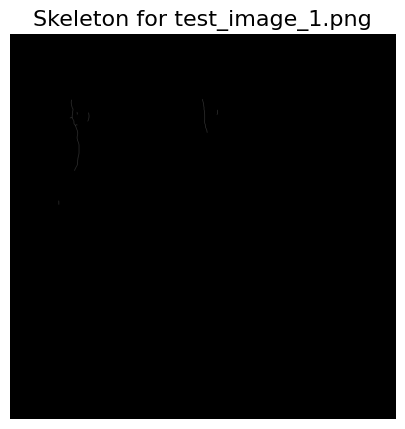

Branch data for test_image_1.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          638       259.497475            0   
1            1            5          370       140.284271            1   
2            2          156          295        37.071068            0   
3            3          203          284        17.828427            0   
4            4          220          454        68.798990            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                476               1405   
1               1.0                0.0                481                448   
2               1.0                0.0                555               1514   
3               1.0                0.0                571                488   
4               1.0                0.0                575                572   

   image-coord-dst-0  image-coord-dst-1 

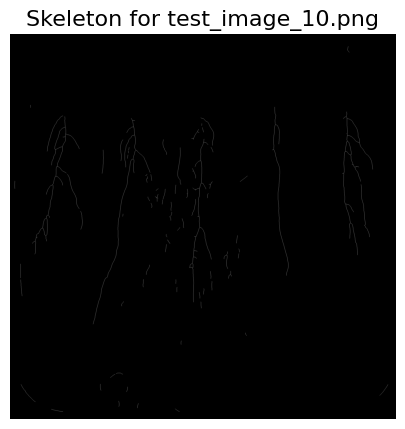

Branch data for test_image_10.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           44        51.870058            0   
1            1           45           69        20.242641            0   
2            2           60          673       139.698485            1   
3            3          101          184        37.485281            1   
4            4          161         3451       313.906638            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 90               2468   
1               1.0                0.0                519                150   
2               1.0                0.0                533               1932   
3               1.0                0.0                568               2456   
4               1.0                0.0                598                386   

   image-coord-dst-0  image-coord-dst-1

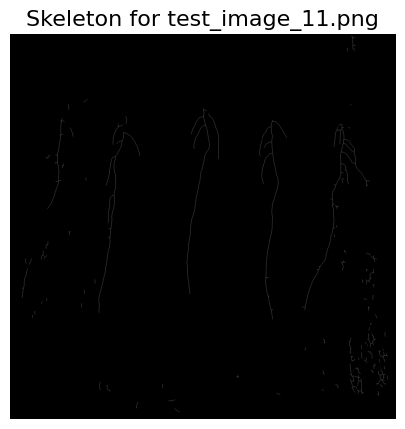

Branch data for test_image_11.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           19        19.242641            1   
1            0           19           91        56.242641            2   
2            0           19           39        18.828427            1   
3            0           91          115        21.071068            1   
4            0           91          155        31.071068            2   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 16               2490   
1               1.0                0.0                 27               2500   
2               1.0                0.0                 27               2500   
3               1.0                0.0                 81               2502   
4               1.0                0.0                 81               2502   

   image-coord-dst-0  image-coord-dst-1

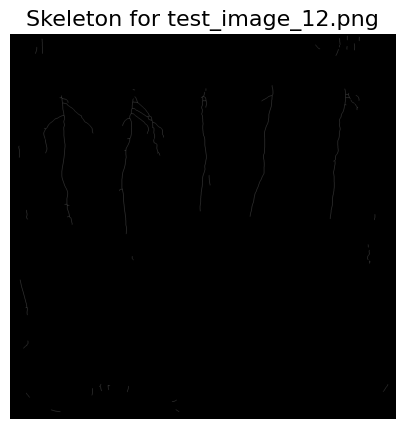

Branch data for test_image_12.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           78        31.414214            0   
1            1            9           97        29.828427            0   
2            2           28          160        49.485281            0   
3            3           40          428       109.656854            0   
4            4          136          354        50.656854            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 13               2461   
1               1.0                0.0                 21               2547   
2               1.0                0.0                 31               2403   
3               1.0                0.0                 35                233   
4               1.0                0.0                 69               2511   

   image-coord-dst-0  image-coord-dst-1

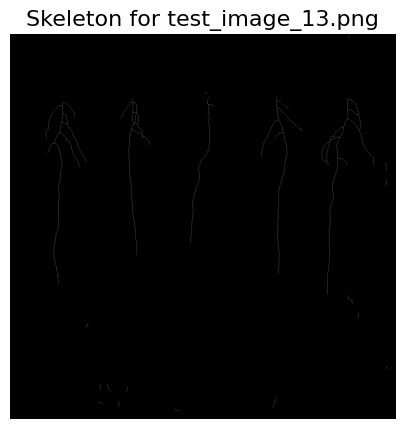

Branch data for test_image_13.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           21        21.000000            0   
1            1           22           29         7.828427            1   
2            1           29           33         6.828427            1   
3            1           29           37         3.828427            1   
4            2           39           51        13.656854            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 13               2468   
1               1.0                0.0                426               1426   
2               1.0                0.0                433               1426   
3               1.0                0.0                433               1426   
4               1.0                0.0                452               1453   

   image-coord-dst-0  image-coord-dst-1

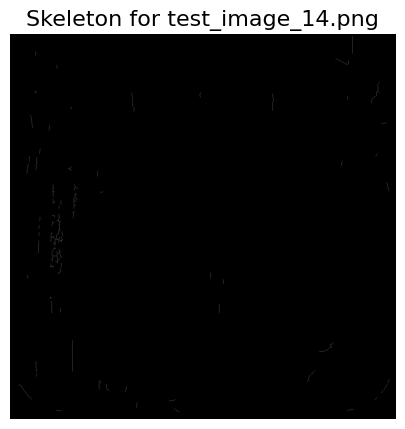

Branch data for test_image_14.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          141       130.556349            0   
1            1          112          158        32.242641            0   
2            2          159          196       134.053824            0   
3            3          275          302        29.071068            0   
4            4          303          371        78.597980            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 15               2495   
1               1.0                0.0                127                188   
2               1.0                0.0                179               2375   
3               1.0                0.0                226                341   
4               1.0                0.0                351               2698   

   image-coord-dst-0  image-coord-dst-1

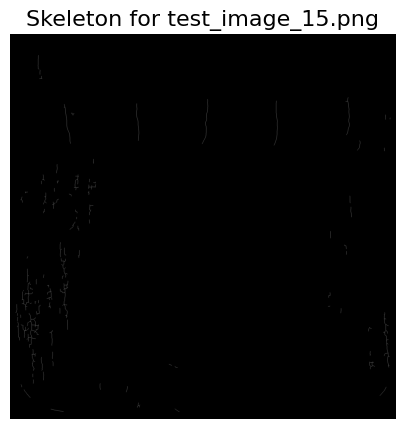

Branch data for test_image_15.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          106       109.727922            0   
1            1          107          140        35.071068            0   
2            2          141          170        17.414214            1   
3            2          170          178        16.828427            1   
4            2          170          176         4.828427            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                155                208   
1               1.0                0.0                263                220   
2               1.0                0.0                307                229   
3               1.0                0.0                324                230   
4               1.0                0.0                324                230   

   image-coord-dst-0  image-coord-dst-1

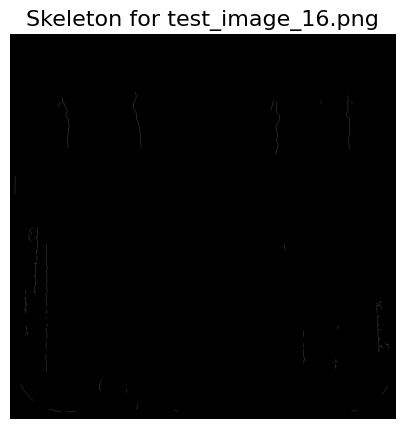

Branch data for test_image_16.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0         1656       441.450793            0   
1            1           27         1688       415.681241            0   
2            2           52          148        31.485281            1   
3            3          123          320        29.485281            1   
4            4          140          298        21.242641            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                424                914   
1               1.0                0.0                450               2464   
2               1.0                0.0                463                377   
3               1.0                0.0                486               1923   
4               1.0                0.0                490               2267   

   image-coord-dst-0  image-coord-dst-1

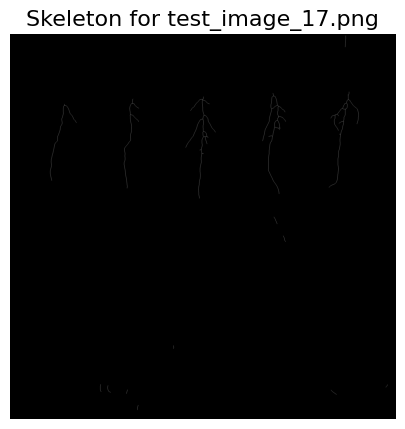

Branch data for test_image_17.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           84        86.071068            0   
1            1           85          127        27.071068            1   
2            2           95          141        22.656854            1   
3            1          122          127         3.414214            1   
4            1          127          279        33.414214            2   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 11               2450   
1               1.0                0.0                422               2473   
2               1.0                0.0                432               1918   
3               1.0                0.0                445               2464   
4               1.0                0.0                446               2467   

   image-coord-dst-0  image-coord-dst-1

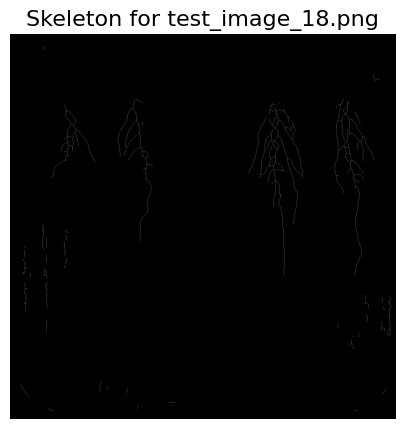

Branch data for test_image_18.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            1           39        39.828427            0   
1            1           40          116        44.556349            1   
2            1           62          116        39.899495            1   
3            1          116          129        14.485281            1   
4            2          134          333        48.284271            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 83                251   
1               1.0                0.0                298               2652   
2               1.0                0.0                319               2688   
3               1.0                0.0                338               2663   
4               1.0                0.0                478               2434   

   image-coord-dst-0  image-coord-dst-1

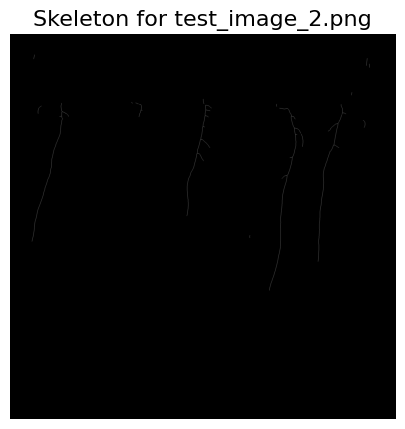

Branch data for test_image_2.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           36        33.899495            0   
1            1           27           99        56.899495            0   
2            2           74          114        27.828427            0   
3            3          115          136        23.071068            0   
4            4          137          211        38.485281            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                151                179   
1               1.0                0.0                177               2606   
2               1.0                0.0                218               2621   
3               1.0                0.0                426               2494   
4               1.0                0.0                475               1409   

   image-coord-dst-0  image-coord-dst-1 

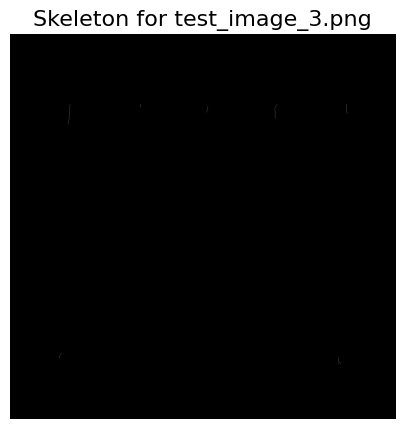

Branch data for test_image_3.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          401       155.798990            0   
1            1            1          357       115.698485            0   
2            2            2           16         3.000000            1   
3            3            4          106        24.656854            0   
4            2           12           16         2.414214            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                512                439   
1               1.0                0.0                512               1950   
2               1.0                0.0                512               2455   
3               1.0                0.0                513                950   
4               1.0                0.0                514               2457   

   image-coord-dst-0  image-coord-dst-1 

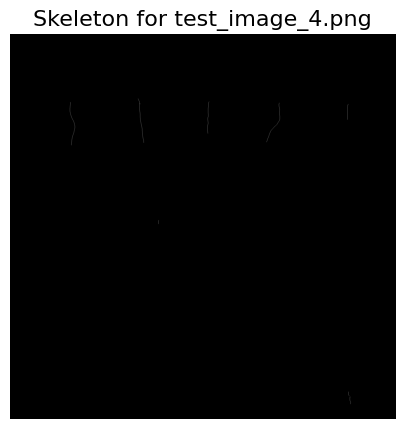

Branch data for test_image_4.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           74        42.556349            1   
1            1           23         1066       243.355339            0   
2            2           30         1284       342.752309            0   
3            3           48         1256       333.320851            0   
4            0           74           84         6.414214            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                472                934   
1               1.0                0.0                494               1453   
2               1.0                0.0                498                440   
3               1.0                0.0                503               1964   
4               1.0                0.0                510                945   

   image-coord-dst-0  image-coord-dst-1 

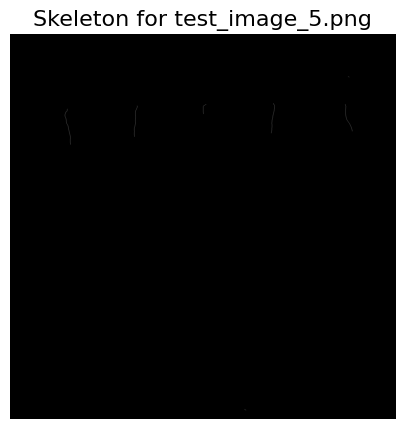

Branch data for test_image_5.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0            9        10.656854            0   
1            1           10          892       234.911688            0   
2            2           18          850       220.781746            0   
3            3           22          340        84.627417            0   
4            4           58          944       241.497475            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                311               2466   
1               1.0                0.0                506               1922   
2               1.0                0.0                513               2445   
3               1.0                0.0                514               1431   
4               1.0                0.0                524                927   

   image-coord-dst-0  image-coord-dst-1 

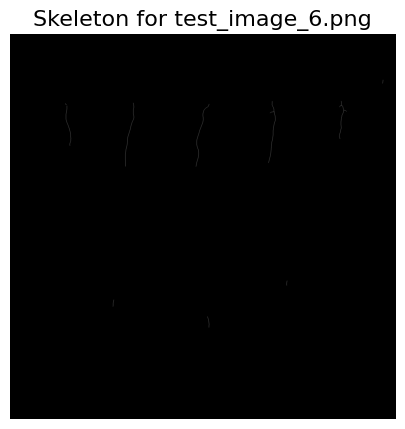

Branch data for test_image_6.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           26        27.242641            0   
1            1           27          138        33.242641            1   
2            2           28          417        84.041631            1   
3            3           52         2065       498.137085            0   
4            4           64          117        16.485281            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                335               2721   
1               1.0                0.0                490               2415   
2               1.0                0.0                491               1913   
3               1.0                0.0                503                898   
4               1.0                0.0                507                404   

   image-coord-dst-0  image-coord-dst-1 

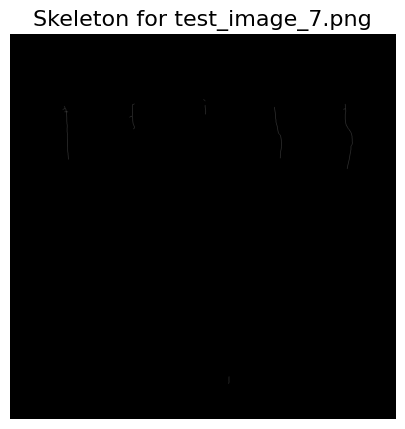

Branch data for test_image_7.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           14        18.142136            0   
1            1           15          472       104.384776            1   
2            2           19          169        37.071068            1   
3            3           42          414        69.071068            0   
4            4           65          141        19.485281            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                479               1411   
1               1.0                0.0                509                906   
2               1.0                0.0                512               2445   
3               1.0                0.0                520               1423   
4               1.0                0.0                528                394   

   image-coord-dst-0  image-coord-dst-1 

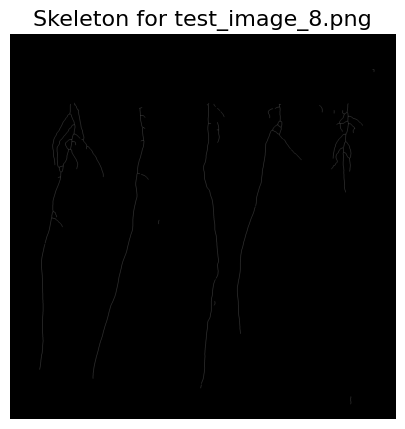

Branch data for test_image_8.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           27        27.828427            0   
1            1           28          104        16.071068            1   
2            2           30          114        16.485281            1   
3            3           37          648        69.970563            1   
4            4           49          199        24.384776            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                260               2645   
1               1.0                0.0                504                470   
2               1.0                0.0                505               1450   
3               1.0                0.0                508               2466   
4               1.0                0.0                512               1487   

   image-coord-dst-0  image-coord-dst-1 

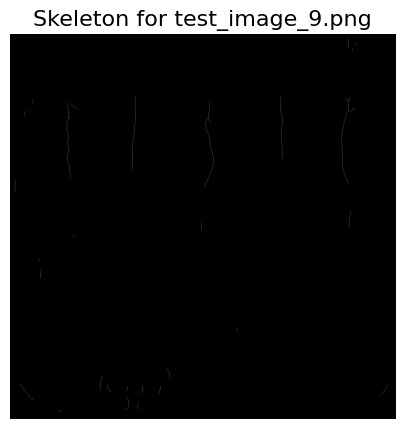

Branch data for test_image_9.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           86        69.899495            0   
1            1           34           68        17.414214            0   
2            2           85          110        24.828427            0   
3            3          111         2907       556.053824            0   
4            4          114         2572       471.296465            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 35               2468   
1               1.0                0.0                 68               2519   
2               1.0                0.0                101               2501   
3               1.0                0.0                458                915   
4               1.0                0.0                460               1973   

   image-coord-dst-0  image-coord-dst-1 

In [11]:
from skimage.morphology import skeletonize
from skan import Skeleton, summarize
import matplotlib.pyplot as plt

# Process skeletonization for each binary connected component
skeleton_results = []
for filename, binary_labels in processed_masks:
    # Step 1: Skeletonize the binary mask
    skeleton_object = skeletonize(binary_labels > 0)  # Ensure mask is binary (True for foreground)

    # Step 2: Convert the skeletonized object into a skan Skeleton object
    skeleton_data = Skeleton(skeleton_object)

    # Step 3: Summarize the skeleton's branch data
    branch_data = summarize(skeleton_data)

    # Append results for further use
    skeleton_results.append((filename, skeleton_object, branch_data))

    # Plot the skeletonized mask
    plt.figure(figsize=(10, 5))
    plt.title(f"Skeleton for {filename}", fontsize=16)
    plt.imshow(skeleton_object, cmap='gray')
    plt.axis('off')
    plt.show()

    # Display branch data
    print(f"Branch data for {filename}:")
    print(branch_data.head())  # Display the first few rows of branch data

Processing test_image_1.png...


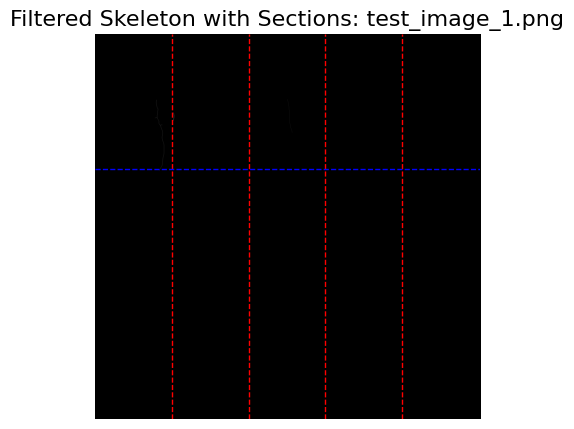

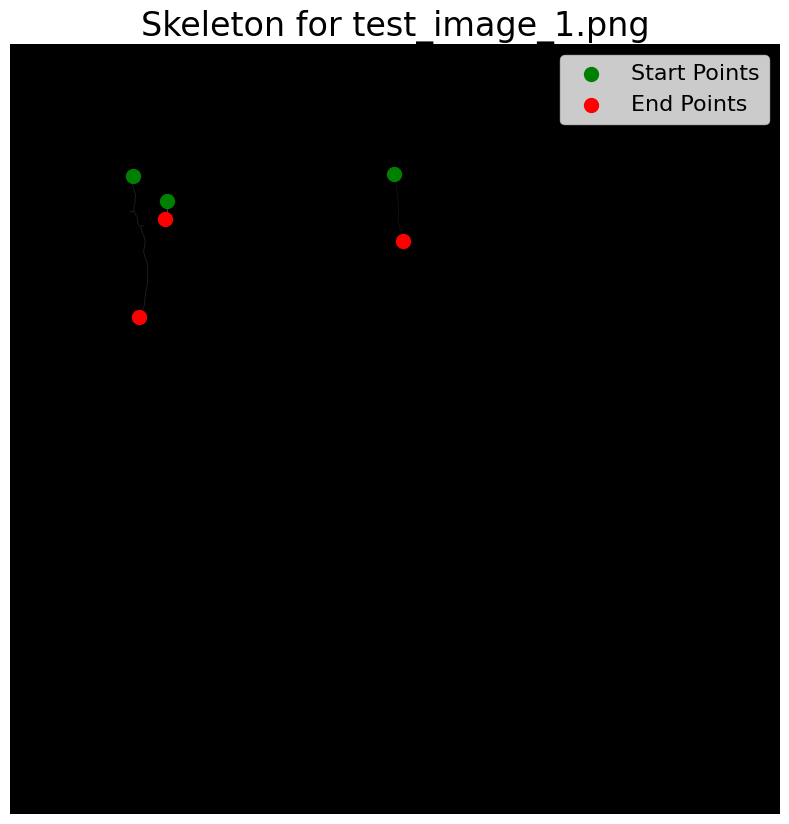

Processing test_image_10.png...


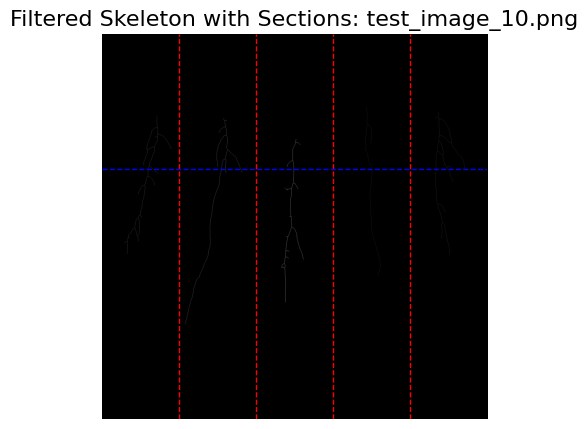

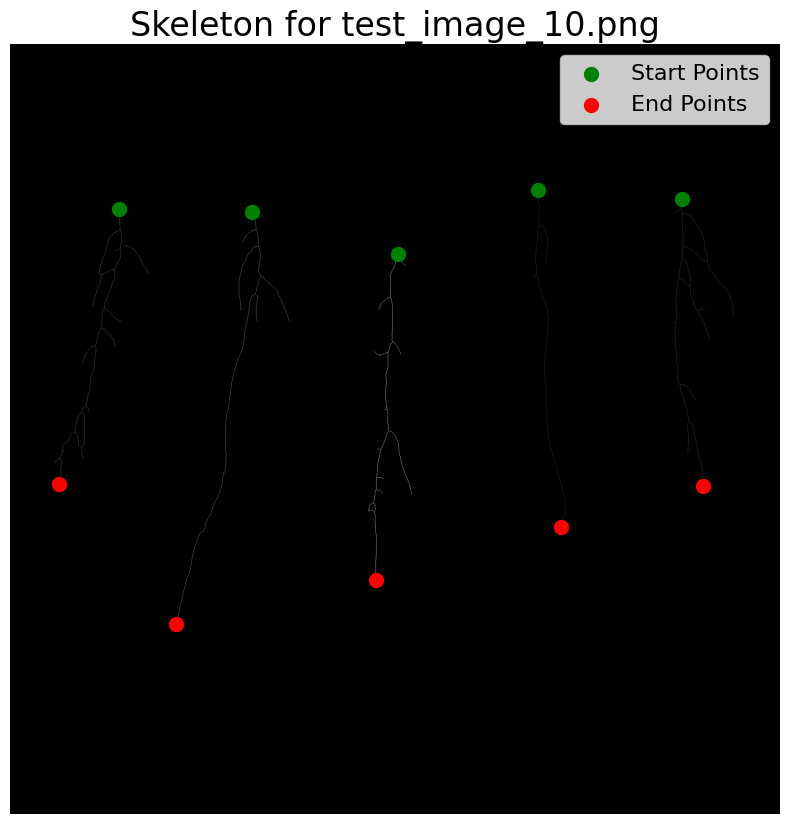

Processing test_image_11.png...


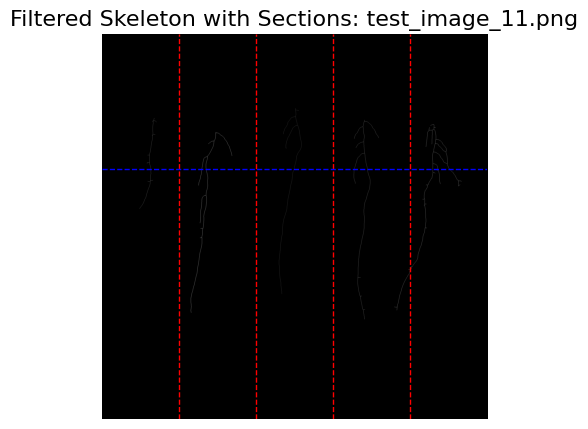

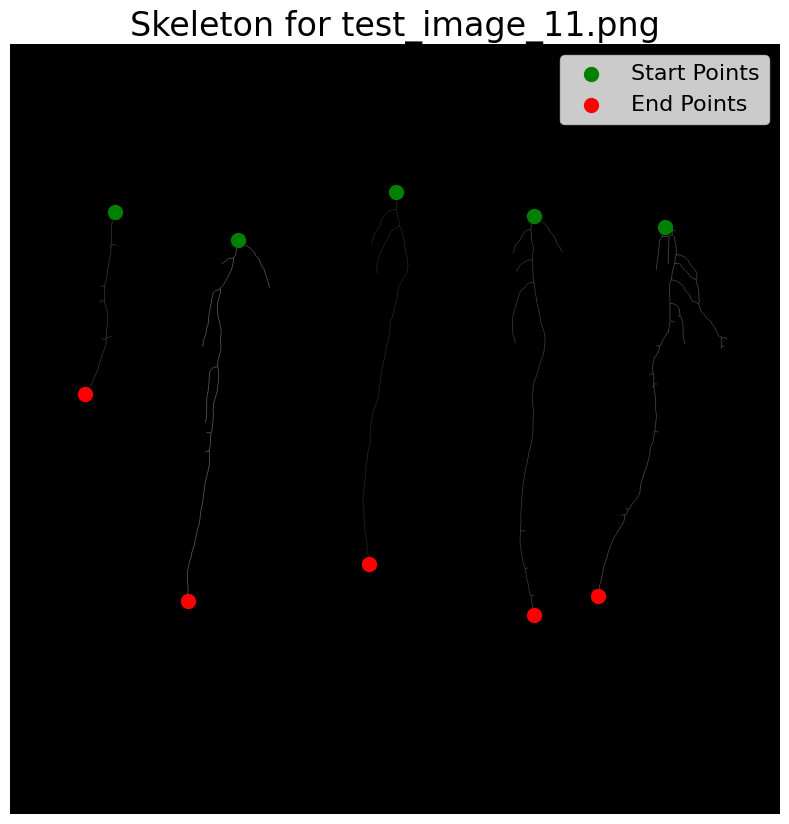

Processing test_image_12.png...


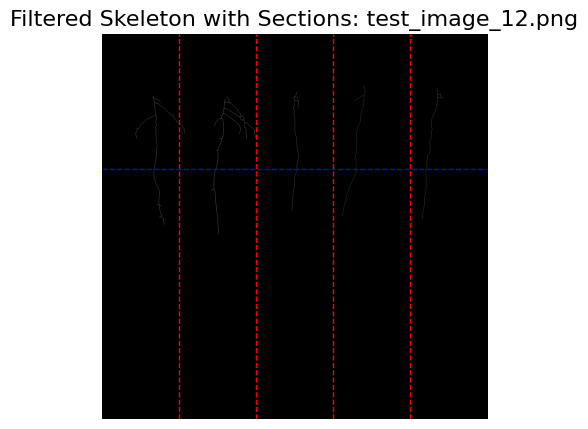

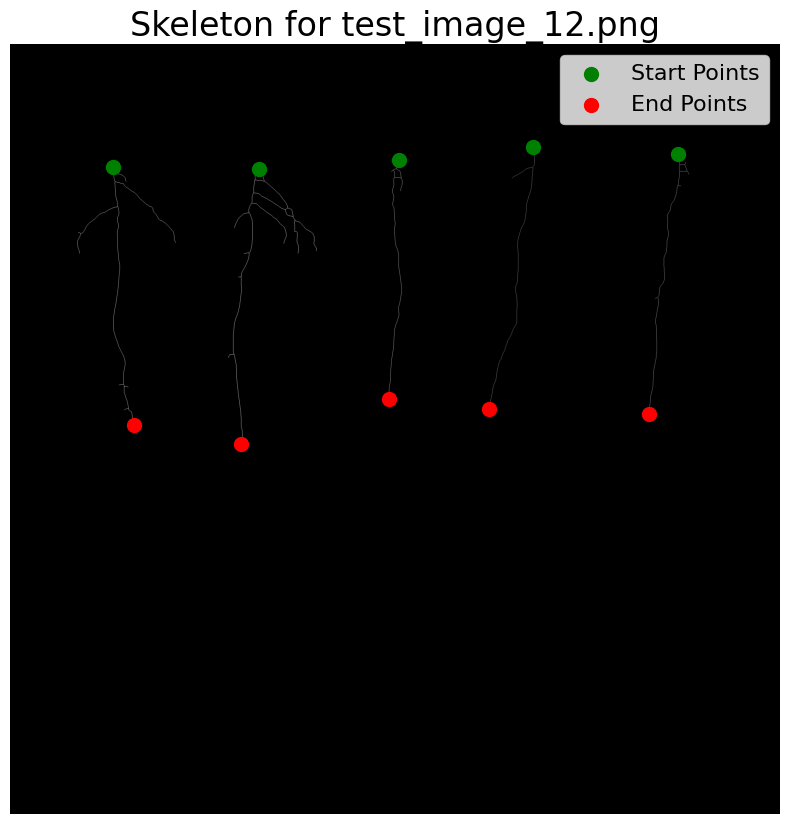

Processing test_image_13.png...


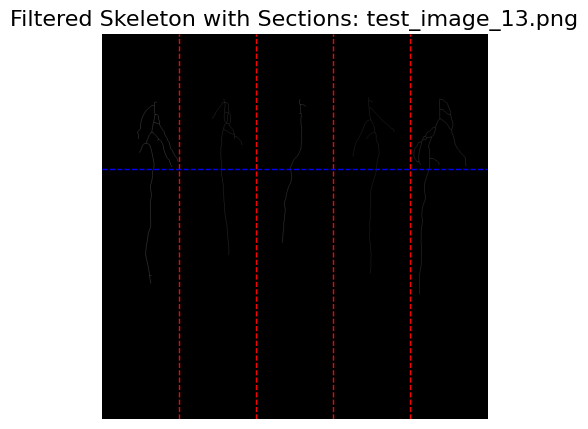

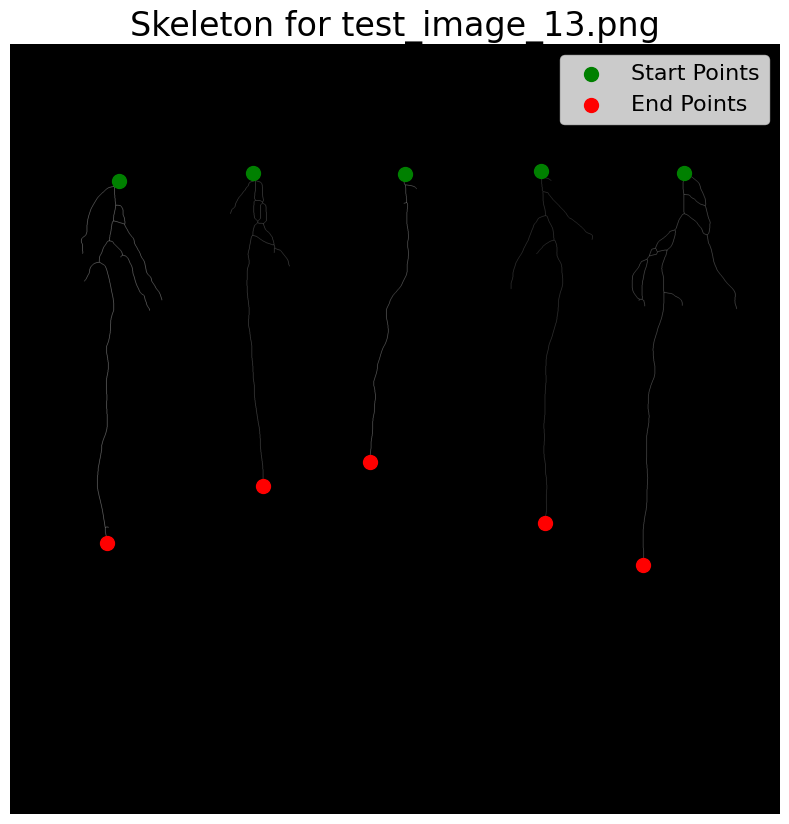

Processing test_image_14.png...


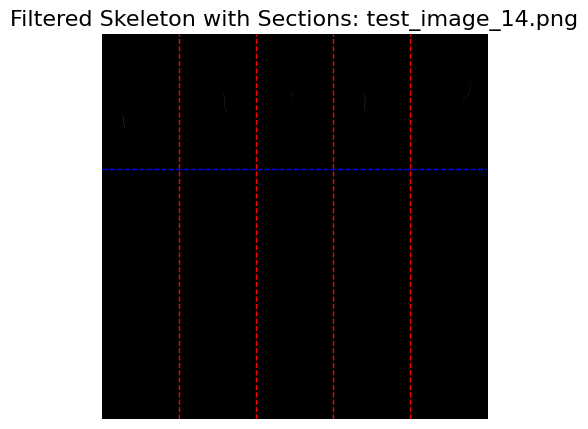

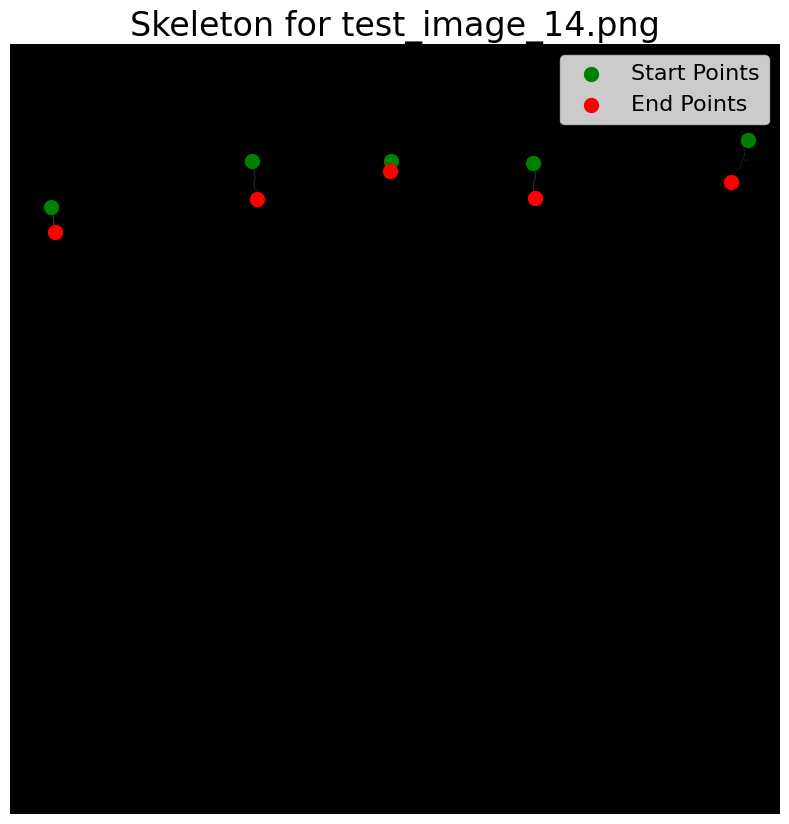

Processing test_image_15.png...


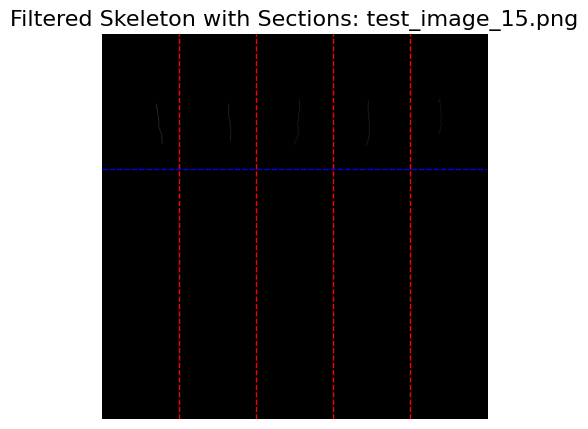

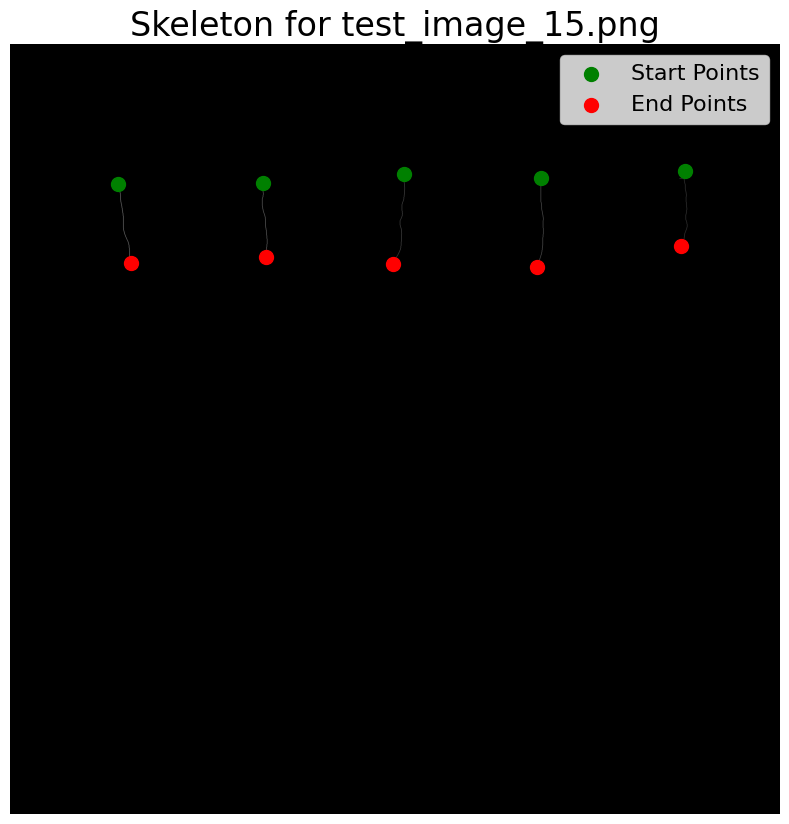

Processing test_image_16.png...


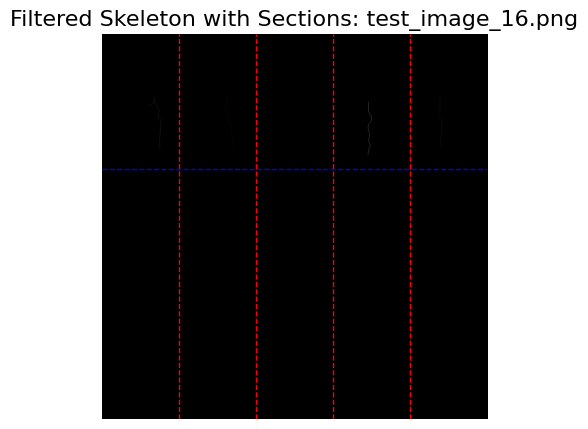

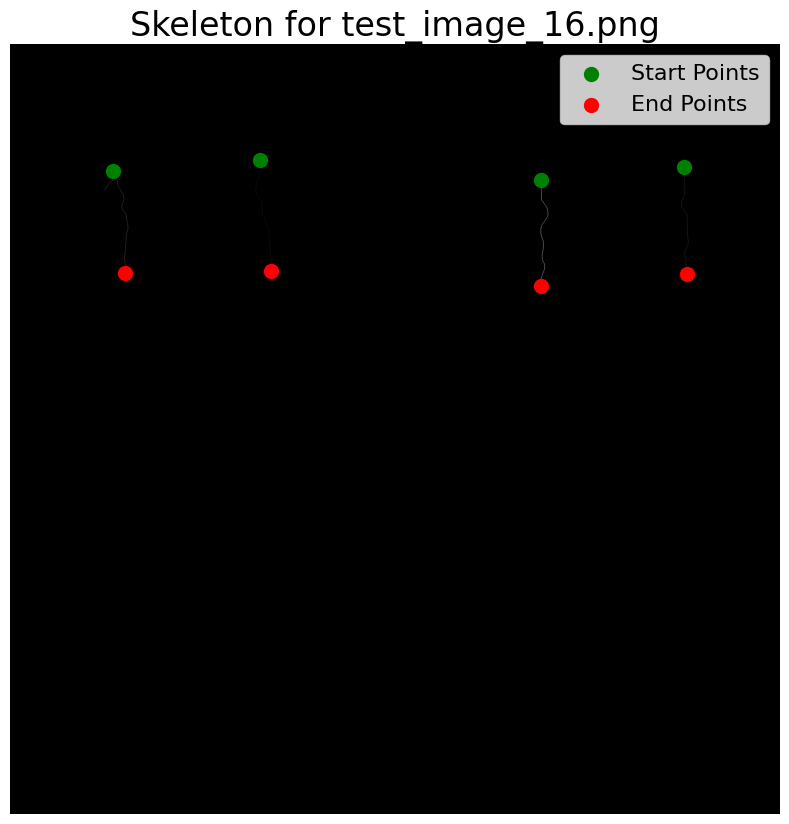

Processing test_image_17.png...


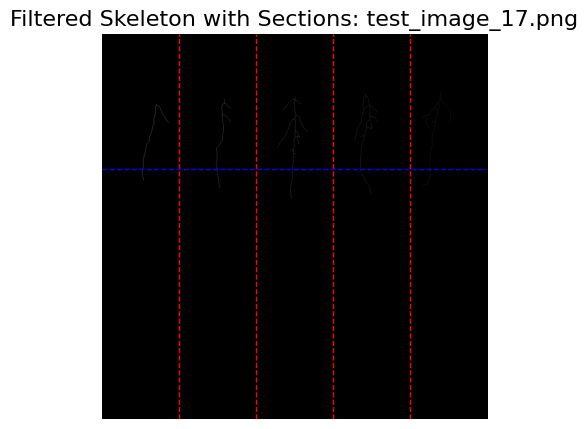

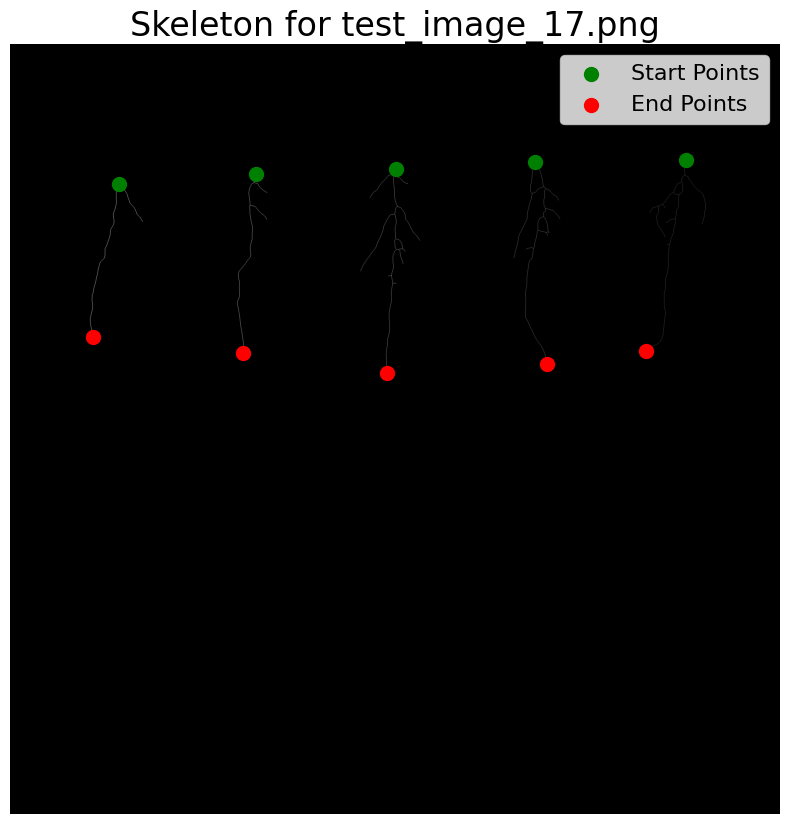

Processing test_image_18.png...


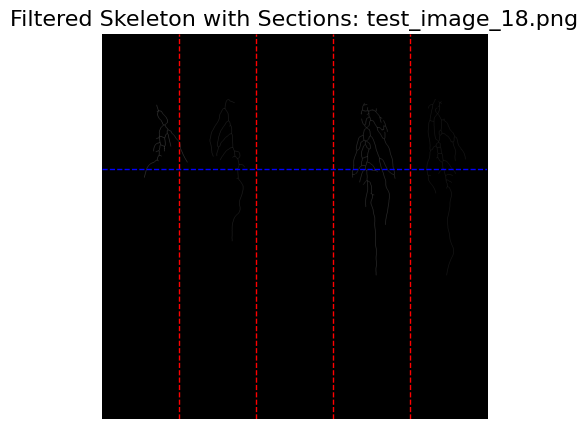

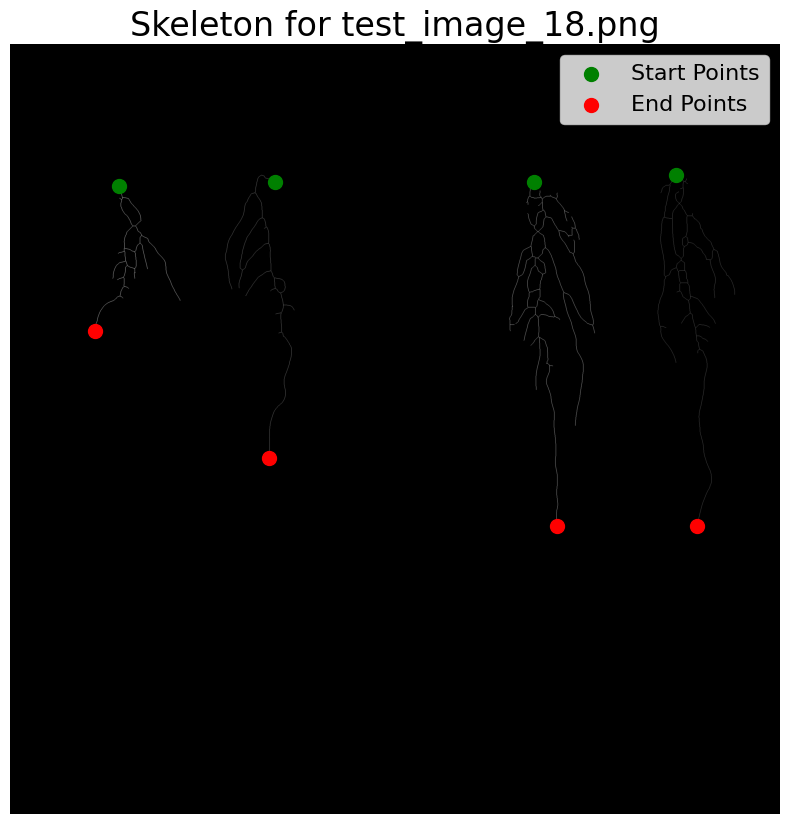

Processing test_image_2.png...


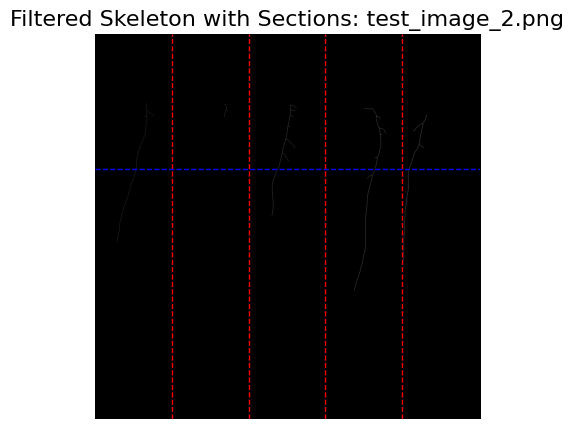

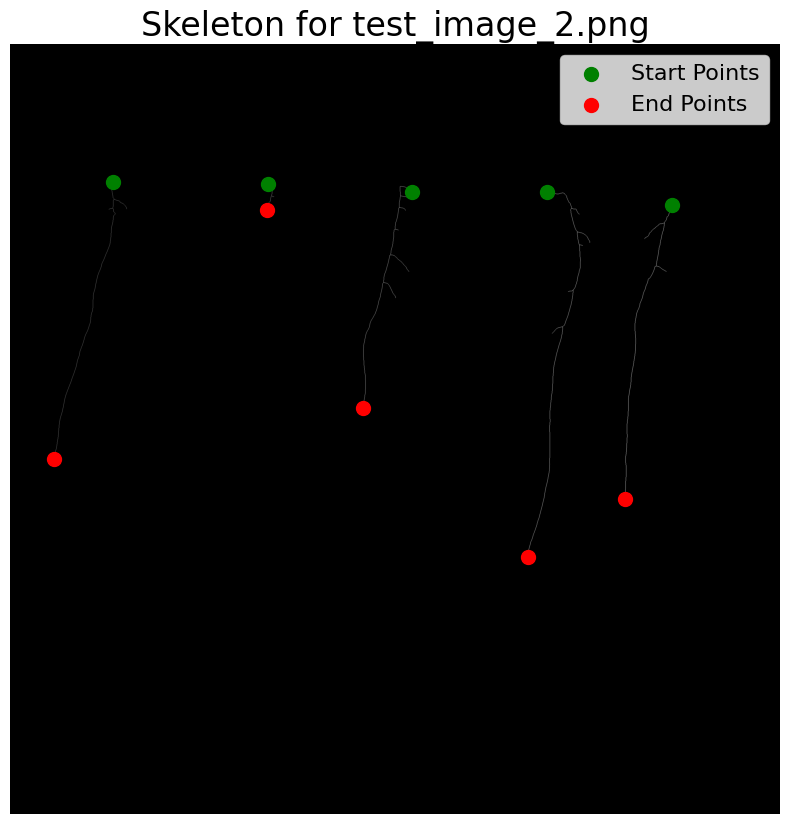

Processing test_image_3.png...


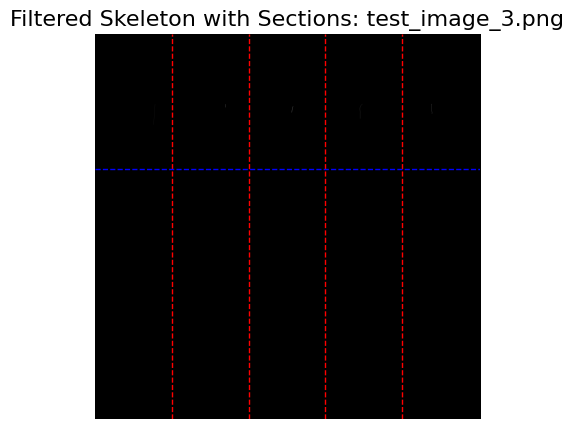

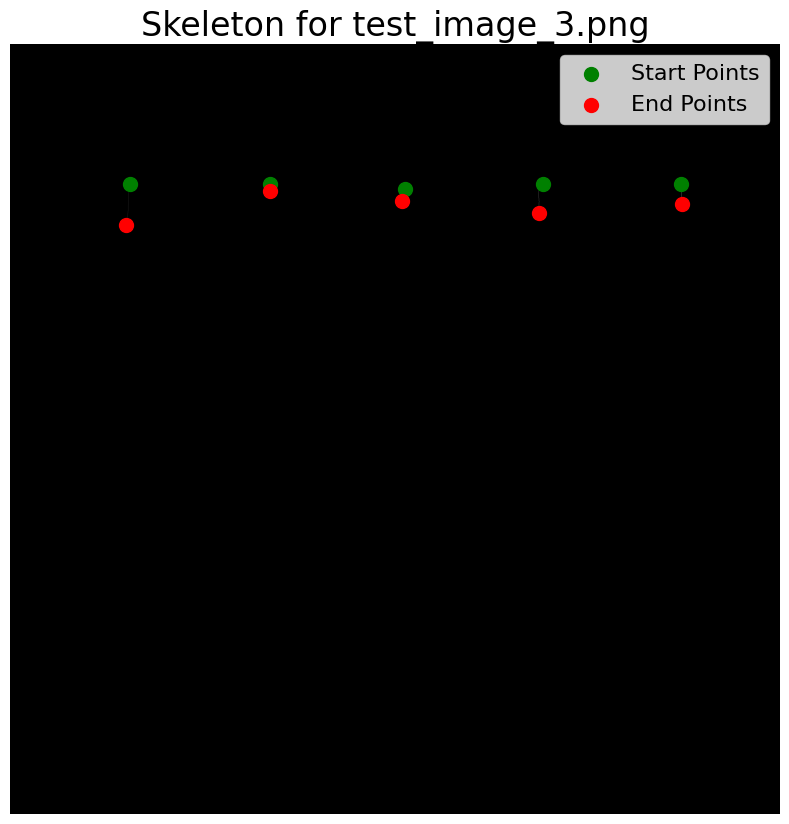

Processing test_image_4.png...


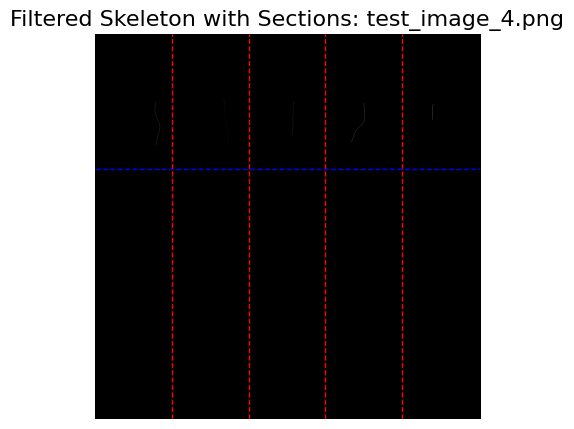

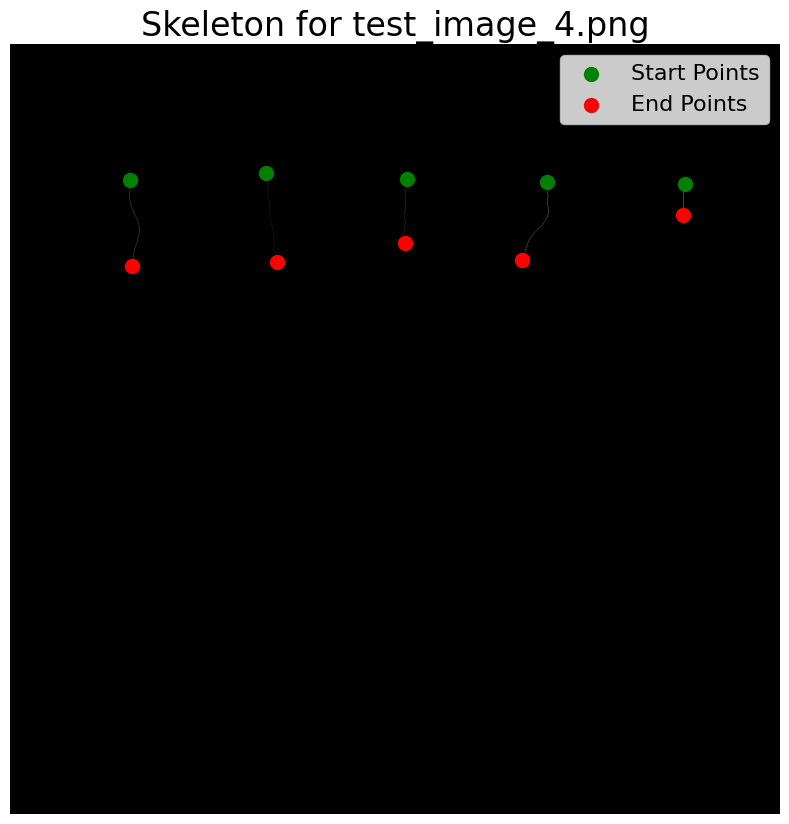

Processing test_image_5.png...


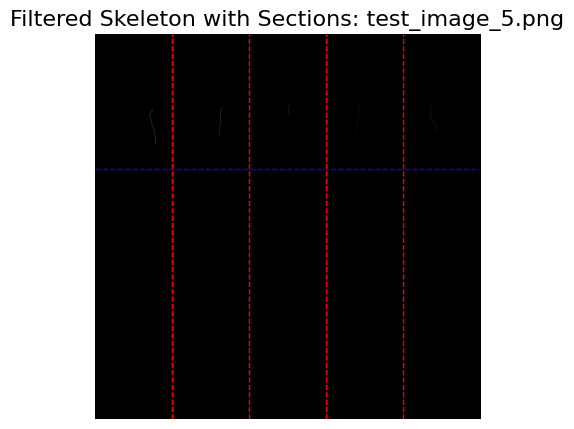

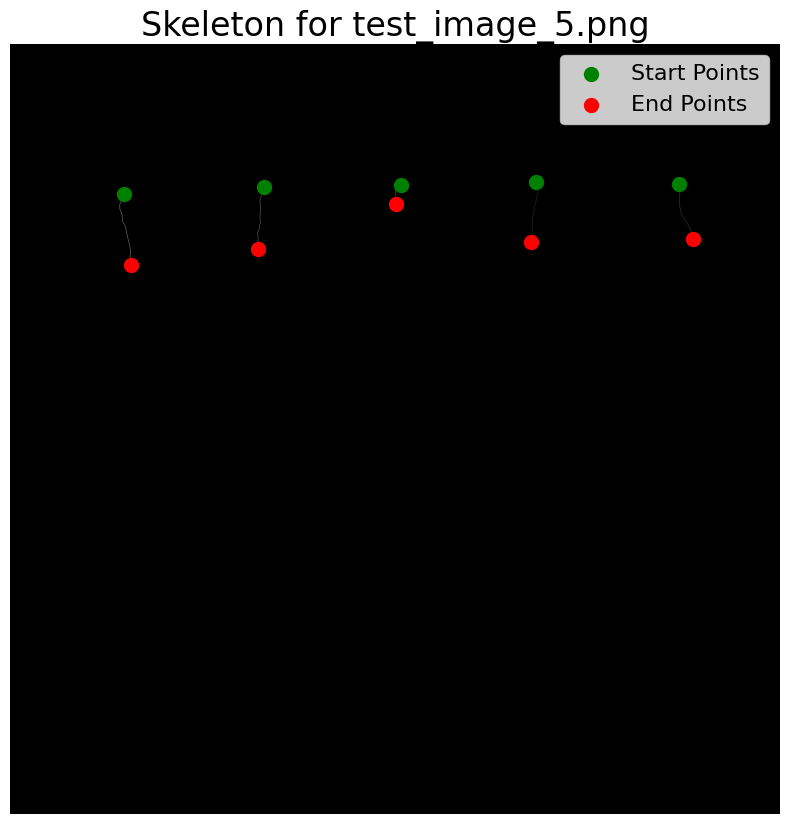

Processing test_image_6.png...


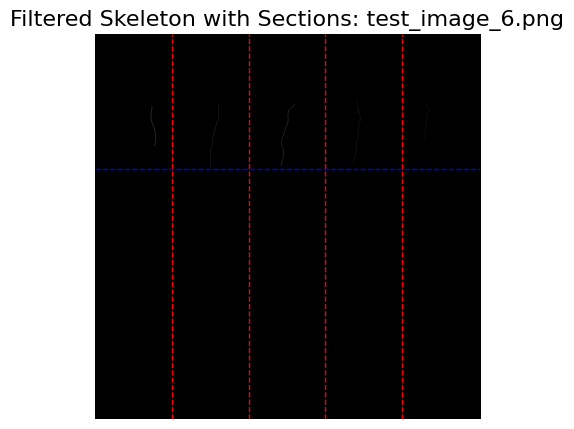

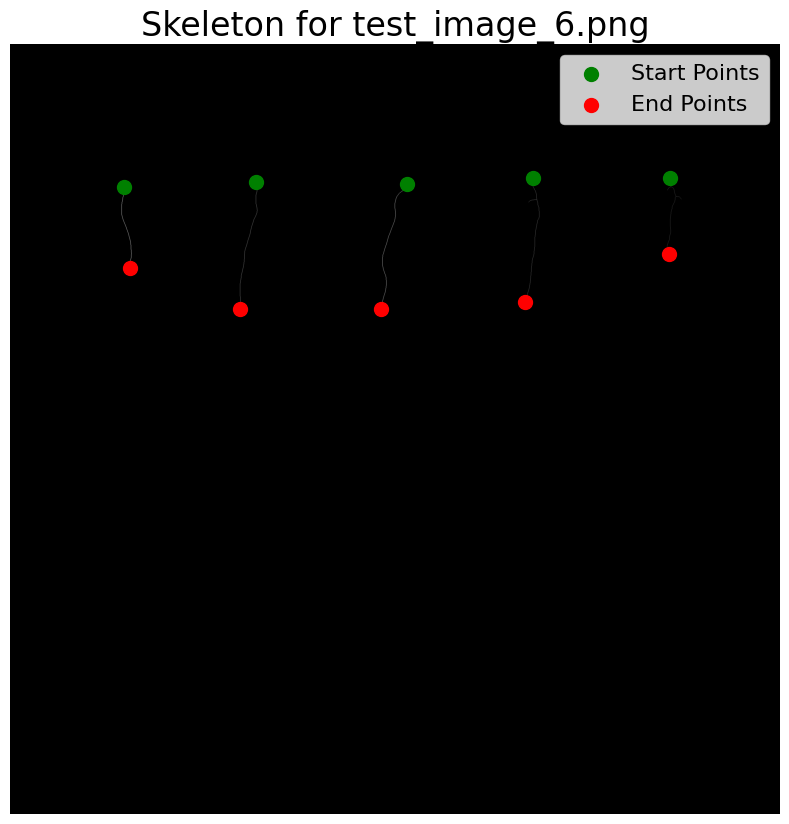

Processing test_image_7.png...


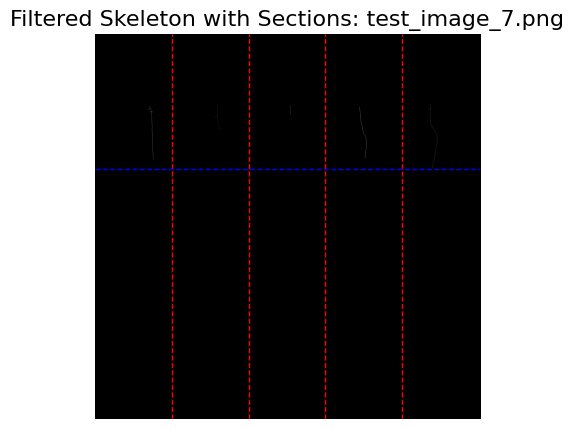

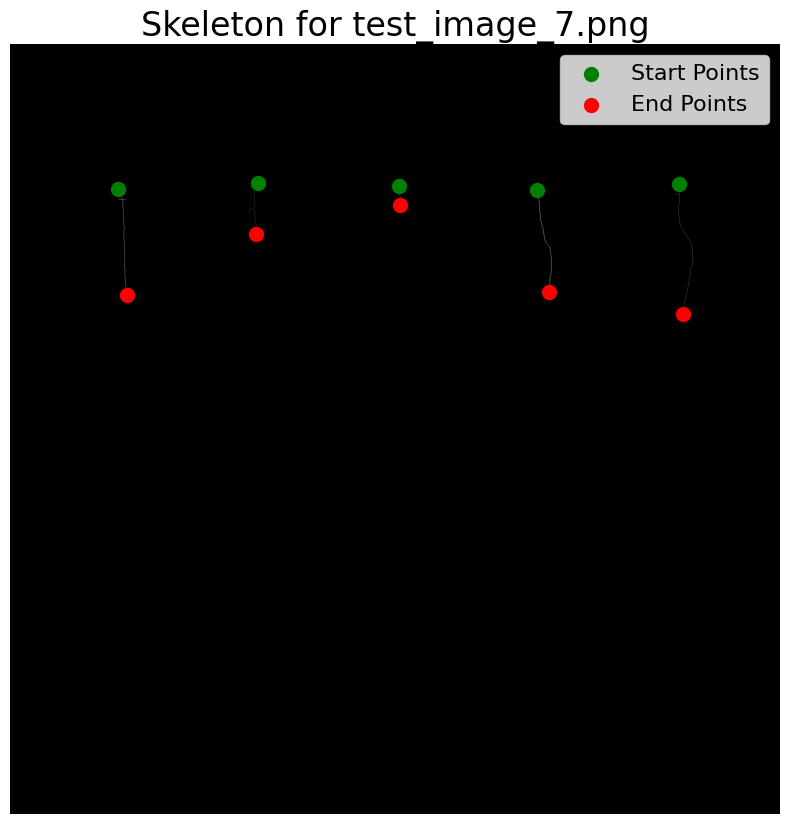

Processing test_image_8.png...


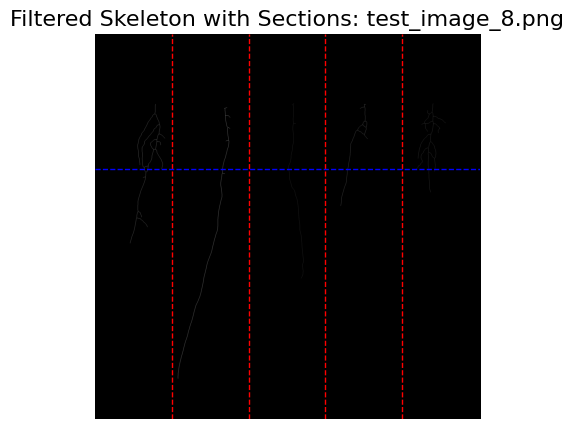

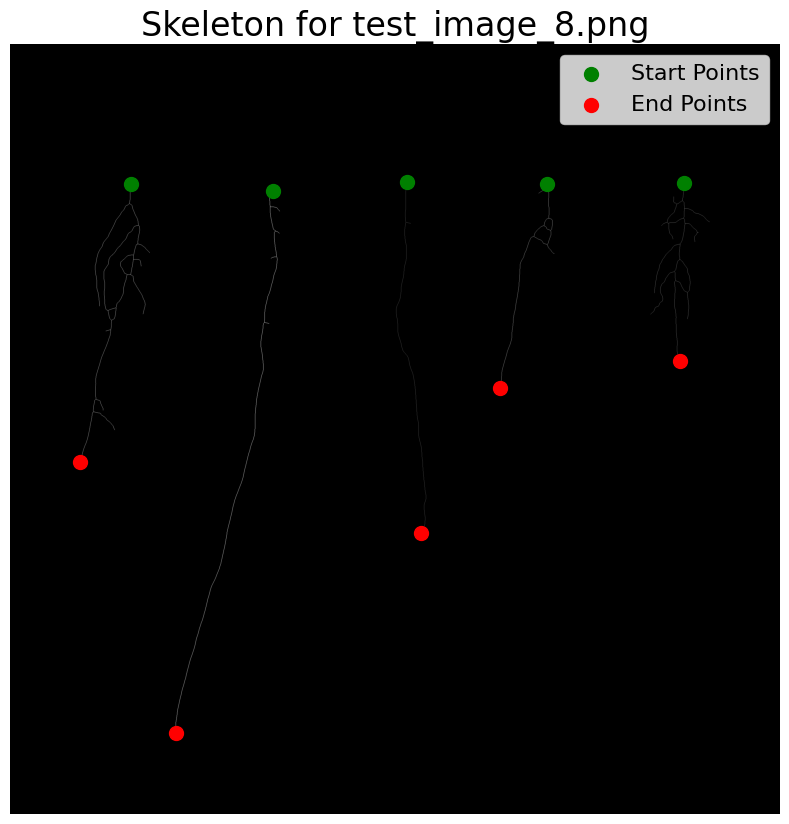

Processing test_image_9.png...


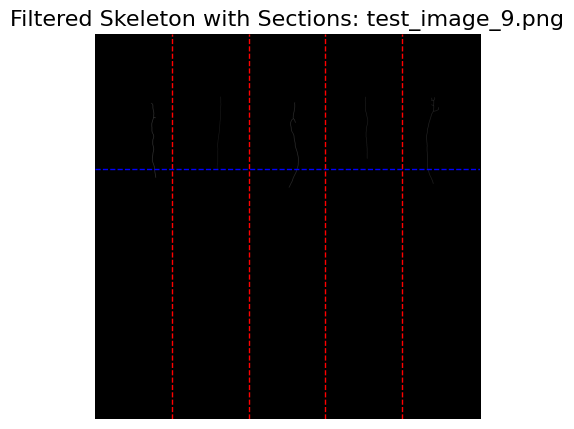

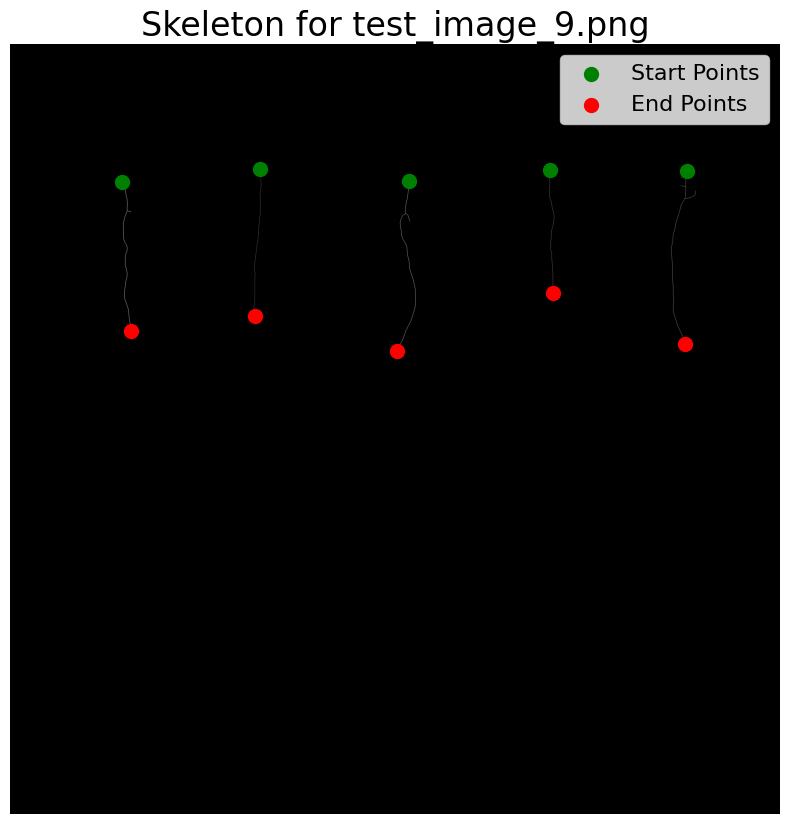

    skeleton-id           filename  start_y  start_x   end_y   end_x  \
0             0   test_image_1.png    476.0   1405.0   721.0  1438.0   
1             1   test_image_1.png    481.0    448.0   999.0   470.0   
2             2   test_image_1.png    575.0    572.0   638.0   566.0   
3             0  test_image_10.png    533.0   1932.0  1766.0  2016.0   
4             1  test_image_10.png    568.0   2456.0  1616.0  2535.0   
..          ...                ...      ...      ...     ...     ...   
81            0   test_image_9.png    458.0    915.0   995.0   895.0   
82            1   test_image_9.png    460.0   1973.0   911.0  1986.0   
83            2   test_image_9.png    463.0   2477.0  1095.0  2467.0   
84            3   test_image_9.png    500.0   1457.0  1122.0  1414.0   
85            4   test_image_9.png    505.0    409.0  1050.0   443.0   

    path_length  
0    259.497475  
1    568.149278  
2     68.798990  
3   1313.114790  
4   1124.345238  
..          ...  
81   556.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
from skan import Skeleton, summarize
import networkx as nx

# Process skeletonization and extract data for each binary connected component
all_start_end_data = []

for filename, binary_labels in processed_masks:
    print(f"Processing {filename}...")

    # Step 1: Skeletonize the binary mask
    skeleton_object = skeletonize(binary_labels > 0)

    # Step 2: Label connected components
    labeled_roots = label(skeleton_object)

    # Step 3: Define the horizontal line at the top 35% of the height
    top_limit_y = int(binary_labels.shape[0] * 0.35)

    # Step 4: Divide the image into 5 vertical sections and retain the largest component in the top part of each sector
    section_width = binary_labels.shape[1] // 5
    filtered_roots = np.zeros_like(labeled_roots)

    for sector_id in range(5):
        x_start = sector_id * section_width
        x_end = (sector_id + 1) * section_width if sector_id < 4 else binary_labels.shape[1]

        # Get the components in the top 35% of the sector
        sector_mask_top = labeled_roots[:top_limit_y, x_start:x_end]
        sector_labels_top = np.unique(sector_mask_top[sector_mask_top > 0])  # Exclude background

        # Find the largest component in the top part of the sector
        max_area = 0
        largest_label_top = 0
        for label_id in sector_labels_top:
            area = np.sum(labeled_roots[:top_limit_y, :] == label_id)  # Count all pixels for the label in the top part
            if area > max_area:
                max_area = area
                largest_label_top = label_id

        # Retain the largest component in the top part of this sector
        if largest_label_top > 0:
            filtered_roots[labeled_roots == largest_label_top] = largest_label_top

    # Step 5: Plot filtered roots with sections and the horizontal line
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(filtered_roots, cmap="gray")

    # Draw vertical lines to indicate sections
    for i in range(1, 5):  # 4 lines divide into 5 sections
        x = i * section_width
        ax.axvline(x=x, color="red", linestyle="--", linewidth=1)

    # Draw the horizontal line at 35% of the height
    ax.axhline(y=top_limit_y, color="blue", linestyle="--", linewidth=1)

    ax.set_title(f"Filtered Skeleton with Sections: {filename}", fontsize=16)
    ax.axis("off")
    plt.show()

    # Step 6: Summarize the skeleton
    skeleton_data = Skeleton(filtered_roots)
    branch_data = summarize(skeleton_data)

    # Step 7: Create a NetworkX graph from the skeleton branch data
    G = nx.from_pandas_edgelist(
        branch_data, 
        source='node-id-src', 
        target='node-id-dst', 
        edge_attr='branch-distance'
    )

    # Step 8: Extract start and end points of the skeleton
    results = []
    for skeleton_id, group in branch_data.groupby("skeleton-id"):
        # Start point (minimum y-coordinate)
        start_branch = group.loc[group[["image-coord-src-0", "image-coord-dst-0"]].min(axis=1).idxmin()]
        start_y = start_branch[["image-coord-src-0", "image-coord-dst-0"]].min()
        start_x = start_branch[["image-coord-src-1", "image-coord-dst-1"]].iloc[start_branch[["image-coord-src-0", "image-coord-dst-0"]].argmin()]

        # End point (maximum y-coordinate)
        end_branch = group.loc[group[["image-coord-src-0", "image-coord-dst-0"]].max(axis=1).idxmax()]
        end_y = end_branch[["image-coord-src-0", "image-coord-dst-0"]].max()
        end_x = end_branch[["image-coord-src-1", "image-coord-dst-1"]].iloc[end_branch[["image-coord-src-0", "image-coord-dst-0"]].argmax()]

        results.append({
            "skeleton-id": skeleton_id,
            "filename": filename,
            "start_y": start_y,
            "start_x": start_x,
            "end_y": end_y,
            "end_x": end_x
        })

    # Convert results to a DataFrame
    start_end_df = pd.DataFrame(results)

    # Step 9: Map coordinates to nodes and compute shortest paths
    coordinate_to_node = {}
    for _, row in branch_data.iterrows():
        coordinate_to_node[(row['image-coord-src-0'], row['image-coord-src-1'])] = row['node-id-src']
        coordinate_to_node[(row['image-coord-dst-0'], row['image-coord-dst-1'])] = row['node-id-dst']

    path_lengths = []
    for _, row in start_end_df.iterrows():
        src_node = coordinate_to_node.get((row['start_y'], row['start_x']), None)
        dst_node = coordinate_to_node.get((row['end_y'], row['end_x']), None)

        if src_node is not None and dst_node is not None and src_node in G.nodes and dst_node in G.nodes:
            try:
                path_len = nx.dijkstra_path_length(G, src_node, dst_node, weight='branch-distance')
                path_lengths.append(path_len)
            except nx.NetworkXNoPath:
                path_lengths.append(None)
        else:
            path_lengths.append(None)

    start_end_df['path_length'] = path_lengths
    all_start_end_data.append(start_end_df)

    # Visualize skeleton with start and end points
    plt.figure(figsize=(15, 10))
    plt.title(f"Skeleton for {filename}", fontsize=24)
    plt.imshow(filtered_roots, cmap='gray')  # Updated to display filtered_roots
    plt.scatter(start_end_df["start_x"], start_end_df["start_y"], color='green', label='Start Points', s=100)
    plt.scatter(start_end_df["end_x"], start_end_df["end_y"], color='red', label='End Points', s=100)
    plt.legend(fontsize=16)
    plt.axis("off")
    plt.show()

# Combine all results into a single DataFrame
final_data = pd.concat(all_start_end_data, ignore_index=True)

# Display the final results
print(final_data)


In [23]:
final_data["filename"]

0      test_image_1.png
1      test_image_1.png
2      test_image_1.png
3     test_image_10.png
4     test_image_10.png
            ...        
81     test_image_9.png
82     test_image_9.png
83     test_image_9.png
84     test_image_9.png
85     test_image_9.png
Name: filename, Length: 86, dtype: object

In [31]:
# Filter the data to get the rows where filename is "test_image_8.png"
f = final_data[final_data["filename"] == "test_image_8.png"]

# Check if the filtered DataFrame is not empty
if not f.empty:
    # Get all unique start_y values
    unique_start_y = f["start_y"].unique()

    # Get all skeleton IDs
    skeleton_ids = f["skeleton-id"].unique()

    print("Unique start_y values:")
    print(unique_start_y)
    print("\nAll skeleton IDs:")
    print(skeleton_ids)
else:
    print("No data found for filename 'test_image_8.png'")

Unique start_y values:
[505. 508. 512. 513. 536.]

All skeleton IDs:
[0 1 2 3 4]


In [14]:
import numpy as np
import pandas as pd

# Initialize results
results = []

# Define the number of sectors (5) and calculate sector boundaries
num_sectors = 5
image_width = final_data["start_x"].max() + 1  # Assuming start_x represents horizontal pixel positions
sector_width = image_width // num_sectors

# Group by filename and process each group
for filename, group in final_data.groupby("filename"):
    # Create an array to store lengths for each sector
    sector_lengths = [0] * num_sectors

    # Assign roots to sectors based on their start_x position
    for _, row in group.iterrows():
        sector_index = int(row["start_x"] // sector_width)  # Determine the sector based on start_x
        sector_index = min(sector_index, num_sectors - 1)  # Ensure it's within bounds (sector 0 to 4)
        path_length = round(row["path_length"])
        sector_lengths[sector_index] = path_length  # Store the length for the corresponding sector

    # Add results for each sector (plant ID 1 to 5)
    for plant_id in range(1, num_sectors + 1):
        results.append([f"{filename[:-4]}_plant_{plant_id}", sector_lengths[plant_id - 1]])

# Convert results to DataFrame for submission
submission_df = pd.DataFrame(results, columns=["Plant ID","Length (px)"])

# Save to CSV
submission_df.to_csv("submission_corrected.csv", index=False, header=False)

# Print a preview of the submission file
print(submission_df.head())


               Plant ID  Length (px)
0  test_image_1_plant_1          568
1  test_image_1_plant_2           69
2  test_image_1_plant_3          259
3  test_image_1_plant_4            0
4  test_image_1_plant_5            0
